In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda, Input
from tensorflow.keras.models import Model
plt.style.use('default')
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('sp500.csv')
print(df.shape)
df.head()

(2790, 5)


,Date,Close,Open,High,Low
0,2021/8/3,4423.15,4392.74,4423.79,4373.00
1,2021/8/2,4387.11,4406.86,4422.18,4384.81
2,2021/7/30,4395.26,4395.12,4412.25,4389.65
3,2021/7/29,4419.15,4403.59,4429.97,4403.59
4,2021/7/28,4400.65,4402.95,4415.47,4387.01


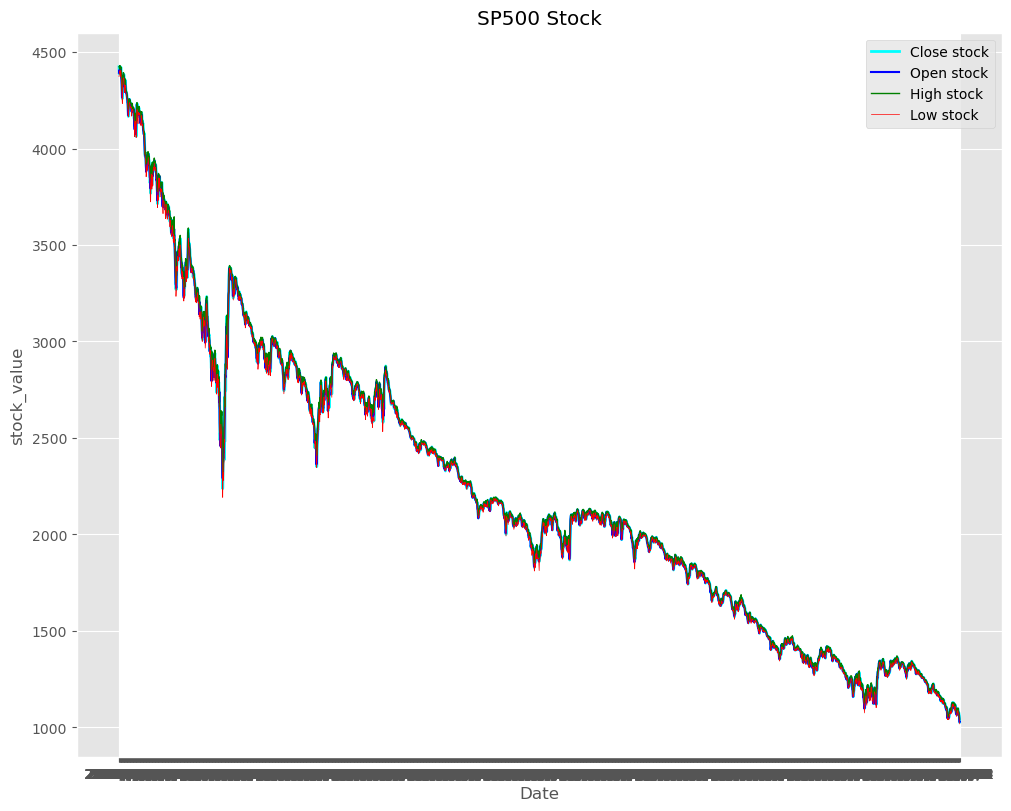

In [3]:
plt.figure(figsize=(10, 8), constrained_layout=True)
c = ['cyan', 'blue', 'green', 'red']
y = ['Close', 'Open', 'High', 'Low']
l = 2.0
for j, c in zip(y, c):
  plt.plot(df['Date'], df[j], color=c, linewidth=l, label=f'{j} stock')
  plt.title('SP500 Stock')
  plt.xlabel('Date')
  plt.ylabel('stock_value')
  plt.legend()
  l -=0.5

plt.show()

In [4]:
from PyEMD import CEEMDAN, Visualisation

In [5]:
close = df[['Close']].values

In [6]:
close

array([[4423.15],
       [4387.11],
       [4395.26],
       ...,
       [1070.25],
       [1060.27],
       [1028.06]])

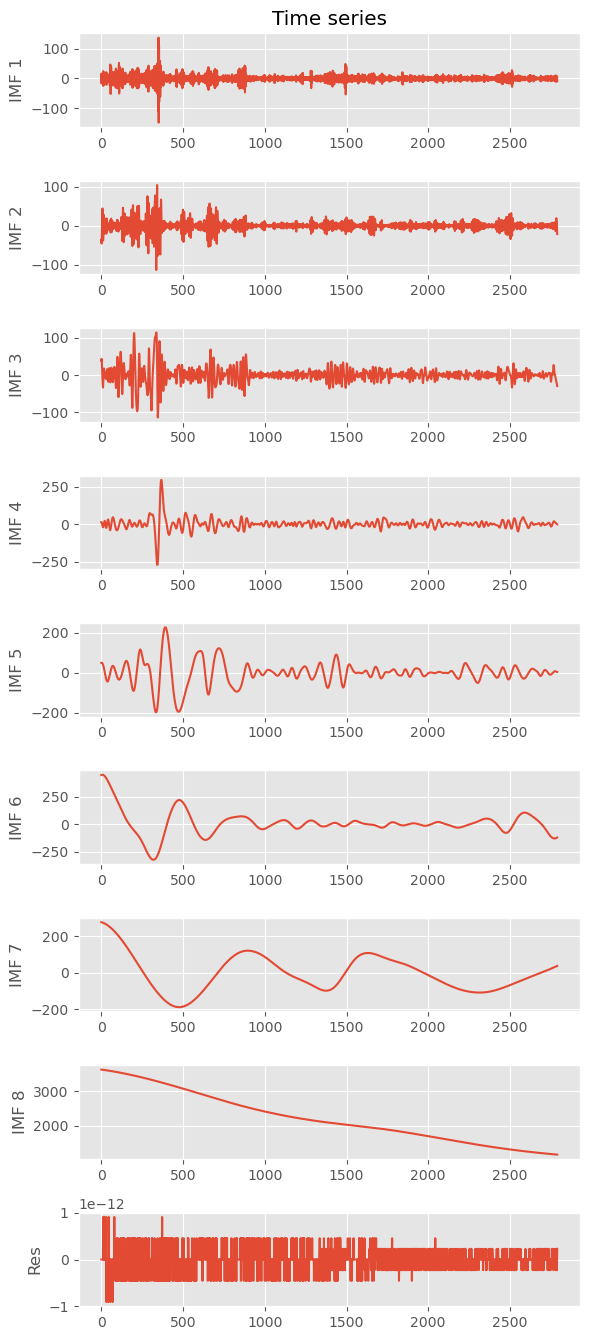

In [7]:
ceemdan = CEEMDAN()
ceemdan.ceemdan(close.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, 2790, 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [50]:
imfs_close[1][2400:2440]

array([ -1.17000645,   0.61857087,   1.32586285,  -1.89675986,
        -4.53803571,  -1.94379581,   6.8806275 ,  15.0382744 ,
        15.15651882,   5.79918291,  -8.02865689, -20.61810305,
       -30.22341171, -35.06055467,  -7.23524696,  37.76305352])

In [8]:
# 取之前X_lag个数据来预测下一个数据
def time_slice(data,X_lag):
    sample = []
    label = []
    for k in range(len(data) - X_lag - 1):
        t = k + X_lag
        sample.append(data[k:t])
        label.append(data[t + 1])
    return sample,label


In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import pandas as pd
import numpy as np
import time

In [10]:
def create_model():
    model = Sequential()
    model.add(LSTM(15, input_shape=(None,1)))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [11]:
def implement_LSTM(X_train, y_train):
    param_grid = {'epochs': [200, 300, 400], 
                              'batch_size': [8, 16]}
    
    model = KerasRegressor(build_fn=create_model)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    
    return grid_search.best_estimator_

# def implement_LSTM(X_train, y_train):
#     model = Sequential()
#     model.add(LSTM(15, input_shape=(None,1)))
#     model.add(Dense(1))
#     model.summary()
#     model.compile(loss='mean_squared_error', optimizer='adam')
# #     model.compile(loss='mean_squared_error', optimizer='sgd')
#     model.fit(X_train, y_train, epochs=350, batch_size=16, verbose=0)
    
#     return model

In [12]:
def implement_BP(X_train, y_train):
    param_grid = {'hidden_layer_sizes': [(3,), (10,), (30,), (9,), (20,)], 'learning_rate_init': [0.001, 0.1, 0.2, 0.3, 0.01],
                  'max_iter': [8000]}
    model = MLPRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    
#     model = MLPRegressor(hidden_layer_sizes=(10,), random_state=10, learning_rate_init=0.1)  # BP神经网络回归模型
#     model.fit(X_train,y_train)  # 训练模型
    
    return grid_search.best_estimator_

In [13]:
def implement_IR(X_train, y_train):
#     model = IsotonicRegression()  
    model = LinearRegression()
    model.fit(X_train,y_train)  # 训练模型
    
    return model

In [14]:
def split(sample, label, test_ratio):
    length = len(label)
    train_len = round((1-test_ratio)*length)
    X_train = sample[0:train_len]
    X_test = sample[train_len+1:length]
    y_train = label[0:train_len]
    y_test = label[train_len+1:length]
    
    return X_train, X_test, y_train, y_test

In [52]:
X_test

[array([15.41251429, 15.24111054, 15.06804366, 14.89332048, 14.71694782,
        14.53893251, 14.35928137, 14.17800125, 13.99509895, 13.81058131,
        13.62445516, 13.43672733, 13.24740464, 13.05649391, 12.86400198,
        12.66993567, 12.47430182, 12.27710724, 12.07835876, 11.87806322,
        11.67622744, 11.47285824, 11.26796246, 11.06154692, 10.85361844,
        10.64418387, 10.43325001, 10.22082371, 10.00691178,  9.79152106]),
 array([15.24111054, 15.06804366, 14.89332048, 14.71694782, 14.53893251,
        14.35928137, 14.17800125, 13.99509895, 13.81058131, 13.62445516,
        13.43672733, 13.24740464, 13.05649391, 12.86400198, 12.66993567,
        12.47430182, 12.27710724, 12.07835876, 11.87806322, 11.67622744,
        11.47285824, 11.26796246, 11.06154692, 10.85361844, 10.64418387,
        10.43325001, 10.22082371, 10.00691178,  9.79152106,  9.57465837]),
 array([15.06804366, 14.89332048, 14.71694782, 14.53893251, 14.35928137,
        14.17800125, 13.99509895, 13.81058131, 

In [15]:
svr = []
prediction = []
actual = []
i = 1


# LSTM for low frequency (IMF 123)
for imf in imfs_close[0:3]:    
    # 生成time series dataset
    sample,label = time_slice(imf,30)
    
    # 数据集划分
#     X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split(sample, label, 0.2)
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.asarray(X_test)
    X_test = np.expand_dims(X_test, axis=2)
    
    tmp = implement_LSTM(X_train, y_train)
    
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test)
    prediction.append(pre_tmp)
    
    print(i)
    print(imf)
    i = i + 1

    
# BP for medium frequency (IMF 45)
for imf in imfs_close[3:5]:    
    # 生成time series dataset
    sample,label = time_slice(imf,30)
    
    # 数据集划分
#     X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split(sample, label, 0.2)
    tmp = implement_BP(X_train, y_train)
    
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test)
    prediction.append(pre_tmp)
    
    print(i)
    print(imf)
    i = i + 1
    imf
    
    
# Linear Regression for high frequency (IMF 678)
for imf in imfs_close[5:8]:    
    # 生成time series dataset
    sample,label = time_slice(imf,30)
    
    # 数据集划分
#     X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split(sample, label, 0.2)
    tmp = implement_IR(X_train, y_train)
    
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test)
    prediction.append(pre_tmp)
    
    print(i)
    print(imf)
    i = i + 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                1020      
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
221/221 [==============================] - 1s 6ms/step - loss: 81.8101
Epoch 2/200
221/221 [==============================] - 1s 6ms/step - loss: 80.2690
Epoch 3/200
221/221 [==============================] - 1s 6ms/step - loss: 79.6103
Epoch 4/200
221/221 [==============================] - 1s 6ms/step - loss: 79.3299
Epoch 5/200
221/221 [==============================] - 1s 6ms/step - loss: 79.2003
Epoch 6/200
221/221 [==============================] - 1s 6ms/step - loss: 78.9988
Epoch 7/200
221/22

221/221 [==============================] - 1s 6ms/step - loss: 62.5394
Epoch 92/200
221/221 [==============================] - 1s 6ms/step - loss: 62.1110
Epoch 93/200
221/221 [==============================] - 1s 6ms/step - loss: 61.8062
Epoch 94/200
221/221 [==============================] - 1s 6ms/step - loss: 61.7284
Epoch 95/200
221/221 [==============================] - 1s 6ms/step - loss: 61.2618
Epoch 96/200
221/221 [==============================] - 1s 6ms/step - loss: 60.8370
Epoch 97/200
221/221 [==============================] - 1s 6ms/step - loss: 60.6933
Epoch 98/200
221/221 [==============================] - 1s 6ms/step - loss: 60.5060
Epoch 99/200
221/221 [==============================] - 1s 6ms/step - loss: 59.5453
Epoch 100/200
221/221 [==============================] - 1s 6ms/step - loss: 59.8516
Epoch 101/200
221/221 [==============================] - 1s 6ms/step - loss: 59.4644
Epoch 102/200
221/221 [==============================] - 1s 6ms/step - loss: 58.9613
Ep

221/221 [==============================] - 1s 6ms/step - loss: 44.9489
Epoch 188/200
221/221 [==============================] - 1s 6ms/step - loss: 45.3396
Epoch 189/200
221/221 [==============================] - 1s 6ms/step - loss: 44.8031
Epoch 190/200
221/221 [==============================] - 1s 6ms/step - loss: 44.9352
Epoch 191/200
221/221 [==============================] - 1s 6ms/step - loss: 44.6246
Epoch 192/200
221/221 [==============================] - 1s 6ms/step - loss: 44.2789
Epoch 193/200
221/221 [==============================] - 1s 6ms/step - loss: 43.9173
Epoch 194/200
221/221 [==============================] - 1s 6ms/step - loss: 44.3319
Epoch 195/200
221/221 [==============================] - 1s 6ms/step - loss: 44.7158
Epoch 196/200
221/221 [==============================] - 1s 6ms/step - loss: 44.2571
Epoch 197/200
221/221 [==============================] - 1s 6ms/step - loss: 43.7388
Epoch 198/200
221/221 [==============================] - 1s 6ms/step - loss: 43

221/221 [==============================] - 1s 6ms/step - loss: 161.3767
Epoch 77/200
221/221 [==============================] - 1s 6ms/step - loss: 163.1831
Epoch 78/200
221/221 [==============================] - 1s 6ms/step - loss: 161.0424
Epoch 79/200
221/221 [==============================] - 1s 7ms/step - loss: 161.1997
Epoch 80/200
221/221 [==============================] - 1s 7ms/step - loss: 160.8667
Epoch 81/200
221/221 [==============================] - 1s 7ms/step - loss: 161.3745
Epoch 82/200
221/221 [==============================] - 1s 6ms/step - loss: 160.0316
Epoch 83/200
221/221 [==============================] - 1s 7ms/step - loss: 159.9255
Epoch 84/200
221/221 [==============================] - 1s 6ms/step - loss: 160.2114
Epoch 85/200
221/221 [==============================] - 1s 7ms/step - loss: 160.6881
Epoch 86/200
221/221 [==============================] - 1s 6ms/step - loss: 159.1046
Epoch 87/200
221/221 [==============================] - 1s 6ms/step - loss: 15

221/221 [==============================] - 1s 7ms/step - loss: 142.6839
Epoch 172/200
221/221 [==============================] - 1s 7ms/step - loss: 146.7797
Epoch 173/200
221/221 [==============================] - 1s 6ms/step - loss: 142.7602
Epoch 174/200
221/221 [==============================] - 1s 6ms/step - loss: 141.5864
Epoch 175/200
221/221 [==============================] - 1s 6ms/step - loss: 141.9718
Epoch 176/200
221/221 [==============================] - 1s 7ms/step - loss: 141.2135
Epoch 177/200
221/221 [==============================] - 1s 6ms/step - loss: 142.0010
Epoch 178/200
221/221 [==============================] - 1s 6ms/step - loss: 140.8053
Epoch 179/200
221/221 [==============================] - 1s 6ms/step - loss: 140.7964
Epoch 180/200
221/221 [==============================] - 1s 6ms/step - loss: 141.5507
Epoch 181/200
221/221 [==============================] - 1s 6ms/step - loss: 140.7091
Epoch 182/200
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 197.6512
Epoch 61/200
221/221 [==============================] - 1s 6ms/step - loss: 202.1385
Epoch 62/200
221/221 [==============================] - 2s 7ms/step - loss: 198.0030
Epoch 63/200
221/221 [==============================] - 1s 6ms/step - loss: 200.1592
Epoch 64/200
221/221 [==============================] - 1s 6ms/step - loss: 200.1091
Epoch 65/200
221/221 [==============================] - 1s 7ms/step - loss: 198.7357
Epoch 66/200
221/221 [==============================] - 1s 7ms/step - loss: 197.6193
Epoch 67/200
221/221 [==============================] - 1s 6ms/step - loss: 197.1831
Epoch 68/200
221/221 [==============================] - 1s 6ms/step - loss: 197.1166
Epoch 69/200
221/221 [==============================] - 1s 7ms/step - loss: 196.8232
Epoch 70/200
221/221 [==============================] - 1s 7ms/step - loss: 196.9821
Epoch 71/200
221/221 [==============================] - 1s 7ms/step - loss: 19

221/221 [==============================] - 1s 6ms/step - loss: 185.6228
Epoch 156/200
221/221 [==============================] - 1s 6ms/step - loss: 185.4025
Epoch 157/200
221/221 [==============================] - 1s 6ms/step - loss: 185.1246
Epoch 158/200
221/221 [==============================] - 1s 6ms/step - loss: 185.2084
Epoch 159/200
221/221 [==============================] - 1s 6ms/step - loss: 185.2062
Epoch 160/200
221/221 [==============================] - 1s 6ms/step - loss: 185.0016
Epoch 161/200
221/221 [==============================] - 1s 6ms/step - loss: 186.1985
Epoch 162/200
221/221 [==============================] - 1s 6ms/step - loss: 184.6102
Epoch 163/200
221/221 [==============================] - 1s 6ms/step - loss: 184.6231
Epoch 164/200
221/221 [==============================] - 1s 6ms/step - loss: 184.5760
Epoch 165/200
221/221 [==============================] - 1s 6ms/step - loss: 184.6724
Epoch 166/200
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 7ms/step - loss: 186.4627
Epoch 44/200
221/221 [==============================] - 1s 7ms/step - loss: 186.0731
Epoch 45/200
221/221 [==============================] - 1s 7ms/step - loss: 186.1792
Epoch 46/200
221/221 [==============================] - 1s 7ms/step - loss: 185.6996
Epoch 47/200
221/221 [==============================] - 1s 7ms/step - loss: 185.7563
Epoch 48/200
221/221 [==============================] - 1s 6ms/step - loss: 185.5865
Epoch 49/200
221/221 [==============================] - 1s 7ms/step - loss: 185.3560
Epoch 50/200
221/221 [==============================] - 1s 7ms/step - loss: 185.2340
Epoch 51/200
221/221 [==============================] - 1s 6ms/step - loss: 185.2247
Epoch 52/200
221/221 [==============================] - 1s 7ms/step - loss: 185.2040
Epoch 53/200
221/221 [==============================] - 1s 7ms/step - loss: 184.8176
Epoch 54/200
221/221 [==============================] - 1s 6ms/step - loss: 18

221/221 [==============================] - 1s 6ms/step - loss: 175.9090
Epoch 139/200
221/221 [==============================] - 1s 6ms/step - loss: 173.6839
Epoch 140/200
221/221 [==============================] - 1s 6ms/step - loss: 173.6004
Epoch 141/200
221/221 [==============================] - 1s 6ms/step - loss: 173.4995
Epoch 142/200
221/221 [==============================] - 1s 6ms/step - loss: 173.0881
Epoch 143/200
221/221 [==============================] - 1s 6ms/step - loss: 172.9535
Epoch 144/200
221/221 [==============================] - 1s 6ms/step - loss: 173.0308
Epoch 145/200
221/221 [==============================] - 1s 6ms/step - loss: 173.8872
Epoch 146/200
221/221 [==============================] - 1s 6ms/step - loss: 172.1926
Epoch 147/200
221/221 [==============================] - 1s 6ms/step - loss: 172.3604
Epoch 148/200
221/221 [==============================] - 1s 6ms/step - loss: 172.0935
Epoch 149/200
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 7ms/step - loss: 206.0680
Epoch 27/200
221/221 [==============================] - 1s 6ms/step - loss: 205.8961
Epoch 28/200
221/221 [==============================] - 1s 6ms/step - loss: 205.1905
Epoch 29/200
221/221 [==============================] - 1s 6ms/step - loss: 204.8666
Epoch 30/200
221/221 [==============================] - 1s 6ms/step - loss: 204.3983
Epoch 31/200
221/221 [==============================] - 1s 6ms/step - loss: 204.0544
Epoch 32/200
221/221 [==============================] - 1s 6ms/step - loss: 203.6492
Epoch 33/200
221/221 [==============================] - 1s 6ms/step - loss: 203.4972
Epoch 34/200
221/221 [==============================] - 1s 6ms/step - loss: 203.1059
Epoch 35/200
221/221 [==============================] - 1s 6ms/step - loss: 202.7612
Epoch 36/200
221/221 [==============================] - 1s 6ms/step - loss: 202.5781
Epoch 37/200
221/221 [==============================] - 1s 6ms/step - loss: 20

221/221 [==============================] - 1s 6ms/step - loss: 182.1992
Epoch 123/200
221/221 [==============================] - 1s 6ms/step - loss: 181.8354
Epoch 124/200
221/221 [==============================] - 1s 6ms/step - loss: 182.5373
Epoch 125/200
221/221 [==============================] - 1s 6ms/step - loss: 182.3423
Epoch 126/200
221/221 [==============================] - 1s 6ms/step - loss: 181.7131
Epoch 127/200
221/221 [==============================] - 1s 6ms/step - loss: 184.0313
Epoch 128/200
221/221 [==============================] - 1s 6ms/step - loss: 182.0934
Epoch 129/200
221/221 [==============================] - 1s 6ms/step - loss: 181.2743
Epoch 130/200
221/221 [==============================] - 1s 6ms/step - loss: 181.5114
Epoch 131/200
221/221 [==============================] - 1s 6ms/step - loss: 182.0462
Epoch 132/200
221/221 [==============================] - 1s 6ms/step - loss: 180.9396
Epoch 133/200
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 78.9402
Epoch 11/300
221/221 [==============================] - 1s 6ms/step - loss: 78.7910
Epoch 12/300
221/221 [==============================] - 1s 6ms/step - loss: 78.6988
Epoch 13/300
221/221 [==============================] - 1s 6ms/step - loss: 78.5601
Epoch 14/300
221/221 [==============================] - 1s 6ms/step - loss: 78.4456
Epoch 15/300
221/221 [==============================] - 1s 6ms/step - loss: 78.3858
Epoch 16/300
221/221 [==============================] - 1s 6ms/step - loss: 78.2407
Epoch 17/300
221/221 [==============================] - 1s 6ms/step - loss: 78.1321
Epoch 18/300
221/221 [==============================] - 1s 6ms/step - loss: 78.1529
Epoch 19/300
221/221 [==============================] - 1s 6ms/step - loss: 77.9461
Epoch 20/300
221/221 [==============================] - 1s 6ms/step - loss: 77.8491
Epoch 21/300
221/221 [==============================] - 1s 6ms/step - loss: 77.7646
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 66.2376
Epoch 108/300
221/221 [==============================] - 1s 6ms/step - loss: 66.1084
Epoch 109/300
221/221 [==============================] - 1s 6ms/step - loss: 65.4985
Epoch 110/300
221/221 [==============================] - 1s 6ms/step - loss: 65.5188
Epoch 111/300
221/221 [==============================] - 1s 6ms/step - loss: 65.0693
Epoch 112/300
221/221 [==============================] - 1s 6ms/step - loss: 64.6685
Epoch 113/300
221/221 [==============================] - 1s 6ms/step - loss: 64.7749
Epoch 114/300
221/221 [==============================] - 1s 6ms/step - loss: 64.3956
Epoch 115/300
221/221 [==============================] - 1s 6ms/step - loss: 64.2611
Epoch 116/300
221/221 [==============================] - 1s 6ms/step - loss: 64.1358
Epoch 117/300
221/221 [==============================] - 1s 6ms/step - loss: 63.7046
Epoch 118/300
221/221 [==============================] - 1s 6ms/step - loss: 63

221/221 [==============================] - 1s 6ms/step - loss: 47.1324
Epoch 204/300
221/221 [==============================] - 1s 6ms/step - loss: 47.4509
Epoch 205/300
221/221 [==============================] - 1s 6ms/step - loss: 47.5534
Epoch 206/300
221/221 [==============================] - 1s 6ms/step - loss: 47.1629
Epoch 207/300
221/221 [==============================] - 1s 6ms/step - loss: 47.7419
Epoch 208/300
221/221 [==============================] - 1s 6ms/step - loss: 46.7615
Epoch 209/300
221/221 [==============================] - 1s 6ms/step - loss: 46.9011
Epoch 210/300
221/221 [==============================] - 1s 6ms/step - loss: 46.6150
Epoch 211/300
221/221 [==============================] - 1s 6ms/step - loss: 46.1074
Epoch 212/300
221/221 [==============================] - 1s 6ms/step - loss: 46.2035
Epoch 213/300
221/221 [==============================] - 1s 6ms/step - loss: 47.5639
Epoch 214/300
221/221 [==============================] - 1s 6ms/step - loss: 45

221/221 [==============================] - 1s 6ms/step - loss: 41.2951
Epoch 300/300
221/221 [==============================] - 1s 6ms/step - loss: 38.2343
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
221/221 [==============================] - 1s 6ms/step - loss: 178.4978
Epoch 2/300
221/221 [==============================] - 1s 6ms/step - loss: 178.2306
Epoch 3/300
221/221 [==============================] - 1s 6ms/step - loss: 178.0724
Epoch 4/300
221/221 [==============================] - 1s 6ms/step - loss: 177.8303
Epoch 5/300
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 162.7867
Epoch 89/300
221/221 [==============================] - 1s 6ms/step - loss: 162.8751
Epoch 90/300
221/221 [==============================] - 1s 6ms/step - loss: 162.9698
Epoch 91/300
221/221 [==============================] - 1s 6ms/step - loss: 162.5714
Epoch 92/300
221/221 [==============================] - 1s 6ms/step - loss: 161.4758
Epoch 93/300
221/221 [==============================] - 1s 6ms/step - loss: 161.7351
Epoch 94/300
221/221 [==============================] - 1s 6ms/step - loss: 162.2106
Epoch 95/300
221/221 [==============================] - 1s 6ms/step - loss: 161.4690
Epoch 96/300
221/221 [==============================] - 1s 6ms/step - loss: 161.6874
Epoch 97/300
221/221 [==============================] - 1s 6ms/step - loss: 161.1470
Epoch 98/300
221/221 [==============================] - 1s 6ms/step - loss: 161.0034
Epoch 99/300
221/221 [==============================] - 1s 6ms/step - loss: 16

221/221 [==============================] - 1s 6ms/step - loss: 144.1437
Epoch 184/300
221/221 [==============================] - 1s 6ms/step - loss: 143.0507
Epoch 185/300
221/221 [==============================] - 1s 6ms/step - loss: 143.4259
Epoch 186/300
221/221 [==============================] - 1s 6ms/step - loss: 144.8274
Epoch 187/300
221/221 [==============================] - 1s 6ms/step - loss: 143.7437
Epoch 188/300
221/221 [==============================] - 1s 6ms/step - loss: 145.2905
Epoch 189/300
221/221 [==============================] - 1s 6ms/step - loss: 144.7081
Epoch 190/300
221/221 [==============================] - 1s 6ms/step - loss: 142.5502
Epoch 191/300
221/221 [==============================] - 1s 6ms/step - loss: 156.8139
Epoch 192/300
221/221 [==============================] - 1s 6ms/step - loss: 149.8912
Epoch 193/300
221/221 [==============================] - 1s 6ms/step - loss: 144.9035
Epoch 194/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 131.9357
Epoch 278/300
221/221 [==============================] - 1s 6ms/step - loss: 129.0356
Epoch 279/300
221/221 [==============================] - 1s 6ms/step - loss: 126.7639
Epoch 280/300
221/221 [==============================] - 1s 6ms/step - loss: 126.4902
Epoch 281/300
221/221 [==============================] - 1s 6ms/step - loss: 126.2886
Epoch 282/300
221/221 [==============================] - 1s 6ms/step - loss: 131.3447
Epoch 283/300
221/221 [==============================] - 1s 6ms/step - loss: 131.7441
Epoch 284/300
221/221 [==============================] - 1s 6ms/step - loss: 127.2662
Epoch 285/300
221/221 [==============================] - 1s 6ms/step - loss: 127.6740
Epoch 286/300
221/221 [==============================] - 1s 6ms/step - loss: 126.3825
Epoch 287/300
221/221 [==============================] - 1s 6ms/step - loss: 125.6191
Epoch 288/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 196.6755
Epoch 67/300
221/221 [==============================] - 1s 6ms/step - loss: 195.5135
Epoch 68/300
221/221 [==============================] - 1s 6ms/step - loss: 195.5494
Epoch 69/300
221/221 [==============================] - 1s 6ms/step - loss: 196.2842
Epoch 70/300
221/221 [==============================] - 1s 6ms/step - loss: 195.8360
Epoch 71/300
221/221 [==============================] - 1s 6ms/step - loss: 194.7766
Epoch 72/300
221/221 [==============================] - 1s 6ms/step - loss: 195.4817
Epoch 73/300
221/221 [==============================] - 1s 6ms/step - loss: 196.8326
Epoch 74/300
221/221 [==============================] - 1s 6ms/step - loss: 195.0309
Epoch 75/300
221/221 [==============================] - 1s 6ms/step - loss: 194.4659
Epoch 76/300
221/221 [==============================] - 1s 6ms/step - loss: 196.0803
Epoch 77/300
221/221 [==============================] - 1s 6ms/step - loss: 19

221/221 [==============================] - 1s 6ms/step - loss: 185.4702
Epoch 162/300
221/221 [==============================] - 1s 6ms/step - loss: 186.3883
Epoch 163/300
221/221 [==============================] - 1s 6ms/step - loss: 188.3855
Epoch 164/300
221/221 [==============================] - 1s 6ms/step - loss: 184.6054
Epoch 165/300
221/221 [==============================] - 1s 6ms/step - loss: 185.5790
Epoch 166/300
221/221 [==============================] - 1s 6ms/step - loss: 182.5717
Epoch 167/300
221/221 [==============================] - 1s 6ms/step - loss: 182.7253
Epoch 168/300
221/221 [==============================] - 1s 6ms/step - loss: 183.4070
Epoch 169/300
221/221 [==============================] - 1s 6ms/step - loss: 184.8895
Epoch 170/300
221/221 [==============================] - 1s 6ms/step - loss: 185.7834
Epoch 171/300
221/221 [==============================] - 1s 6ms/step - loss: 182.0518
Epoch 172/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 174.2986
Epoch 257/300
221/221 [==============================] - 1s 6ms/step - loss: 174.5074
Epoch 258/300
221/221 [==============================] - 1s 6ms/step - loss: 174.5928
Epoch 259/300
221/221 [==============================] - 1s 6ms/step - loss: 174.7288
Epoch 260/300
221/221 [==============================] - 1s 6ms/step - loss: 172.3268
Epoch 261/300
221/221 [==============================] - 1s 6ms/step - loss: 172.1742
Epoch 262/300
221/221 [==============================] - 1s 6ms/step - loss: 172.5793
Epoch 263/300
221/221 [==============================] - 1s 6ms/step - loss: 171.9562
Epoch 264/300
221/221 [==============================] - 1s 6ms/step - loss: 174.2224
Epoch 265/300
221/221 [==============================] - 1s 6ms/step - loss: 176.1480
Epoch 266/300
221/221 [==============================] - 1s 6ms/step - loss: 172.3962
Epoch 267/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 187.4142
Epoch 45/300
221/221 [==============================] - 1s 6ms/step - loss: 186.4869
Epoch 46/300
221/221 [==============================] - 1s 6ms/step - loss: 186.8172
Epoch 47/300
221/221 [==============================] - 1s 6ms/step - loss: 186.7132
Epoch 48/300
221/221 [==============================] - 1s 6ms/step - loss: 186.3947
Epoch 49/300
221/221 [==============================] - 1s 6ms/step - loss: 186.0355
Epoch 50/300
221/221 [==============================] - 1s 6ms/step - loss: 185.4788
Epoch 51/300
221/221 [==============================] - 1s 6ms/step - loss: 185.6862
Epoch 52/300
221/221 [==============================] - 1s 6ms/step - loss: 185.5932
Epoch 53/300
221/221 [==============================] - 1s 6ms/step - loss: 185.1265
Epoch 54/300
221/221 [==============================] - 1s 6ms/step - loss: 186.1802
Epoch 55/300
221/221 [==============================] - 1s 6ms/step - loss: 18

221/221 [==============================] - 1s 6ms/step - loss: 169.9120
Epoch 141/300
221/221 [==============================] - 1s 6ms/step - loss: 168.9163
Epoch 142/300
221/221 [==============================] - 1s 6ms/step - loss: 166.4433
Epoch 143/300
221/221 [==============================] - 1s 6ms/step - loss: 166.5637
Epoch 144/300
221/221 [==============================] - 1s 6ms/step - loss: 163.9716
Epoch 145/300
221/221 [==============================] - 1s 6ms/step - loss: 164.7410
Epoch 146/300
221/221 [==============================] - 1s 6ms/step - loss: 164.0368
Epoch 147/300
221/221 [==============================] - 1s 6ms/step - loss: 163.9319
Epoch 148/300
221/221 [==============================] - 1s 6ms/step - loss: 163.4389
Epoch 149/300
221/221 [==============================] - 1s 6ms/step - loss: 163.5773
Epoch 150/300
221/221 [==============================] - 1s 6ms/step - loss: 162.6956
Epoch 151/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 148.0953
Epoch 236/300
221/221 [==============================] - 1s 6ms/step - loss: 150.5158
Epoch 237/300
221/221 [==============================] - 1s 6ms/step - loss: 151.0022
Epoch 238/300
221/221 [==============================] - 1s 6ms/step - loss: 155.8651
Epoch 239/300
221/221 [==============================] - 1s 6ms/step - loss: 151.5006
Epoch 240/300
221/221 [==============================] - 1s 6ms/step - loss: 162.1065
Epoch 241/300
221/221 [==============================] - 1s 6ms/step - loss: 175.8932
Epoch 242/300
221/221 [==============================] - 1s 6ms/step - loss: 175.0193
Epoch 243/300
221/221 [==============================] - 1s 6ms/step - loss: 172.0603
Epoch 244/300
221/221 [==============================] - 1s 6ms/step - loss: 175.0998
Epoch 245/300
221/221 [==============================] - 1s 6ms/step - loss: 175.4458
Epoch 246/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 207.9698
Epoch 24/300
221/221 [==============================] - 1s 6ms/step - loss: 207.7696
Epoch 25/300
221/221 [==============================] - 1s 6ms/step - loss: 207.5405
Epoch 26/300
221/221 [==============================] - 1s 6ms/step - loss: 207.1112
Epoch 27/300
221/221 [==============================] - 1s 6ms/step - loss: 207.2773
Epoch 28/300
221/221 [==============================] - 1s 6ms/step - loss: 206.8179
Epoch 29/300
221/221 [==============================] - 1s 6ms/step - loss: 206.5920
Epoch 30/300
221/221 [==============================] - 1s 6ms/step - loss: 206.3191
Epoch 31/300
221/221 [==============================] - 1s 6ms/step - loss: 206.1741
Epoch 32/300
221/221 [==============================] - 1s 6ms/step - loss: 205.9636
Epoch 33/300
221/221 [==============================] - 1s 6ms/step - loss: 205.8525
Epoch 34/300
221/221 [==============================] - 1s 6ms/step - loss: 20

221/221 [==============================] - 1s 6ms/step - loss: 189.8244
Epoch 120/300
221/221 [==============================] - 1s 6ms/step - loss: 189.5195
Epoch 121/300
221/221 [==============================] - 1s 6ms/step - loss: 189.0011
Epoch 122/300
221/221 [==============================] - 1s 6ms/step - loss: 189.1588
Epoch 123/300
221/221 [==============================] - 1s 6ms/step - loss: 189.4040
Epoch 124/300
221/221 [==============================] - 1s 6ms/step - loss: 189.3874
Epoch 125/300
221/221 [==============================] - 1s 6ms/step - loss: 188.0497
Epoch 126/300
221/221 [==============================] - 1s 6ms/step - loss: 188.1565
Epoch 127/300
221/221 [==============================] - 1s 6ms/step - loss: 187.8238
Epoch 128/300
221/221 [==============================] - 1s 6ms/step - loss: 187.7413
Epoch 129/300
221/221 [==============================] - 1s 6ms/step - loss: 187.8326
Epoch 130/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 173.1247
Epoch 215/300
221/221 [==============================] - 1s 6ms/step - loss: 170.2075
Epoch 216/300
221/221 [==============================] - 1s 6ms/step - loss: 170.1367
Epoch 217/300
221/221 [==============================] - 1s 6ms/step - loss: 171.0807
Epoch 218/300
221/221 [==============================] - 1s 6ms/step - loss: 171.1934
Epoch 219/300
221/221 [==============================] - 1s 6ms/step - loss: 174.7003
Epoch 220/300
221/221 [==============================] - 1s 6ms/step - loss: 172.2040
Epoch 221/300
221/221 [==============================] - 2s 7ms/step - loss: 170.7453
Epoch 222/300
221/221 [==============================] - 2s 7ms/step - loss: 170.9843
Epoch 223/300
221/221 [==============================] - 1s 6ms/step - loss: 168.8931
Epoch 224/300
221/221 [==============================] - 1s 6ms/step - loss: 169.5719
Epoch 225/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 81.6427
Epoch 3/400
221/221 [==============================] - 1s 6ms/step - loss: 80.5167
Epoch 4/400
221/221 [==============================] - 1s 6ms/step - loss: 79.9594
Epoch 5/400
221/221 [==============================] - 1s 6ms/step - loss: 79.5440
Epoch 6/400
221/221 [==============================] - 1s 6ms/step - loss: 79.2081
Epoch 7/400
221/221 [==============================] - 1s 6ms/step - loss: 78.9815
Epoch 8/400
221/221 [==============================] - 1s 6ms/step - loss: 78.7841
Epoch 9/400
221/221 [==============================] - 1s 6ms/step - loss: 78.6514
Epoch 10/400
221/221 [==============================] - 1s 6ms/step - loss: 78.5094
Epoch 11/400
221/221 [==============================] - 1s 6ms/step - loss: 78.3075
Epoch 12/400
221/221 [==============================] - 1s 6ms/step - loss: 78.1794
Epoch 13/400
221/221 [==============================] - 1s 6ms/step - loss: 78.0378
Epoch 14/400

221/221 [==============================] - 1s 6ms/step - loss: 63.4623
Epoch 100/400
221/221 [==============================] - 1s 6ms/step - loss: 63.2586
Epoch 101/400
221/221 [==============================] - 1s 6ms/step - loss: 62.9227
Epoch 102/400
221/221 [==============================] - 1s 6ms/step - loss: 62.9298
Epoch 103/400
221/221 [==============================] - 1s 6ms/step - loss: 62.2948
Epoch 104/400
221/221 [==============================] - 1s 6ms/step - loss: 62.8001
Epoch 105/400
221/221 [==============================] - 1s 6ms/step - loss: 61.8381
Epoch 106/400
221/221 [==============================] - 1s 6ms/step - loss: 61.7498
Epoch 107/400
221/221 [==============================] - 1s 6ms/step - loss: 61.4449
Epoch 108/400
221/221 [==============================] - 1s 6ms/step - loss: 61.2699
Epoch 109/400
221/221 [==============================] - 1s 6ms/step - loss: 61.3013
Epoch 110/400
221/221 [==============================] - 1s 6ms/step - loss: 61

221/221 [==============================] - 1s 6ms/step - loss: 45.4479
Epoch 196/400
221/221 [==============================] - 1s 6ms/step - loss: 44.6320
Epoch 197/400
221/221 [==============================] - 1s 6ms/step - loss: 44.0310
Epoch 198/400
221/221 [==============================] - 1s 6ms/step - loss: 44.2760
Epoch 199/400
221/221 [==============================] - 1s 6ms/step - loss: 43.8979
Epoch 200/400
221/221 [==============================] - 1s 6ms/step - loss: 43.8610
Epoch 201/400
221/221 [==============================] - 1s 6ms/step - loss: 43.7541
Epoch 202/400
221/221 [==============================] - 1s 6ms/step - loss: 44.5149
Epoch 203/400
221/221 [==============================] - 1s 6ms/step - loss: 43.7665
Epoch 204/400
221/221 [==============================] - 1s 6ms/step - loss: 43.6051
Epoch 205/400
221/221 [==============================] - 1s 6ms/step - loss: 44.5134
Epoch 206/400
221/221 [==============================] - 1s 6ms/step - loss: 43

221/221 [==============================] - 1s 6ms/step - loss: 37.5223
Epoch 292/400
221/221 [==============================] - 1s 6ms/step - loss: 35.8051
Epoch 293/400
221/221 [==============================] - 1s 6ms/step - loss: 35.5874
Epoch 294/400
221/221 [==============================] - 1s 6ms/step - loss: 37.0441
Epoch 295/400
221/221 [==============================] - 1s 6ms/step - loss: 39.5723
Epoch 296/400
221/221 [==============================] - 1s 6ms/step - loss: 39.1250
Epoch 297/400
221/221 [==============================] - 1s 6ms/step - loss: 39.1089
Epoch 298/400
221/221 [==============================] - 1s 6ms/step - loss: 37.5449
Epoch 299/400
221/221 [==============================] - 1s 6ms/step - loss: 37.9972
Epoch 300/400
221/221 [==============================] - 1s 6ms/step - loss: 37.1988
Epoch 301/400
221/221 [==============================] - 1s 6ms/step - loss: 36.6861
Epoch 302/400
221/221 [==============================] - 1s 6ms/step - loss: 36

221/221 [==============================] - 1s 6ms/step - loss: 31.5595
Epoch 388/400
221/221 [==============================] - 1s 6ms/step - loss: 31.3263
Epoch 389/400
221/221 [==============================] - 1s 6ms/step - loss: 31.9437
Epoch 390/400
221/221 [==============================] - 1s 6ms/step - loss: 31.3002
Epoch 391/400
221/221 [==============================] - 1s 6ms/step - loss: 36.9758
Epoch 392/400
221/221 [==============================] - 1s 6ms/step - loss: 39.3222
Epoch 393/400
221/221 [==============================] - 1s 6ms/step - loss: 33.6127
Epoch 394/400
221/221 [==============================] - 1s 6ms/step - loss: 33.6566
Epoch 395/400
221/221 [==============================] - 1s 6ms/step - loss: 31.9384
Epoch 396/400
221/221 [==============================] - 1s 6ms/step - loss: 31.2851
Epoch 397/400
221/221 [==============================] - 1s 6ms/step - loss: 30.6623
Epoch 398/400
221/221 [==============================] - 1s 6ms/step - loss: 35

221/221 [==============================] - 1s 6ms/step - loss: 165.8164
Epoch 77/400
221/221 [==============================] - 1s 6ms/step - loss: 165.5043
Epoch 78/400
221/221 [==============================] - 1s 6ms/step - loss: 166.0361
Epoch 79/400
221/221 [==============================] - 1s 6ms/step - loss: 165.2039
Epoch 80/400
221/221 [==============================] - 1s 6ms/step - loss: 166.2222
Epoch 81/400
221/221 [==============================] - 1s 6ms/step - loss: 165.1633
Epoch 82/400
221/221 [==============================] - 1s 6ms/step - loss: 164.6976
Epoch 83/400
221/221 [==============================] - 1s 6ms/step - loss: 164.4701
Epoch 84/400
221/221 [==============================] - 1s 6ms/step - loss: 164.6156
Epoch 85/400
221/221 [==============================] - 1s 6ms/step - loss: 164.0342
Epoch 86/400
221/221 [==============================] - 1s 6ms/step - loss: 164.3856
Epoch 87/400
221/221 [==============================] - 1s 6ms/step - loss: 16

221/221 [==============================] - 1s 6ms/step - loss: 152.6744
Epoch 172/400
221/221 [==============================] - 1s 6ms/step - loss: 152.3591
Epoch 173/400
221/221 [==============================] - 1s 6ms/step - loss: 152.1077
Epoch 174/400
221/221 [==============================] - 1s 6ms/step - loss: 152.1568
Epoch 175/400
221/221 [==============================] - 1s 6ms/step - loss: 152.5440
Epoch 176/400
221/221 [==============================] - 1s 6ms/step - loss: 152.0772
Epoch 177/400
221/221 [==============================] - 1s 6ms/step - loss: 151.3343
Epoch 178/400
221/221 [==============================] - 1s 6ms/step - loss: 151.3048
Epoch 179/400
221/221 [==============================] - 1s 6ms/step - loss: 151.1620
Epoch 180/400
221/221 [==============================] - 1s 6ms/step - loss: 151.0618
Epoch 181/400
221/221 [==============================] - 1s 6ms/step - loss: 150.9475
Epoch 182/400
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 137.2359
Epoch 267/400
221/221 [==============================] - 1s 6ms/step - loss: 136.3436
Epoch 268/400
221/221 [==============================] - 1s 6ms/step - loss: 136.8774
Epoch 269/400
221/221 [==============================] - 1s 6ms/step - loss: 136.0267
Epoch 270/400
221/221 [==============================] - 1s 6ms/step - loss: 135.7916
Epoch 271/400
221/221 [==============================] - 1s 6ms/step - loss: 139.6891
Epoch 272/400
221/221 [==============================] - 1s 6ms/step - loss: 138.0179
Epoch 273/400
221/221 [==============================] - 1s 6ms/step - loss: 136.4098
Epoch 274/400
221/221 [==============================] - 1s 6ms/step - loss: 135.7487
Epoch 275/400
221/221 [==============================] - 1s 6ms/step - loss: 134.8644
Epoch 276/400
221/221 [==============================] - 1s 6ms/step - loss: 134.9422
Epoch 277/400
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 124.3321
Epoch 362/400
221/221 [==============================] - 1s 6ms/step - loss: 123.9497
Epoch 363/400
221/221 [==============================] - 1s 6ms/step - loss: 123.6161
Epoch 364/400
221/221 [==============================] - 1s 6ms/step - loss: 122.8873
Epoch 365/400
221/221 [==============================] - 1s 6ms/step - loss: 122.4549
Epoch 366/400
221/221 [==============================] - 1s 6ms/step - loss: 134.6498
Epoch 367/400
221/221 [==============================] - 1s 6ms/step - loss: 131.5439
Epoch 368/400
221/221 [==============================] - 1s 6ms/step - loss: 123.8749
Epoch 369/400
221/221 [==============================] - 1s 6ms/step - loss: 123.8960
Epoch 370/400
221/221 [==============================] - 1s 6ms/step - loss: 123.0989
Epoch 371/400
221/221 [==============================] - 1s 6ms/step - loss: 125.4262
Epoch 372/400
221/221 [==============================] - 1s 5ms/step

221/221 [==============================] - 1s 6ms/step - loss: 199.5120
Epoch 50/400
221/221 [==============================] - 1s 6ms/step - loss: 199.4897
Epoch 51/400
221/221 [==============================] - 1s 6ms/step - loss: 199.9930
Epoch 52/400
221/221 [==============================] - 1s 6ms/step - loss: 199.2909
Epoch 53/400
221/221 [==============================] - 1s 6ms/step - loss: 198.7389
Epoch 54/400
221/221 [==============================] - 1s 6ms/step - loss: 198.2979
Epoch 55/400
221/221 [==============================] - 1s 7ms/step - loss: 198.5111
Epoch 56/400
221/221 [==============================] - 1s 7ms/step - loss: 197.9998
Epoch 57/400
221/221 [==============================] - 1s 6ms/step - loss: 197.9149
Epoch 58/400
221/221 [==============================] - 2s 7ms/step - loss: 197.1854
Epoch 59/400
221/221 [==============================] - 1s 6ms/step - loss: 197.3733
Epoch 60/400
221/221 [==============================] - 1s 6ms/step - loss: 19

221/221 [==============================] - 1s 6ms/step - loss: 200.9272
Epoch 145/400
221/221 [==============================] - 1s 6ms/step - loss: 200.8183
Epoch 146/400
221/221 [==============================] - 1s 6ms/step - loss: 200.7209
Epoch 147/400
221/221 [==============================] - 1s 6ms/step - loss: 200.7055
Epoch 148/400
221/221 [==============================] - 1s 6ms/step - loss: 200.7466
Epoch 149/400
221/221 [==============================] - 1s 6ms/step - loss: 200.5401
Epoch 150/400
221/221 [==============================] - 1s 6ms/step - loss: 199.8979
Epoch 151/400
221/221 [==============================] - 1s 6ms/step - loss: 199.9759
Epoch 152/400
221/221 [==============================] - 1s 6ms/step - loss: 198.5929
Epoch 153/400
221/221 [==============================] - 1s 6ms/step - loss: 201.2410
Epoch 154/400
221/221 [==============================] - 1s 6ms/step - loss: 200.8570
Epoch 155/400
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 187.0448
Epoch 240/400
221/221 [==============================] - 1s 6ms/step - loss: 187.4167
Epoch 241/400
221/221 [==============================] - 1s 6ms/step - loss: 184.8444
Epoch 242/400
221/221 [==============================] - 1s 6ms/step - loss: 184.3951
Epoch 243/400
221/221 [==============================] - 1s 6ms/step - loss: 184.9213
Epoch 244/400
221/221 [==============================] - 1s 6ms/step - loss: 184.1198
Epoch 245/400
221/221 [==============================] - 1s 6ms/step - loss: 183.7115
Epoch 246/400
221/221 [==============================] - 1s 6ms/step - loss: 183.0481
Epoch 247/400
221/221 [==============================] - 1s 6ms/step - loss: 182.8883
Epoch 248/400
221/221 [==============================] - 1s 6ms/step - loss: 183.5763
Epoch 249/400
221/221 [==============================] - 1s 6ms/step - loss: 182.8555
Epoch 250/400
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 173.0590
Epoch 335/400
221/221 [==============================] - 1s 6ms/step - loss: 171.4839
Epoch 336/400
221/221 [==============================] - 1s 6ms/step - loss: 170.9333
Epoch 337/400
221/221 [==============================] - 1s 6ms/step - loss: 170.6284
Epoch 338/400
221/221 [==============================] - 1s 6ms/step - loss: 171.0344
Epoch 339/400
221/221 [==============================] - 1s 6ms/step - loss: 170.5645
Epoch 340/400
221/221 [==============================] - 1s 6ms/step - loss: 170.8446
Epoch 341/400
221/221 [==============================] - 1s 6ms/step - loss: 169.9935
Epoch 342/400
221/221 [==============================] - 1s 6ms/step - loss: 169.9449
Epoch 343/400
221/221 [==============================] - 1s 6ms/step - loss: 171.6440
Epoch 344/400
221/221 [==============================] - 1s 6ms/step - loss: 170.2255
Epoch 345/400
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 192.7622
Epoch 23/400
221/221 [==============================] - 1s 6ms/step - loss: 192.6191
Epoch 24/400
221/221 [==============================] - 1s 6ms/step - loss: 192.5107
Epoch 25/400
221/221 [==============================] - 1s 6ms/step - loss: 192.4330
Epoch 26/400
221/221 [==============================] - 1s 6ms/step - loss: 192.3544
Epoch 27/400
221/221 [==============================] - 1s 6ms/step - loss: 192.2311
Epoch 28/400
221/221 [==============================] - 1s 6ms/step - loss: 192.1519
Epoch 29/400
221/221 [==============================] - 1s 6ms/step - loss: 192.0341
Epoch 30/400
221/221 [==============================] - 1s 6ms/step - loss: 191.7733
Epoch 31/400
221/221 [==============================] - 1s 6ms/step - loss: 191.4957
Epoch 32/400
221/221 [==============================] - 1s 6ms/step - loss: 191.3188
Epoch 33/400
221/221 [==============================] - 1s 6ms/step - loss: 19

221/221 [==============================] - 1s 6ms/step - loss: 176.4103
Epoch 119/400
221/221 [==============================] - 1s 6ms/step - loss: 176.2442
Epoch 120/400
221/221 [==============================] - 1s 6ms/step - loss: 176.1881
Epoch 121/400
221/221 [==============================] - 1s 6ms/step - loss: 175.7088
Epoch 122/400
221/221 [==============================] - 1s 6ms/step - loss: 175.8338
Epoch 123/400
221/221 [==============================] - 1s 6ms/step - loss: 176.0497
Epoch 124/400
221/221 [==============================] - 1s 6ms/step - loss: 175.4759
Epoch 125/400
221/221 [==============================] - 1s 6ms/step - loss: 175.6308
Epoch 126/400
221/221 [==============================] - 1s 6ms/step - loss: 175.5875
Epoch 127/400
221/221 [==============================] - 1s 6ms/step - loss: 175.1639
Epoch 128/400
221/221 [==============================] - 1s 6ms/step - loss: 174.8960
Epoch 129/400
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 163.8687
Epoch 214/400
221/221 [==============================] - 1s 6ms/step - loss: 162.2170
Epoch 215/400
221/221 [==============================] - 1s 6ms/step - loss: 161.5120
Epoch 216/400
221/221 [==============================] - 1s 6ms/step - loss: 161.4570
Epoch 217/400
221/221 [==============================] - 1s 6ms/step - loss: 161.2265
Epoch 218/400
221/221 [==============================] - 1s 6ms/step - loss: 161.4593
Epoch 219/400
221/221 [==============================] - 1s 6ms/step - loss: 161.2058
Epoch 220/400
221/221 [==============================] - 1s 6ms/step - loss: 161.1284
Epoch 221/400
221/221 [==============================] - 1s 6ms/step - loss: 160.6318
Epoch 222/400
221/221 [==============================] - 1s 6ms/step - loss: 160.8808
Epoch 223/400
221/221 [==============================] - 1s 6ms/step - loss: 160.5019
Epoch 224/400
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 149.1316
Epoch 309/400
221/221 [==============================] - 1s 6ms/step - loss: 148.6183
Epoch 310/400
221/221 [==============================] - 1s 6ms/step - loss: 148.7890
Epoch 311/400
221/221 [==============================] - 1s 6ms/step - loss: 151.2674
Epoch 312/400
221/221 [==============================] - 1s 6ms/step - loss: 150.2727
Epoch 313/400
221/221 [==============================] - 1s 6ms/step - loss: 149.0324
Epoch 314/400
221/221 [==============================] - 1s 6ms/step - loss: 149.3109
Epoch 315/400
221/221 [==============================] - 1s 6ms/step - loss: 147.5213
Epoch 316/400
221/221 [==============================] - 1s 6ms/step - loss: 148.8068
Epoch 317/400
221/221 [==============================] - 1s 6ms/step - loss: 148.4466
Epoch 318/400
221/221 [==============================] - 1s 6ms/step - loss: 149.2279
Epoch 319/400
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 212.3232
Epoch 2/400
221/221 [==============================] - 1s 6ms/step - loss: 212.1031
Epoch 3/400
221/221 [==============================] - 1s 6ms/step - loss: 211.8749
Epoch 4/400
221/221 [==============================] - 1s 6ms/step - loss: 211.5870
Epoch 5/400
221/221 [==============================] - 1s 6ms/step - loss: 211.4106
Epoch 6/400
221/221 [==============================] - 1s 6ms/step - loss: 211.1802
Epoch 7/400
221/221 [==============================] - 1s 6ms/step - loss: 210.7046
Epoch 8/400
221/221 [==============================] - 1s 6ms/step - loss: 210.3026
Epoch 9/400
221/221 [==============================] - 1s 6ms/step - loss: 209.9060
Epoch 10/400
221/221 [==============================] - 1s 6ms/step - loss: 209.5620
Epoch 11/400
221/221 [==============================] - 1s 6ms/step - loss: 209.1837
Epoch 12/400
221/221 [==============================] - 1s 6ms/step - loss: 208.9375
E

221/221 [==============================] - 1s 6ms/step - loss: 191.0203
Epoch 98/400
221/221 [==============================] - 1s 6ms/step - loss: 189.4836
Epoch 99/400
221/221 [==============================] - 1s 6ms/step - loss: 189.9851
Epoch 100/400
221/221 [==============================] - 1s 6ms/step - loss: 189.3219
Epoch 101/400
221/221 [==============================] - 1s 6ms/step - loss: 191.5981
Epoch 102/400
221/221 [==============================] - 1s 6ms/step - loss: 190.0254
Epoch 103/400
221/221 [==============================] - 1s 6ms/step - loss: 189.1013
Epoch 104/400
221/221 [==============================] - 1s 6ms/step - loss: 187.8441
Epoch 105/400
221/221 [==============================] - 1s 6ms/step - loss: 189.7806
Epoch 106/400
221/221 [==============================] - 1s 6ms/step - loss: 187.9483
Epoch 107/400
221/221 [==============================] - 1s 6ms/step - loss: 187.5121
Epoch 108/400
221/221 [==============================] - 1s 6ms/step -

221/221 [==============================] - 1s 6ms/step - loss: 167.0271
Epoch 193/400
221/221 [==============================] - 1s 6ms/step - loss: 168.3650
Epoch 194/400
221/221 [==============================] - 1s 6ms/step - loss: 171.3368
Epoch 195/400
221/221 [==============================] - 1s 6ms/step - loss: 170.2728
Epoch 196/400
221/221 [==============================] - 1s 6ms/step - loss: 167.9303
Epoch 197/400
221/221 [==============================] - 1s 6ms/step - loss: 166.2821
Epoch 198/400
221/221 [==============================] - 1s 6ms/step - loss: 165.6374
Epoch 199/400
221/221 [==============================] - 1s 6ms/step - loss: 165.1619
Epoch 200/400
221/221 [==============================] - 1s 6ms/step - loss: 164.7951
Epoch 201/400
221/221 [==============================] - 1s 6ms/step - loss: 165.0631
Epoch 202/400
221/221 [==============================] - 1s 6ms/step - loss: 164.5616
Epoch 203/400
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 175.4700
Epoch 288/400
221/221 [==============================] - 1s 6ms/step - loss: 163.8116
Epoch 289/400
221/221 [==============================] - 1s 6ms/step - loss: 165.8037
Epoch 290/400
221/221 [==============================] - 1s 6ms/step - loss: 164.3340
Epoch 291/400
221/221 [==============================] - 1s 6ms/step - loss: 164.5833
Epoch 292/400
221/221 [==============================] - 1s 6ms/step - loss: 169.6707
Epoch 293/400
221/221 [==============================] - ETA: 0s - loss: 174.344 - 1s 6ms/step - loss: 173.4183
Epoch 294/400
221/221 [==============================] - 1s 6ms/step - loss: 170.3224
Epoch 295/400
221/221 [==============================] - 1s 6ms/step - loss: 168.6808
Epoch 296/400
221/221 [==============================] - 1s 6ms/step - loss: 168.3223
Epoch 297/400
221/221 [==============================] - 1s 6ms/step - loss: 166.7852
Epoch 298/400
221/221 [===================

221/221 [==============================] - 1s 6ms/step - loss: 145.6378
Epoch 383/400
221/221 [==============================] - 1s 6ms/step - loss: 146.2234
Epoch 384/400
221/221 [==============================] - 1s 6ms/step - loss: 144.9687
Epoch 385/400
221/221 [==============================] - 1s 6ms/step - loss: 143.5356
Epoch 386/400
221/221 [==============================] - 1s 6ms/step - loss: 177.2608
Epoch 387/400
221/221 [==============================] - 1s 6ms/step - loss: 170.7184
Epoch 388/400
221/221 [==============================] - 1s 6ms/step - loss: 165.3263
Epoch 389/400
221/221 [==============================] - 1s 6ms/step - loss: 163.3790
Epoch 390/400
221/221 [==============================] - 1s 6ms/step - loss: 160.9603
Epoch 391/400
221/221 [==============================] - 1s 6ms/step - loss: 158.0115
Epoch 392/400
221/221 [==============================] - 1s 6ms/step - loss: 157.5087
Epoch 393/400
221/221 [==============================] - 1s 6ms/step

Epoch 72/200
111/111 [==============================] - 1s 6ms/step - loss: 73.7132
Epoch 73/200
111/111 [==============================] - 1s 6ms/step - loss: 73.4603
Epoch 74/200
111/111 [==============================] - 1s 6ms/step - loss: 73.3756
Epoch 75/200
111/111 [==============================] - 1s 6ms/step - loss: 73.1395
Epoch 76/200
111/111 [==============================] - 1s 6ms/step - loss: 72.9402
Epoch 77/200
111/111 [==============================] - 1s 6ms/step - loss: 72.7732
Epoch 78/200
111/111 [==============================] - 1s 6ms/step - loss: 72.5107
Epoch 79/200
111/111 [==============================] - 1s 6ms/step - loss: 72.5648
Epoch 80/200
111/111 [==============================] - 1s 6ms/step - loss: 72.3093
Epoch 81/200
111/111 [==============================] - 1s 6ms/step - loss: 72.1013
Epoch 82/200
111/111 [==============================] - 1s 6ms/step - loss: 71.8884
Epoch 83/200
111/111 [==============================] - 1s 6ms/step - loss: 

111/111 [==============================] - 1s 6ms/step - loss: 56.2689
Epoch 169/200
111/111 [==============================] - 1s 6ms/step - loss: 56.5253
Epoch 170/200
111/111 [==============================] - 1s 6ms/step - loss: 56.2013
Epoch 171/200
111/111 [==============================] - 1s 7ms/step - loss: 55.7377
Epoch 172/200
111/111 [==============================] - 1s 6ms/step - loss: 55.6554
Epoch 173/200
111/111 [==============================] - 1s 6ms/step - loss: 55.8212
Epoch 174/200
111/111 [==============================] - 1s 6ms/step - loss: 55.3508
Epoch 175/200
111/111 [==============================] - 1s 6ms/step - loss: 55.4798
Epoch 176/200
111/111 [==============================] - 1s 6ms/step - loss: 55.4275
Epoch 177/200
111/111 [==============================] - 1s 6ms/step - loss: 55.1501
Epoch 178/200
111/111 [==============================] - 1s 6ms/step - loss: 55.2291
Epoch 179/200
111/111 [==============================] - 1s 6ms/step - loss: 55

111/111 [==============================] - 1s 6ms/step - loss: 171.5801
Epoch 58/200
111/111 [==============================] - 1s 6ms/step - loss: 170.4502
Epoch 59/200
111/111 [==============================] - 1s 6ms/step - loss: 169.8620
Epoch 60/200
111/111 [==============================] - 1s 6ms/step - loss: 169.7626
Epoch 61/200
111/111 [==============================] - 1s 6ms/step - loss: 169.5406
Epoch 62/200
111/111 [==============================] - 1s 6ms/step - loss: 169.3553
Epoch 63/200
111/111 [==============================] - 1s 6ms/step - loss: 169.1664
Epoch 64/200
111/111 [==============================] - 1s 6ms/step - loss: 169.0077
Epoch 65/200
111/111 [==============================] - 1s 6ms/step - loss: 169.0329
Epoch 66/200
111/111 [==============================] - 1s 6ms/step - loss: 168.8838
Epoch 67/200
111/111 [==============================] - 1s 6ms/step - loss: 168.6140
Epoch 68/200
111/111 [==============================] - 1s 6ms/step - loss: 16

111/111 [==============================] - 1s 6ms/step - loss: 158.7328
Epoch 153/200
111/111 [==============================] - 1s 6ms/step - loss: 158.6271
Epoch 154/200
111/111 [==============================] - 1s 6ms/step - loss: 158.4793
Epoch 155/200
111/111 [==============================] - 1s 6ms/step - loss: 158.1864
Epoch 156/200
111/111 [==============================] - 1s 6ms/step - loss: 158.1000
Epoch 157/200
111/111 [==============================] - 1s 6ms/step - loss: 158.2958
Epoch 158/200
111/111 [==============================] - 1s 6ms/step - loss: 157.9874
Epoch 159/200
111/111 [==============================] - 1s 6ms/step - loss: 157.6527
Epoch 160/200
111/111 [==============================] - 1s 6ms/step - loss: 157.5354
Epoch 161/200
111/111 [==============================] - 1s 6ms/step - loss: 158.9454
Epoch 162/200
111/111 [==============================] - 1s 6ms/step - loss: 157.7509
Epoch 163/200
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 203.7680
Epoch 41/200
111/111 [==============================] - 1s 6ms/step - loss: 203.6790
Epoch 42/200
111/111 [==============================] - 1s 6ms/step - loss: 203.7459
Epoch 43/200
111/111 [==============================] - 1s 6ms/step - loss: 203.5245
Epoch 44/200
111/111 [==============================] - 1s 6ms/step - loss: 203.1826
Epoch 45/200
111/111 [==============================] - 1s 6ms/step - loss: 203.0243
Epoch 46/200
111/111 [==============================] - 1s 6ms/step - loss: 202.8854
Epoch 47/200
111/111 [==============================] - 1s 6ms/step - loss: 203.5653
Epoch 48/200
111/111 [==============================] - 1s 6ms/step - loss: 202.5864
Epoch 49/200
111/111 [==============================] - 1s 6ms/step - loss: 202.4539
Epoch 50/200
111/111 [==============================] - 1s 6ms/step - loss: 202.3615
Epoch 51/200
111/111 [==============================] - 1s 6ms/step - loss: 20

111/111 [==============================] - 1s 6ms/step - loss: 195.8095
Epoch 137/200
111/111 [==============================] - 1s 6ms/step - loss: 194.0913
Epoch 138/200
111/111 [==============================] - 1s 6ms/step - loss: 193.1709
Epoch 139/200
111/111 [==============================] - 1s 6ms/step - loss: 193.8019
Epoch 140/200
111/111 [==============================] - 1s 7ms/step - loss: 193.2177
Epoch 141/200
111/111 [==============================] - 1s 6ms/step - loss: 195.0313
Epoch 142/200
111/111 [==============================] - 1s 6ms/step - loss: 192.8992
Epoch 143/200
111/111 [==============================] - 1s 6ms/step - loss: 192.5954
Epoch 144/200
111/111 [==============================] - 1s 6ms/step - loss: 192.5322
Epoch 145/200
111/111 [==============================] - 1s 6ms/step - loss: 194.0917
Epoch 146/200
111/111 [==============================] - 1s 6ms/step - loss: 194.5112
Epoch 147/200
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 190.2945
Epoch 25/200
111/111 [==============================] - 1s 6ms/step - loss: 189.9025
Epoch 26/200
111/111 [==============================] - 1s 6ms/step - loss: 189.7415
Epoch 27/200
111/111 [==============================] - 1s 6ms/step - loss: 189.3479
Epoch 28/200
111/111 [==============================] - 1s 6ms/step - loss: 189.2887
Epoch 29/200
111/111 [==============================] - 1s 6ms/step - loss: 189.1298
Epoch 30/200
111/111 [==============================] - 1s 6ms/step - loss: 188.9541
Epoch 31/200
111/111 [==============================] - 1s 6ms/step - loss: 188.7207
Epoch 32/200
111/111 [==============================] - 1s 6ms/step - loss: 188.8864
Epoch 33/200
111/111 [==============================] - 1s 6ms/step - loss: 188.4182
Epoch 34/200
111/111 [==============================] - 1s 6ms/step - loss: 188.2672
Epoch 35/200
111/111 [==============================] - 1s 6ms/step - loss: 18

111/111 [==============================] - 1s 6ms/step - loss: 177.2306
Epoch 121/200
111/111 [==============================] - 1s 6ms/step - loss: 176.5942
Epoch 122/200
111/111 [==============================] - 1s 6ms/step - loss: 176.0021
Epoch 123/200
111/111 [==============================] - 1s 6ms/step - loss: 175.5277
Epoch 124/200
111/111 [==============================] - 1s 6ms/step - loss: 175.3905
Epoch 125/200
111/111 [==============================] - 1s 7ms/step - loss: 175.5215
Epoch 126/200
111/111 [==============================] - 1s 6ms/step - loss: 175.5914
Epoch 127/200
111/111 [==============================] - 1s 7ms/step - loss: 174.9117A: 0s - los
Epoch 128/200
111/111 [==============================] - 1s 6ms/step - loss: 174.8962
Epoch 129/200
111/111 [==============================] - 1s 6ms/step - loss: 174.5971
Epoch 130/200
111/111 [==============================] - 1s 7ms/step - loss: 174.9413
Epoch 131/200
111/111 [==============================] - 

111/111 [==============================] - 1s 6ms/step - loss: 210.5211
Epoch 9/200
111/111 [==============================] - 1s 6ms/step - loss: 210.1579
Epoch 10/200
111/111 [==============================] - 1s 6ms/step - loss: 209.6561
Epoch 11/200
111/111 [==============================] - 1s 6ms/step - loss: 209.3188
Epoch 12/200
111/111 [==============================] - 1s 6ms/step - loss: 208.9054
Epoch 13/200
111/111 [==============================] - 1s 6ms/step - loss: 208.6872
Epoch 14/200
111/111 [==============================] - 1s 6ms/step - loss: 208.5471
Epoch 15/200
111/111 [==============================] - 1s 6ms/step - loss: 208.1333
Epoch 16/200
111/111 [==============================] - 1s 6ms/step - loss: 207.9081
Epoch 17/200
111/111 [==============================] - 1s 6ms/step - loss: 207.7371
Epoch 18/200
111/111 [==============================] - 1s 6ms/step - loss: 207.7692
Epoch 19/200
111/111 [==============================] - 1s 6ms/step - loss: 207

111/111 [==============================] - 1s 6ms/step - loss: 187.7546
Epoch 105/200
111/111 [==============================] - 1s 6ms/step - loss: 187.0227
Epoch 106/200
111/111 [==============================] - 1s 6ms/step - loss: 187.3929
Epoch 107/200
111/111 [==============================] - 1s 6ms/step - loss: 187.1704
Epoch 108/200
111/111 [==============================] - 1s 6ms/step - loss: 186.9011
Epoch 109/200
111/111 [==============================] - 1s 6ms/step - loss: 186.1170
Epoch 110/200
111/111 [==============================] - 1s 6ms/step - loss: 186.2209
Epoch 111/200
111/111 [==============================] - 1s 6ms/step - loss: 186.6562
Epoch 112/200
111/111 [==============================] - 1s 6ms/step - loss: 185.1148
Epoch 113/200
111/111 [==============================] - 1s 6ms/step - loss: 185.9197
Epoch 114/200
111/111 [==============================] - 1s 6ms/step - loss: 185.0914
Epoch 115/200
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 166.2471
Epoch 200/200
111/111 [==============================] - 1s 6ms/step - loss: 164.2940
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
111/111 [==============================] - 1s 6ms/step - loss: 83.1666
Epoch 2/300
111/111 [==============================] - 1s 6ms/step - loss: 82.0524
Epoch 3/300
111/111 [==============================] - 1s 6ms/step - loss: 81.0442
Epoch 4/300
111/111 [==============================] - 1s 6ms/step - loss: 80.2954
Epoch 5/300
111/111 [==

111/111 [==============================] - 1s 6ms/step - loss: 67.3728
Epoch 90/300
111/111 [==============================] - 1s 6ms/step - loss: 67.4577
Epoch 91/300
111/111 [==============================] - 1s 6ms/step - loss: 67.0478
Epoch 92/300
111/111 [==============================] - 1s 6ms/step - loss: 66.8758
Epoch 93/300
111/111 [==============================] - 1s 6ms/step - loss: 66.7830
Epoch 94/300
111/111 [==============================] - 1s 6ms/step - loss: 66.4743
Epoch 95/300
111/111 [==============================] - 1s 6ms/step - loss: 66.5289
Epoch 96/300
111/111 [==============================] - 1s 6ms/step - loss: 66.1760
Epoch 97/300
111/111 [==============================] - 1s 6ms/step - loss: 65.9077
Epoch 98/300
111/111 [==============================] - 1s 6ms/step - loss: 65.7209
Epoch 99/300
111/111 [==============================] - 1s 6ms/step - loss: 65.7336
Epoch 100/300
111/111 [==============================] - 1s 6ms/step - loss: 66.2254
Epoc

111/111 [==============================] - 1s 6ms/step - loss: 50.8634
Epoch 186/300
111/111 [==============================] - 1s 6ms/step - loss: 51.0934
Epoch 187/300
111/111 [==============================] - 1s 6ms/step - loss: 50.8246
Epoch 188/300
111/111 [==============================] - 1s 7ms/step - loss: 50.6257
Epoch 189/300
111/111 [==============================] - 1s 6ms/step - loss: 50.9748
Epoch 190/300
111/111 [==============================] - 1s 6ms/step - loss: 51.2557
Epoch 191/300
111/111 [==============================] - 1s 6ms/step - loss: 50.4905
Epoch 192/300
111/111 [==============================] - 1s 6ms/step - loss: 50.1342
Epoch 193/300
111/111 [==============================] - 1s 6ms/step - loss: 50.3343
Epoch 194/300
111/111 [==============================] - 1s 6ms/step - loss: 51.1010
Epoch 195/300
111/111 [==============================] - 1s 6ms/step - loss: 50.1525
Epoch 196/300
111/111 [==============================] - 1s 6ms/step - loss: 49

111/111 [==============================] - 1s 6ms/step - loss: 42.7526
Epoch 282/300
111/111 [==============================] - 1s 6ms/step - loss: 42.7821
Epoch 283/300
111/111 [==============================] - 1s 6ms/step - loss: 44.0352
Epoch 284/300
111/111 [==============================] - 1s 6ms/step - loss: 42.3775
Epoch 285/300
111/111 [==============================] - 1s 6ms/step - loss: 41.9292
Epoch 286/300
111/111 [==============================] - 1s 6ms/step - loss: 42.7991
Epoch 287/300
111/111 [==============================] - 1s 6ms/step - loss: 42.4722
Epoch 288/300
111/111 [==============================] - 1s 6ms/step - loss: 43.8731
Epoch 289/300
111/111 [==============================] - 1s 6ms/step - loss: 41.9098
Epoch 290/300
111/111 [==============================] - 1s 6ms/step - loss: 41.4701
Epoch 291/300
111/111 [==============================] - 1s 6ms/step - loss: 41.9747
Epoch 292/300
111/111 [==============================] - 1s 6ms/step - loss: 41

111/111 [==============================] - 1s 6ms/step - loss: 165.4122
Epoch 71/300
111/111 [==============================] - 1s 6ms/step - loss: 165.2478
Epoch 72/300
111/111 [==============================] - 1s 6ms/step - loss: 165.2574
Epoch 73/300
111/111 [==============================] - 1s 6ms/step - loss: 164.9167
Epoch 74/300
111/111 [==============================] - 1s 6ms/step - loss: 164.7064
Epoch 75/300
111/111 [==============================] - 1s 6ms/step - loss: 164.5383
Epoch 76/300
111/111 [==============================] - 1s 6ms/step - loss: 164.3107
Epoch 77/300
111/111 [==============================] - 1s 6ms/step - loss: 164.1552
Epoch 78/300
111/111 [==============================] - 1s 6ms/step - loss: 163.8625
Epoch 79/300
111/111 [==============================] - 1s 6ms/step - loss: 163.7463
Epoch 80/300
111/111 [==============================] - 1s 6ms/step - loss: 163.4709
Epoch 81/300
111/111 [==============================] - 1s 6ms/step - loss: 16

111/111 [==============================] - 1s 6ms/step - loss: 148.5247
Epoch 166/300
111/111 [==============================] - 1s 6ms/step - loss: 147.7246
Epoch 167/300
111/111 [==============================] - 1s 6ms/step - loss: 147.4884
Epoch 168/300
111/111 [==============================] - 1s 6ms/step - loss: 146.9084
Epoch 169/300
111/111 [==============================] - 1s 6ms/step - loss: 146.7682
Epoch 170/300
111/111 [==============================] - 1s 6ms/step - loss: 146.4189
Epoch 171/300
111/111 [==============================] - 1s 6ms/step - loss: 146.1858
Epoch 172/300
111/111 [==============================] - 1s 6ms/step - loss: 146.4799
Epoch 173/300
111/111 [==============================] - 1s 6ms/step - loss: 146.2516
Epoch 174/300
111/111 [==============================] - 1s 6ms/step - loss: 145.7297
Epoch 175/300
111/111 [==============================] - 1s 6ms/step - loss: 145.7249
Epoch 176/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 132.7186
Epoch 261/300
111/111 [==============================] - 1s 6ms/step - loss: 133.1927
Epoch 262/300
111/111 [==============================] - 1s 6ms/step - loss: 132.4350
Epoch 263/300
111/111 [==============================] - 1s 6ms/step - loss: 134.5121
Epoch 264/300
111/111 [==============================] - 1s 6ms/step - loss: 141.5681
Epoch 265/300
111/111 [==============================] - 1s 6ms/step - loss: 136.4518
Epoch 266/300
111/111 [==============================] - 1s 6ms/step - loss: 134.1395
Epoch 267/300
111/111 [==============================] - 1s 6ms/step - loss: 132.7317
Epoch 268/300
111/111 [==============================] - 1s 6ms/step - loss: 132.7090
Epoch 269/300
111/111 [==============================] - 1s 6ms/step - loss: 133.3114
Epoch 270/300
111/111 [==============================] - 1s 6ms/step - loss: 130.9053
Epoch 271/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 201.0601
Epoch 49/300
111/111 [==============================] - 1s 6ms/step - loss: 200.3659
Epoch 50/300
111/111 [==============================] - 1s 6ms/step - loss: 200.4529
Epoch 51/300
111/111 [==============================] - 1s 6ms/step - loss: 201.4884
Epoch 52/300
111/111 [==============================] - 1s 6ms/step - loss: 200.6283
Epoch 53/300
111/111 [==============================] - 1s 6ms/step - loss: 200.2318
Epoch 54/300
111/111 [==============================] - 1s 6ms/step - loss: 199.4739
Epoch 55/300
111/111 [==============================] - 1s 6ms/step - loss: 199.4823
Epoch 56/300
111/111 [==============================] - 1s 6ms/step - loss: 199.3345
Epoch 57/300
111/111 [==============================] - 1s 6ms/step - loss: 198.9317
Epoch 58/300
111/111 [==============================] - 1s 6ms/step - loss: 199.0399
Epoch 59/300
111/111 [==============================] - 1s 6ms/step - loss: 19

111/111 [==============================] - 1s 6ms/step - loss: 186.6528
Epoch 145/300
111/111 [==============================] - 1s 6ms/step - loss: 187.3168
Epoch 146/300
111/111 [==============================] - 1s 6ms/step - loss: 186.4529
Epoch 147/300
111/111 [==============================] - 1s 6ms/step - loss: 186.2395
Epoch 148/300
111/111 [==============================] - 1s 6ms/step - loss: 187.1008
Epoch 149/300
111/111 [==============================] - 1s 6ms/step - loss: 188.4114
Epoch 150/300
111/111 [==============================] - 1s 6ms/step - loss: 186.2430
Epoch 151/300
111/111 [==============================] - 1s 6ms/step - loss: 186.1824
Epoch 152/300
111/111 [==============================] - 1s 6ms/step - loss: 185.4310
Epoch 153/300
111/111 [==============================] - 1s 6ms/step - loss: 185.2719
Epoch 154/300
111/111 [==============================] - 1s 6ms/step - loss: 185.2859
Epoch 155/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 172.6364
Epoch 240/300
111/111 [==============================] - 1s 6ms/step - loss: 172.2521
Epoch 241/300
111/111 [==============================] - 1s 6ms/step - loss: 171.5186
Epoch 242/300
111/111 [==============================] - 1s 6ms/step - loss: 171.1700
Epoch 243/300
111/111 [==============================] - 1s 6ms/step - loss: 170.9927
Epoch 244/300
111/111 [==============================] - 1s 6ms/step - loss: 171.8408
Epoch 245/300
111/111 [==============================] - 1s 6ms/step - loss: 170.8043
Epoch 246/300
111/111 [==============================] - 1s 6ms/step - loss: 169.5615
Epoch 247/300
111/111 [==============================] - 1s 6ms/step - loss: 170.7708
Epoch 248/300
111/111 [==============================] - 1s 6ms/step - loss: 170.5681
Epoch 249/300
111/111 [==============================] - 1s 6ms/step - loss: 169.9082
Epoch 250/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 189.6135
Epoch 28/300
111/111 [==============================] - 1s 6ms/step - loss: 189.5238
Epoch 29/300
111/111 [==============================] - 1s 6ms/step - loss: 189.2208
Epoch 30/300
111/111 [==============================] - 1s 6ms/step - loss: 189.0978
Epoch 31/300
111/111 [==============================] - 1s 6ms/step - loss: 189.3836
Epoch 32/300
111/111 [==============================] - 1s 6ms/step - loss: 189.4888
Epoch 33/300
111/111 [==============================] - 1s 6ms/step - loss: 188.5951
Epoch 34/300
111/111 [==============================] - 1s 6ms/step - loss: 188.2875
Epoch 35/300
111/111 [==============================] - 1s 6ms/step - loss: 188.5627
Epoch 36/300
111/111 [==============================] - 1s 6ms/step - loss: 187.8203
Epoch 37/300
111/111 [==============================] - 1s 6ms/step - loss: 187.8049
Epoch 38/300
111/111 [==============================] - 1s 6ms/step - loss: 18

111/111 [==============================] - 1s 6ms/step - loss: 173.2011
Epoch 124/300
111/111 [==============================] - 1s 6ms/step - loss: 173.2290
Epoch 125/300
111/111 [==============================] - 1s 6ms/step - loss: 173.1722
Epoch 126/300
111/111 [==============================] - 1s 6ms/step - loss: 172.8404
Epoch 127/300
111/111 [==============================] - 1s 6ms/step - loss: 172.7959
Epoch 128/300
111/111 [==============================] - 1s 6ms/step - loss: 172.0126
Epoch 129/300
111/111 [==============================] - 1s 6ms/step - loss: 172.0452
Epoch 130/300
111/111 [==============================] - 1s 6ms/step - loss: 171.6063
Epoch 131/300
111/111 [==============================] - 1s 6ms/step - loss: 171.9185
Epoch 132/300
111/111 [==============================] - 1s 6ms/step - loss: 171.6250
Epoch 133/300
111/111 [==============================] - 1s 6ms/step - loss: 171.0263
Epoch 134/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 155.2034
Epoch 219/300
111/111 [==============================] - 1s 6ms/step - loss: 154.6035
Epoch 220/300
111/111 [==============================] - 1s 6ms/step - loss: 154.8959
Epoch 221/300
111/111 [==============================] - 1s 6ms/step - loss: 155.5150
Epoch 222/300
111/111 [==============================] - 1s 6ms/step - loss: 164.4511
Epoch 223/300
111/111 [==============================] - 1s 6ms/step - loss: 154.5398
Epoch 224/300
111/111 [==============================] - 1s 6ms/step - loss: 154.2547
Epoch 225/300
111/111 [==============================] - 1s 6ms/step - loss: 155.2238
Epoch 226/300
111/111 [==============================] - 1s 6ms/step - loss: 153.6818
Epoch 227/300
111/111 [==============================] - 1s 6ms/step - loss: 153.7511
Epoch 228/300
111/111 [==============================] - 1s 6ms/step - loss: 153.6223
Epoch 229/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 7ms/step - loss: 211.5407
Epoch 7/300
111/111 [==============================] - 1s 7ms/step - loss: 211.3433
Epoch 8/300
111/111 [==============================] - 1s 7ms/step - loss: 211.1567
Epoch 9/300
111/111 [==============================] - 1s 7ms/step - loss: 211.0313
Epoch 10/300
111/111 [==============================] - 1s 7ms/step - loss: 210.6685
Epoch 11/300
111/111 [==============================] - 1s 7ms/step - loss: 210.5291
Epoch 12/300
111/111 [==============================] - 1s 7ms/step - loss: 210.3562
Epoch 13/300
111/111 [==============================] - 1s 7ms/step - loss: 210.2337
Epoch 14/300
111/111 [==============================] - 1s 7ms/step - loss: 210.0828
Epoch 15/300
111/111 [==============================] - 1s 7ms/step - loss: 210.0416
Epoch 16/300
111/111 [==============================] - 1s 7ms/step - loss: 209.9231
Epoch 17/300
111/111 [==============================] - 1s 7ms/step - loss: 209.8

111/111 [==============================] - 1s 6ms/step - loss: 199.4404
Epoch 103/300
111/111 [==============================] - 1s 6ms/step - loss: 200.3237
Epoch 104/300
111/111 [==============================] - 1s 6ms/step - loss: 199.4095
Epoch 105/300
111/111 [==============================] - 1s 6ms/step - loss: 198.5876
Epoch 106/300
111/111 [==============================] - 1s 6ms/step - loss: 199.0566
Epoch 107/300
111/111 [==============================] - 1s 6ms/step - loss: 198.5351
Epoch 108/300
111/111 [==============================] - 1s 6ms/step - loss: 198.5267
Epoch 109/300
111/111 [==============================] - 1s 6ms/step - loss: 198.3613
Epoch 110/300
111/111 [==============================] - 1s 6ms/step - loss: 198.1966
Epoch 111/300
111/111 [==============================] - 1s 6ms/step - loss: 198.5189
Epoch 112/300
111/111 [==============================] - 1s 6ms/step - loss: 197.8172
Epoch 113/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 7ms/step - loss: 185.8499
Epoch 198/300
111/111 [==============================] - 1s 6ms/step - loss: 186.9347
Epoch 199/300
111/111 [==============================] - 1s 7ms/step - loss: 186.6014
Epoch 200/300
111/111 [==============================] - 1s 7ms/step - loss: 186.0151
Epoch 201/300
111/111 [==============================] - 1s 7ms/step - loss: 186.3093
Epoch 202/300
111/111 [==============================] - 1s 7ms/step - loss: 185.4568
Epoch 203/300
111/111 [==============================] - 1s 7ms/step - loss: 185.5103
Epoch 204/300
111/111 [==============================] - 1s 7ms/step - loss: 185.8952
Epoch 205/300
111/111 [==============================] - 1s 7ms/step - loss: 186.8066
Epoch 206/300
111/111 [==============================] - 1s 7ms/step - loss: 186.2255
Epoch 207/300
111/111 [==============================] - 1s 7ms/step - loss: 185.2927
Epoch 208/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 174.5265
Epoch 293/300
111/111 [==============================] - 1s 7ms/step - loss: 173.1468
Epoch 294/300
111/111 [==============================] - 1s 7ms/step - loss: 174.3311
Epoch 295/300
111/111 [==============================] - 1s 7ms/step - loss: 173.0702A: 0s - lo
Epoch 296/300
111/111 [==============================] - 1s 7ms/step - loss: 173.1497
Epoch 297/300
111/111 [==============================] - 1s 7ms/step - loss: 174.1280
Epoch 298/300
111/111 [==============================] - 1s 7ms/step - loss: 173.8602
Epoch 299/300
111/111 [==============================] - 1s 6ms/step - loss: 173.4496
Epoch 300/300
111/111 [==============================] - 1s 7ms/step - loss: 171.8652
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 15)                1020      
_________

111/111 [==============================] - 1s 7ms/step - loss: 73.0585
Epoch 83/400
111/111 [==============================] - 1s 7ms/step - loss: 73.0132
Epoch 84/400
111/111 [==============================] - 1s 7ms/step - loss: 72.7795
Epoch 85/400
111/111 [==============================] - 1s 7ms/step - loss: 72.7400
Epoch 86/400
111/111 [==============================] - 1s 7ms/step - loss: 72.5516
Epoch 87/400
111/111 [==============================] - 1s 7ms/step - loss: 72.5220
Epoch 88/400
111/111 [==============================] - 1s 7ms/step - loss: 72.4398
Epoch 89/400
111/111 [==============================] - 1s 7ms/step - loss: 72.1096
Epoch 90/400
111/111 [==============================] - 1s 7ms/step - loss: 71.9751
Epoch 91/400
111/111 [==============================] - 1s 7ms/step - loss: 71.9300
Epoch 92/400
111/111 [==============================] - 1s 7ms/step - loss: 71.9119
Epoch 93/400
111/111 [==============================] - 1s 7ms/step - loss: 71.6563
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 60.7257
Epoch 179/400
111/111 [==============================] - 1s 7ms/step - loss: 60.8629
Epoch 180/400
111/111 [==============================] - 1s 7ms/step - loss: 61.0778
Epoch 181/400
111/111 [==============================] - 1s 7ms/step - loss: 60.5995
Epoch 182/400
111/111 [==============================] - 1s 7ms/step - loss: 60.1700
Epoch 183/400
111/111 [==============================] - 1s 7ms/step - loss: 60.3561
Epoch 184/400
111/111 [==============================] - 1s 7ms/step - loss: 59.9928
Epoch 185/400
111/111 [==============================] - 1s 7ms/step - loss: 59.5965
Epoch 186/400
111/111 [==============================] - 1s 7ms/step - loss: 60.5240
Epoch 187/400
111/111 [==============================] - 1s 7ms/step - loss: 59.7074
Epoch 188/400
111/111 [==============================] - 1s 7ms/step - loss: 59.4506
Epoch 189/400
111/111 [==============================] - 1s 7ms/step - loss: 59

111/111 [==============================] - 1s 7ms/step - loss: 50.4210
Epoch 275/400
111/111 [==============================] - 1s 7ms/step - loss: 50.6055
Epoch 276/400
111/111 [==============================] - 1s 7ms/step - loss: 50.0787
Epoch 277/400
111/111 [==============================] - 1s 7ms/step - loss: 51.3504
Epoch 278/400
111/111 [==============================] - 1s 7ms/step - loss: 51.0035
Epoch 279/400
111/111 [==============================] - 1s 7ms/step - loss: 50.4564
Epoch 280/400
111/111 [==============================] - 1s 7ms/step - loss: 50.3044
Epoch 281/400
111/111 [==============================] - 1s 7ms/step - loss: 49.8946
Epoch 282/400
111/111 [==============================] - 1s 7ms/step - loss: 50.8678
Epoch 283/400
111/111 [==============================] - 1s 7ms/step - loss: 49.3631
Epoch 284/400
111/111 [==============================] - 1s 7ms/step - loss: 49.8719
Epoch 285/400
111/111 [==============================] - 1s 7ms/step - loss: 49

111/111 [==============================] - 1s 7ms/step - loss: 42.7110
Epoch 371/400
111/111 [==============================] - 1s 7ms/step - loss: 42.7958
Epoch 372/400
111/111 [==============================] - 1s 7ms/step - loss: 42.6167
Epoch 373/400
111/111 [==============================] - 1s 7ms/step - loss: 41.8578
Epoch 374/400
111/111 [==============================] - 1s 7ms/step - loss: 42.0007
Epoch 375/400
111/111 [==============================] - 1s 7ms/step - loss: 42.6407
Epoch 376/400
111/111 [==============================] - 1s 7ms/step - loss: 43.2027
Epoch 377/400
111/111 [==============================] - 1s 7ms/step - loss: 42.3150
Epoch 378/400
111/111 [==============================] - 1s 7ms/step - loss: 41.7931
Epoch 379/400
111/111 [==============================] - 1s 7ms/step - loss: 41.9541
Epoch 380/400
111/111 [==============================] - 1s 7ms/step - loss: 41.8154
Epoch 381/400
111/111 [==============================] - 1s 7ms/step - loss: 41

111/111 [==============================] - 1s 8ms/step - loss: 166.4499
Epoch 60/400
111/111 [==============================] - 1s 8ms/step - loss: 166.3088
Epoch 61/400
111/111 [==============================] - 1s 8ms/step - loss: 166.0464
Epoch 62/400
111/111 [==============================] - 1s 8ms/step - loss: 165.9147
Epoch 63/400
111/111 [==============================] - 1s 8ms/step - loss: 165.6926
Epoch 64/400
111/111 [==============================] - 1s 8ms/step - loss: 165.4643
Epoch 65/400
111/111 [==============================] - 1s 8ms/step - loss: 165.2385
Epoch 66/400
111/111 [==============================] - 1s 8ms/step - loss: 164.8560
Epoch 67/400
111/111 [==============================] - 1s 8ms/step - loss: 168.9029
Epoch 68/400
111/111 [==============================] - 1s 8ms/step - loss: 164.5524
Epoch 69/400
111/111 [==============================] - 1s 8ms/step - loss: 164.4879
Epoch 70/400
111/111 [==============================] - 1s 8ms/step - loss: 16

111/111 [==============================] - 1s 8ms/step - loss: 146.5400
Epoch 155/400
111/111 [==============================] - 1s 8ms/step - loss: 145.6753
Epoch 156/400
111/111 [==============================] - 1s 8ms/step - loss: 145.6444
Epoch 157/400
111/111 [==============================] - 1s 8ms/step - loss: 145.2386
Epoch 158/400
111/111 [==============================] - 1s 8ms/step - loss: 146.1296
Epoch 159/400
111/111 [==============================] - 1s 8ms/step - loss: 144.9399
Epoch 160/400
111/111 [==============================] - 1s 8ms/step - loss: 145.4825
Epoch 161/400
111/111 [==============================] - 1s 8ms/step - loss: 143.7073
Epoch 162/400
111/111 [==============================] - 1s 8ms/step - loss: 146.1552
Epoch 163/400
111/111 [==============================] - 1s 8ms/step - loss: 145.2307
Epoch 164/400
111/111 [==============================] - 1s 8ms/step - loss: 143.4304
Epoch 165/400
111/111 [==============================] - 1s 8ms/step

111/111 [==============================] - 1s 8ms/step - loss: 128.2610
Epoch 250/400
111/111 [==============================] - 1s 7ms/step - loss: 126.2865
Epoch 251/400
111/111 [==============================] - 1s 8ms/step - loss: 126.7494
Epoch 252/400
111/111 [==============================] - 1s 8ms/step - loss: 125.8729
Epoch 253/400
111/111 [==============================] - 1s 8ms/step - loss: 126.6795
Epoch 254/400
111/111 [==============================] - 1s 8ms/step - loss: 125.1756
Epoch 255/400
111/111 [==============================] - 1s 8ms/step - loss: 126.1642
Epoch 256/400
111/111 [==============================] - 1s 8ms/step - loss: 124.9564
Epoch 257/400
111/111 [==============================] - 1s 8ms/step - loss: 124.7835
Epoch 258/400
111/111 [==============================] - 1s 8ms/step - loss: 126.3430
Epoch 259/400
111/111 [==============================] - 1s 8ms/step - loss: 130.6776
Epoch 260/400
111/111 [==============================] - 1s 8ms/step

111/111 [==============================] - 1s 8ms/step - loss: 114.7741
Epoch 345/400
111/111 [==============================] - 1s 8ms/step - loss: 114.6685
Epoch 346/400
111/111 [==============================] - 1s 8ms/step - loss: 117.8486
Epoch 347/400
111/111 [==============================] - 1s 8ms/step - loss: 120.3358
Epoch 348/400
111/111 [==============================] - 1s 8ms/step - loss: 116.8342
Epoch 349/400
111/111 [==============================] - 1s 8ms/step - loss: 117.0715
Epoch 350/400
111/111 [==============================] - 1s 8ms/step - loss: 115.1449
Epoch 351/400
111/111 [==============================] - 1s 8ms/step - loss: 114.4535
Epoch 352/400
111/111 [==============================] - 1s 8ms/step - loss: 114.1664
Epoch 353/400
111/111 [==============================] - 1s 8ms/step - loss: 119.2870
Epoch 354/400
111/111 [==============================] - 1s 8ms/step - loss: 117.3773
Epoch 355/400
111/111 [==============================] - 1s 8ms/step

111/111 [==============================] - 1s 10ms/step - loss: 204.0730
Epoch 33/400
111/111 [==============================] - 1s 10ms/step - loss: 203.2697
Epoch 34/400
111/111 [==============================] - 1s 10ms/step - loss: 202.7832
Epoch 35/400
111/111 [==============================] - 1s 8ms/step - loss: 202.3813
Epoch 36/400
111/111 [==============================] - 1s 8ms/step - loss: 202.2922
Epoch 37/400
111/111 [==============================] - 1s 8ms/step - loss: 202.0748
Epoch 38/400
111/111 [==============================] - 1s 8ms/step - loss: 201.9313
Epoch 39/400
111/111 [==============================] - 1s 8ms/step - loss: 203.3348
Epoch 40/400
111/111 [==============================] - 1s 8ms/step - loss: 201.7105
Epoch 41/400
111/111 [==============================] - 1s 8ms/step - loss: 201.4076
Epoch 42/400
111/111 [==============================] - 1s 8ms/step - loss: 202.3139
Epoch 43/400
111/111 [==============================] - 1s 8ms/step - loss:

111/111 [==============================] - 1s 8ms/step - loss: 187.4288
Epoch 128/400
111/111 [==============================] - 1s 8ms/step - loss: 186.2876
Epoch 129/400
111/111 [==============================] - 1s 8ms/step - loss: 186.0171
Epoch 130/400
111/111 [==============================] - 1s 8ms/step - loss: 186.1618
Epoch 131/400
111/111 [==============================] - 1s 8ms/step - loss: 185.8426
Epoch 132/400
111/111 [==============================] - 1s 8ms/step - loss: 185.2894
Epoch 133/400
111/111 [==============================] - 1s 8ms/step - loss: 185.5163
Epoch 134/400
111/111 [==============================] - 1s 8ms/step - loss: 185.1145
Epoch 135/400
111/111 [==============================] - 1s 8ms/step - loss: 185.0660
Epoch 136/400
111/111 [==============================] - 1s 7ms/step - loss: 188.4827
Epoch 137/400
111/111 [==============================] - 1s 8ms/step - loss: 188.1156
Epoch 138/400
111/111 [==============================] - 1s 8ms/step

111/111 [==============================] - 1s 6ms/step - loss: 174.8032
Epoch 223/400
111/111 [==============================] - 1s 6ms/step - loss: 172.1880
Epoch 224/400
111/111 [==============================] - 1s 6ms/step - loss: 171.5940
Epoch 225/400
111/111 [==============================] - 1s 6ms/step - loss: 171.3766
Epoch 226/400
111/111 [==============================] - 1s 6ms/step - loss: 172.6191
Epoch 227/400
111/111 [==============================] - 1s 6ms/step - loss: 171.7865
Epoch 228/400
111/111 [==============================] - 1s 6ms/step - loss: 171.8036
Epoch 229/400
111/111 [==============================] - 1s 6ms/step - loss: 170.6455
Epoch 230/400
111/111 [==============================] - 1s 6ms/step - loss: 172.1831
Epoch 231/400
111/111 [==============================] - 1s 6ms/step - loss: 171.7072
Epoch 232/400
111/111 [==============================] - 1s 6ms/step - loss: 170.5488
Epoch 233/400
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 159.4830
Epoch 318/400
111/111 [==============================] - 1s 6ms/step - loss: 161.7968
Epoch 319/400
111/111 [==============================] - 1s 6ms/step - loss: 160.2999
Epoch 320/400
111/111 [==============================] - 1s 6ms/step - loss: 158.0210
Epoch 321/400
111/111 [==============================] - 1s 6ms/step - loss: 157.2932
Epoch 322/400
111/111 [==============================] - 1s 6ms/step - loss: 157.4661
Epoch 323/400
111/111 [==============================] - 1s 6ms/step - loss: 157.0743
Epoch 324/400
111/111 [==============================] - 1s 6ms/step - loss: 156.6672
Epoch 325/400
111/111 [==============================] - 1s 6ms/step - loss: 158.0363
Epoch 326/400
111/111 [==============================] - 1s 6ms/step - loss: 156.7695
Epoch 327/400
111/111 [==============================] - 1s 6ms/step - loss: 156.4037
Epoch 328/400
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 194.2956
Epoch 6/400
111/111 [==============================] - 1s 5ms/step - loss: 194.1262
Epoch 7/400
111/111 [==============================] - 1s 5ms/step - loss: 193.9583
Epoch 8/400
111/111 [==============================] - 1s 6ms/step - loss: 193.8295
Epoch 9/400
111/111 [==============================] - 1s 6ms/step - loss: 193.6772
Epoch 10/400
111/111 [==============================] - 1s 6ms/step - loss: 193.6200
Epoch 11/400
111/111 [==============================] - 1s 6ms/step - loss: 193.5316
Epoch 12/400
111/111 [==============================] - 1s 6ms/step - loss: 193.4696
Epoch 13/400
111/111 [==============================] - 1s 6ms/step - loss: 193.3954
Epoch 14/400
111/111 [==============================] - 1s 6ms/step - loss: 193.3017
Epoch 15/400
111/111 [==============================] - 1s 6ms/step - loss: 193.2354
Epoch 16/400
111/111 [==============================] - 1s 6ms/step - loss: 193.17

111/111 [==============================] - 1s 6ms/step - loss: 180.1466
Epoch 102/400
111/111 [==============================] - 1s 6ms/step - loss: 179.2179
Epoch 103/400
111/111 [==============================] - 1s 6ms/step - loss: 179.1811
Epoch 104/400
111/111 [==============================] - 1s 6ms/step - loss: 179.3015
Epoch 105/400
111/111 [==============================] - 1s 6ms/step - loss: 178.9278
Epoch 106/400
111/111 [==============================] - 1s 6ms/step - loss: 178.9090
Epoch 107/400
111/111 [==============================] - 1s 6ms/step - loss: 178.5442
Epoch 108/400
111/111 [==============================] - 1s 6ms/step - loss: 178.3560
Epoch 109/400
111/111 [==============================] - 1s 6ms/step - loss: 178.4838
Epoch 110/400
111/111 [==============================] - 1s 6ms/step - loss: 178.0351
Epoch 111/400
111/111 [==============================] - 1s 6ms/step - loss: 178.1117
Epoch 112/400
111/111 [==============================] - 1s 6ms/step

Epoch 196/400
111/111 [==============================] - 1s 6ms/step - loss: 164.5912
Epoch 197/400
111/111 [==============================] - 1s 6ms/step - loss: 165.0954
Epoch 198/400
111/111 [==============================] - 1s 6ms/step - loss: 164.8420
Epoch 199/400
111/111 [==============================] - 1s 6ms/step - loss: 164.8099
Epoch 200/400
111/111 [==============================] - 1s 6ms/step - loss: 164.8735
Epoch 201/400
111/111 [==============================] - 1s 6ms/step - loss: 163.9935
Epoch 202/400
111/111 [==============================] - 1s 6ms/step - loss: 164.0109
Epoch 203/400
111/111 [==============================] - 1s 6ms/step - loss: 164.2957
Epoch 204/400
111/111 [==============================] - 1s 6ms/step - loss: 163.3475
Epoch 205/400
111/111 [==============================] - 1s 6ms/step - loss: 163.2551
Epoch 206/400
111/111 [==============================] - 1s 6ms/step - loss: 163.0426
Epoch 207/400
111/111 [==============================]

111/111 [==============================] - 1s 6ms/step - loss: 153.3484
Epoch 292/400
111/111 [==============================] - 1s 6ms/step - loss: 154.0313
Epoch 293/400
111/111 [==============================] - 1s 6ms/step - loss: 154.8596
Epoch 294/400
111/111 [==============================] - 1s 6ms/step - loss: 154.4418
Epoch 295/400
111/111 [==============================] - 1s 6ms/step - loss: 153.8566
Epoch 296/400
111/111 [==============================] - 1s 6ms/step - loss: 153.6486
Epoch 297/400
111/111 [==============================] - 1s 6ms/step - loss: 153.6822
Epoch 298/400
111/111 [==============================] - 1s 6ms/step - loss: 154.0982
Epoch 299/400
111/111 [==============================] - 1s 6ms/step - loss: 153.8237
Epoch 300/400
111/111 [==============================] - 1s 6ms/step - loss: 153.7166
Epoch 301/400
111/111 [==============================] - 1s 6ms/step - loss: 153.4804
Epoch 302/400
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 147.6394
Epoch 387/400
111/111 [==============================] - 1s 6ms/step - loss: 147.5753
Epoch 388/400
111/111 [==============================] - 1s 6ms/step - loss: 147.3443
Epoch 389/400
111/111 [==============================] - 1s 6ms/step - loss: 148.1084
Epoch 390/400
111/111 [==============================] - 1s 6ms/step - loss: 149.4037
Epoch 391/400
111/111 [==============================] - 1s 6ms/step - loss: 147.5420
Epoch 392/400
111/111 [==============================] - 1s 6ms/step - loss: 148.5366
Epoch 393/400
111/111 [==============================] - 1s 6ms/step - loss: 148.0982
Epoch 394/400
111/111 [==============================] - 1s 6ms/step - loss: 148.3717
Epoch 395/400
111/111 [==============================] - 1s 6ms/step - loss: 146.6374
Epoch 396/400
111/111 [==============================] - 1s 6ms/step - loss: 147.9695
Epoch 397/400
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 198.0809
Epoch 75/400
111/111 [==============================] - 1s 6ms/step - loss: 197.8813
Epoch 76/400
111/111 [==============================] - 1s 6ms/step - loss: 197.7334
Epoch 77/400
111/111 [==============================] - 1s 6ms/step - loss: 197.4908
Epoch 78/400
111/111 [==============================] - 1s 6ms/step - loss: 197.4259
Epoch 79/400
111/111 [==============================] - 1s 6ms/step - loss: 197.3030
Epoch 80/400
111/111 [==============================] - 1s 6ms/step - loss: 197.2957
Epoch 81/400
111/111 [==============================] - 1s 6ms/step - loss: 197.2481
Epoch 82/400
111/111 [==============================] - 1s 6ms/step - loss: 196.8028
Epoch 83/400
111/111 [==============================] - 1s 6ms/step - loss: 196.7757
Epoch 84/400
111/111 [==============================] - 1s 6ms/step - loss: 196.8117
Epoch 85/400
111/111 [==============================] - 1s 6ms/step - loss: 19

111/111 [==============================] - 1s 6ms/step - loss: 186.5190
Epoch 170/400
111/111 [==============================] - 1s 6ms/step - loss: 186.2682
Epoch 171/400
111/111 [==============================] - 1s 6ms/step - loss: 186.2994
Epoch 172/400
111/111 [==============================] - 1s 6ms/step - loss: 185.7189
Epoch 173/400
111/111 [==============================] - 1s 6ms/step - loss: 205.4190
Epoch 174/400
111/111 [==============================] - 1s 6ms/step - loss: 194.6104
Epoch 175/400
111/111 [==============================] - 1s 6ms/step - loss: 185.5305
Epoch 176/400
111/111 [==============================] - 1s 6ms/step - loss: 185.0226
Epoch 177/400
111/111 [==============================] - 1s 6ms/step - loss: 184.9621
Epoch 178/400
111/111 [==============================] - 1s 6ms/step - loss: 184.8627
Epoch 179/400
111/111 [==============================] - 1s 6ms/step - loss: 184.7340
Epoch 180/400
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 174.6754
Epoch 265/400
111/111 [==============================] - 1s 6ms/step - loss: 174.3271
Epoch 266/400
111/111 [==============================] - 1s 6ms/step - loss: 174.1406
Epoch 267/400
111/111 [==============================] - 1s 6ms/step - loss: 174.0526
Epoch 268/400
111/111 [==============================] - 1s 6ms/step - loss: 174.1406
Epoch 269/400
111/111 [==============================] - 1s 6ms/step - loss: 173.5572
Epoch 270/400
111/111 [==============================] - 1s 6ms/step - loss: 173.4402
Epoch 271/400
111/111 [==============================] - 1s 6ms/step - loss: 175.0677
Epoch 272/400
111/111 [==============================] - 1s 6ms/step - loss: 173.7892
Epoch 273/400
111/111 [==============================] - 1s 6ms/step - loss: 173.2189
Epoch 274/400
111/111 [==============================] - 1s 6ms/step - loss: 175.9422
Epoch 275/400
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 165.6910
Epoch 360/400
111/111 [==============================] - 1s 6ms/step - loss: 164.1655
Epoch 361/400
111/111 [==============================] - 1s 6ms/step - loss: 164.4662
Epoch 362/400
111/111 [==============================] - 1s 6ms/step - loss: 164.0410
Epoch 363/400
111/111 [==============================] - 1s 6ms/step - loss: 168.2232
Epoch 364/400
111/111 [==============================] - 1s 6ms/step - loss: 169.0547
Epoch 365/400
111/111 [==============================] - 1s 6ms/step - loss: 166.0586
Epoch 366/400
111/111 [==============================] - 1s 6ms/step - loss: 165.8355
Epoch 367/400
111/111 [==============================] - 1s 6ms/step - loss: 165.7592
Epoch 368/400
111/111 [==============================] - 1s 6ms/step - loss: 164.0082
Epoch 369/400
111/111 [==============================] - 1s 6ms/step - loss: 166.7309
Epoch 370/400
111/111 [==============================] - 1s 6ms/step

138/138 [==============================] - 1s 6ms/step - loss: 167.2914
Epoch 48/200
138/138 [==============================] - 1s 6ms/step - loss: 167.8913
Epoch 49/200
138/138 [==============================] - 1s 6ms/step - loss: 167.0888
Epoch 50/200
138/138 [==============================] - 1s 6ms/step - loss: 166.7690
Epoch 51/200
138/138 [==============================] - 1s 6ms/step - loss: 166.6236
Epoch 52/200
138/138 [==============================] - 1s 6ms/step - loss: 166.7873
Epoch 53/200
138/138 [==============================] - 1s 6ms/step - loss: 166.8039
Epoch 54/200
138/138 [==============================] - 1s 6ms/step - loss: 166.3413
Epoch 55/200
138/138 [==============================] - 1s 6ms/step - loss: 166.3837
Epoch 56/200
138/138 [==============================] - 1s 6ms/step - loss: 165.7822
Epoch 57/200
138/138 [==============================] - 1s 6ms/step - loss: 166.4166
Epoch 58/200
138/138 [==============================] - 1s 6ms/step - loss: 16

Epoch 143/200
138/138 [==============================] - 1s 6ms/step - loss: 152.0305
Epoch 144/200
138/138 [==============================] - 1s 6ms/step - loss: 151.7733
Epoch 145/200
138/138 [==============================] - 1s 6ms/step - loss: 151.7452
Epoch 146/200
138/138 [==============================] - 1s 6ms/step - loss: 151.4421
Epoch 147/200
138/138 [==============================] - 1s 6ms/step - loss: 150.9707
Epoch 148/200
138/138 [==============================] - 1s 6ms/step - loss: 150.9274
Epoch 149/200
138/138 [==============================] - 1s 6ms/step - loss: 151.0491
Epoch 150/200
138/138 [==============================] - 1s 6ms/step - loss: 150.8375
Epoch 151/200
138/138 [==============================] - 1s 6ms/step - loss: 150.6217
Epoch 152/200
138/138 [==============================] - 1s 6ms/step - loss: 150.7365
Epoch 153/200
138/138 [==============================] - 1s 6ms/step - loss: 151.7080
Epoch 154/200
138/138 [==============================]

221/221 [==============================] - 1s 6ms/step - loss: 37.8248
Epoch 30/200
221/221 [==============================] - 1s 6ms/step - loss: 37.0297
Epoch 31/200
221/221 [==============================] - 1s 6ms/step - loss: 37.0067
Epoch 32/200
221/221 [==============================] - 1s 6ms/step - loss: 36.7780
Epoch 33/200
221/221 [==============================] - 1s 6ms/step - loss: 35.8304
Epoch 34/200
221/221 [==============================] - 1s 6ms/step - loss: 34.4100
Epoch 35/200
221/221 [==============================] - 1s 6ms/step - loss: 34.9382
Epoch 36/200
221/221 [==============================] - 1s 6ms/step - loss: 33.3292
Epoch 37/200
221/221 [==============================] - 1s 6ms/step - loss: 33.1631
Epoch 38/200
221/221 [==============================] - 1s 6ms/step - loss: 33.5333
Epoch 39/200
221/221 [==============================] - 1s 6ms/step - loss: 32.8109
Epoch 40/200
221/221 [==============================] - 1s 6ms/step - loss: 32.5658
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 15.3723
Epoch 127/200
221/221 [==============================] - 1s 6ms/step - loss: 15.4103
Epoch 128/200
221/221 [==============================] - 1s 6ms/step - loss: 15.6297
Epoch 129/200
221/221 [==============================] - 1s 6ms/step - loss: 14.8319
Epoch 130/200
221/221 [==============================] - 1s 6ms/step - loss: 14.9293
Epoch 131/200
221/221 [==============================] - 1s 6ms/step - loss: 15.1078
Epoch 132/200
221/221 [==============================] - 1s 6ms/step - loss: 15.2568
Epoch 133/200
221/221 [==============================] - 1s 6ms/step - loss: 15.3308
Epoch 134/200
221/221 [==============================] - 1s 6ms/step - loss: 16.1897
Epoch 135/200
221/221 [==============================] - 1s 6ms/step - loss: 14.2411
Epoch 136/200
221/221 [==============================] - 1s 6ms/step - loss: 14.0587
Epoch 137/200
221/221 [==============================] - 1s 6ms/step - loss: 14

221/221 [==============================] - 1s 6ms/step - loss: 133.7724
Epoch 16/200
221/221 [==============================] - 1s 6ms/step - loss: 131.4218
Epoch 17/200
221/221 [==============================] - 1s 6ms/step - loss: 128.1930
Epoch 18/200
221/221 [==============================] - 1s 6ms/step - loss: 126.7447
Epoch 19/200
221/221 [==============================] - 1s 6ms/step - loss: 124.4662
Epoch 20/200
221/221 [==============================] - 1s 6ms/step - loss: 122.1130
Epoch 21/200
221/221 [==============================] - 1s 6ms/step - loss: 120.4827
Epoch 22/200
221/221 [==============================] - 1s 6ms/step - loss: 118.8981
Epoch 23/200
221/221 [==============================] - 1s 6ms/step - loss: 119.4436
Epoch 24/200
221/221 [==============================] - 1s 6ms/step - loss: 115.9078
Epoch 25/200
221/221 [==============================] - 1s 6ms/step - loss: 114.4799
Epoch 26/200
221/221 [==============================] - 1s 6ms/step - loss: 11

221/221 [==============================] - 1s 6ms/step - loss: 67.4061
Epoch 113/200
221/221 [==============================] - 1s 6ms/step - loss: 75.4715
Epoch 114/200
221/221 [==============================] - 1s 6ms/step - loss: 61.4556
Epoch 115/200
221/221 [==============================] - 1s 6ms/step - loss: 59.1557
Epoch 116/200
221/221 [==============================] - 1s 6ms/step - loss: 56.8060
Epoch 117/200
221/221 [==============================] - 1s 6ms/step - loss: 60.8965
Epoch 118/200
221/221 [==============================] - 1s 6ms/step - loss: 59.8060
Epoch 119/200
221/221 [==============================] - 1s 6ms/step - loss: 57.4522
Epoch 120/200
221/221 [==============================] - 1s 6ms/step - loss: 58.3462
Epoch 121/200
221/221 [==============================] - 1s 6ms/step - loss: 58.3973
Epoch 122/200
221/221 [==============================] - 1s 6ms/step - loss: 57.1393
Epoch 123/200
221/221 [==============================] - 1s 6ms/step - loss: 58

221/221 [==============================] - 1s 6ms/step - loss: 251.3819
Epoch 2/200
221/221 [==============================] - 1s 6ms/step - loss: 237.3654
Epoch 3/200
221/221 [==============================] - 1s 6ms/step - loss: 221.8600
Epoch 4/200
221/221 [==============================] - 1s 6ms/step - loss: 211.5196
Epoch 5/200
221/221 [==============================] - 1s 6ms/step - loss: 203.5390
Epoch 6/200
221/221 [==============================] - 1s 6ms/step - loss: 197.7395
Epoch 7/200
221/221 [==============================] - 1s 6ms/step - loss: 193.0374
Epoch 8/200
221/221 [==============================] - 1s 6ms/step - loss: 187.6570
Epoch 9/200
221/221 [==============================] - 1s 6ms/step - loss: 184.5040
Epoch 10/200
221/221 [==============================] - 1s 6ms/step - loss: 180.1136
Epoch 11/200
221/221 [==============================] - 1s 6ms/step - loss: 176.6194
Epoch 12/200
221/221 [==============================] - 1s 6ms/step - loss: 173.6136
E

221/221 [==============================] - 1s 6ms/step - loss: 84.8065
Epoch 99/200
221/221 [==============================] - 1s 6ms/step - loss: 84.0938
Epoch 100/200
221/221 [==============================] - 1s 6ms/step - loss: 83.7383
Epoch 101/200
221/221 [==============================] - 1s 6ms/step - loss: 87.5260
Epoch 102/200
221/221 [==============================] - 1s 6ms/step - loss: 86.7889
Epoch 103/200
221/221 [==============================] - 1s 6ms/step - loss: 83.6171
Epoch 104/200
221/221 [==============================] - 1s 6ms/step - loss: 84.4392
Epoch 105/200
221/221 [==============================] - 1s 6ms/step - loss: 84.3841
Epoch 106/200
221/221 [==============================] - 1s 6ms/step - loss: 81.3473
Epoch 107/200
221/221 [==============================] - 1s 6ms/step - loss: 81.4453
Epoch 108/200
221/221 [==============================] - 1s 6ms/step - loss: 81.6906
Epoch 109/200
221/221 [==============================] - 1s 6ms/step - loss: 86.

221/221 [==============================] - 1s 6ms/step - loss: 56.7039
Epoch 195/200
221/221 [==============================] - 1s 6ms/step - loss: 64.8151
Epoch 196/200
221/221 [==============================] - 1s 6ms/step - loss: 59.9191
Epoch 197/200
221/221 [==============================] - 1s 6ms/step - loss: 54.5283
Epoch 198/200
221/221 [==============================] - 1s 6ms/step - loss: 52.5824
Epoch 199/200
221/221 [==============================] - 1s 6ms/step - loss: 55.6524
Epoch 200/200
221/221 [==============================] - 1s 6ms/step - loss: 62.8331
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 

221/221 [==============================] - 1s 6ms/step - loss: 74.1184
Epoch 84/200
221/221 [==============================] - 1s 6ms/step - loss: 74.2613
Epoch 85/200
221/221 [==============================] - 1s 6ms/step - loss: 71.7558
Epoch 86/200
221/221 [==============================] - 1s 6ms/step - loss: 76.4818
Epoch 87/200
221/221 [==============================] - 1s 6ms/step - loss: 67.0463
Epoch 88/200
221/221 [==============================] - 1s 6ms/step - loss: 65.7218
Epoch 89/200
221/221 [==============================] - 1s 6ms/step - loss: 67.8601
Epoch 90/200
221/221 [==============================] - 1s 6ms/step - loss: 66.8265
Epoch 91/200
221/221 [==============================] - 1s 6ms/step - loss: 101.7287
Epoch 92/200
221/221 [==============================] - 1s 6ms/step - loss: 106.1508
Epoch 93/200
221/221 [==============================] - 1s 6ms/step - loss: 82.5497
Epoch 94/200
221/221 [==============================] - 1s 6ms/step - loss: 74.8294
Epo

221/221 [==============================] - 1s 6ms/step - loss: 45.8073
Epoch 180/200
221/221 [==============================] - 1s 6ms/step - loss: 42.8531
Epoch 181/200
221/221 [==============================] - 1s 6ms/step - loss: 45.8682
Epoch 182/200
221/221 [==============================] - 1s 6ms/step - loss: 46.2657
Epoch 183/200
221/221 [==============================] - 1s 6ms/step - loss: 44.4856
Epoch 184/200
221/221 [==============================] - 1s 6ms/step - loss: 46.2951
Epoch 185/200
221/221 [==============================] - 1s 6ms/step - loss: 47.6830
Epoch 186/200
221/221 [==============================] - 1s 6ms/step - loss: 42.6236
Epoch 187/200
221/221 [==============================] - 1s 6ms/step - loss: 44.3417
Epoch 188/200
221/221 [==============================] - 1s 6ms/step - loss: 49.0465
Epoch 189/200
221/221 [==============================] - 1s 6ms/step - loss: 45.0899
Epoch 190/200
221/221 [==============================] - 1s 6ms/step - loss: 42

221/221 [==============================] - 1s 6ms/step - loss: 85.1143
Epoch 69/200
221/221 [==============================] - 1s 6ms/step - loss: 84.9296
Epoch 70/200
221/221 [==============================] - 1s 6ms/step - loss: 83.0558
Epoch 71/200
221/221 [==============================] - 1s 6ms/step - loss: 83.9875
Epoch 72/200
221/221 [==============================] - 1s 6ms/step - loss: 80.0362
Epoch 73/200
221/221 [==============================] - 1s 6ms/step - loss: 81.1375
Epoch 74/200
221/221 [==============================] - 1s 6ms/step - loss: 78.3104
Epoch 75/200
221/221 [==============================] - 1s 6ms/step - loss: 78.7861
Epoch 76/200
221/221 [==============================] - 1s 6ms/step - loss: 83.5928
Epoch 77/200
221/221 [==============================] - 1s 6ms/step - loss: 76.6305
Epoch 78/200
221/221 [==============================] - 1s 6ms/step - loss: 77.5419
Epoch 79/200
221/221 [==============================] - 1s 6ms/step - loss: 75.3891
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 46.3261
Epoch 165/200
221/221 [==============================] - 1s 6ms/step - loss: 37.9689
Epoch 166/200
221/221 [==============================] - 1s 6ms/step - loss: 39.1359
Epoch 167/200
221/221 [==============================] - 1s 6ms/step - loss: 40.1187
Epoch 168/200
221/221 [==============================] - 1s 6ms/step - loss: 40.2908
Epoch 169/200
221/221 [==============================] - 1s 6ms/step - loss: 42.5255
Epoch 170/200
221/221 [==============================] - 1s 6ms/step - loss: 39.1099
Epoch 171/200
221/221 [==============================] - 1s 6ms/step - loss: 36.7335
Epoch 172/200
221/221 [==============================] - 1s 6ms/step - loss: 38.8788
Epoch 173/200
221/221 [==============================] - 1s 6ms/step - loss: 38.3470
Epoch 174/200
221/221 [==============================] - 1s 6ms/step - loss: 37.9846
Epoch 175/200
221/221 [==============================] - 1s 6ms/step - loss: 44

Epoch 54/300
221/221 [==============================] - 1s 6ms/step - loss: 30.0810
Epoch 55/300
221/221 [==============================] - 1s 6ms/step - loss: 28.7278
Epoch 56/300
221/221 [==============================] - 1s 6ms/step - loss: 27.6992
Epoch 57/300
221/221 [==============================] - 1s 6ms/step - loss: 28.5064
Epoch 58/300
221/221 [==============================] - 1s 6ms/step - loss: 28.9111
Epoch 59/300
221/221 [==============================] - 1s 6ms/step - loss: 29.7629
Epoch 60/300
221/221 [==============================] - 1s 6ms/step - loss: 27.5787
Epoch 61/300
221/221 [==============================] - 1s 6ms/step - loss: 26.2104
Epoch 62/300
221/221 [==============================] - 1s 6ms/step - loss: 27.0630
Epoch 63/300
221/221 [==============================] - 1s 6ms/step - loss: 29.6058
Epoch 64/300
221/221 [==============================] - 1s 6ms/step - loss: 28.1461
Epoch 65/300
221/221 [==============================] - 1s 6ms/step - loss: 

221/221 [==============================] - 1s 6ms/step - loss: 29.7022
Epoch 151/300
221/221 [==============================] - 1s 6ms/step - loss: 20.2982
Epoch 152/300
221/221 [==============================] - 1s 6ms/step - loss: 18.1087
Epoch 153/300
221/221 [==============================] - 1s 6ms/step - loss: 19.1537
Epoch 154/300
221/221 [==============================] - 1s 6ms/step - loss: 18.7874
Epoch 155/300
221/221 [==============================] - 1s 6ms/step - loss: 14.5966
Epoch 156/300
221/221 [==============================] - 1s 6ms/step - loss: 14.4170
Epoch 157/300
221/221 [==============================] - 1s 6ms/step - loss: 13.9981
Epoch 158/300
221/221 [==============================] - 1s 6ms/step - loss: 13.7161
Epoch 159/300
221/221 [==============================] - 1s 6ms/step - loss: 13.5198
Epoch 160/300
221/221 [==============================] - 1s 6ms/step - loss: 14.1651
Epoch 161/300
221/221 [==============================] - 1s 6ms/step - loss: 22

221/221 [==============================] - 1s 6ms/step - loss: 9.6765
Epoch 247/300
221/221 [==============================] - 1s 6ms/step - loss: 9.8777
Epoch 248/300
221/221 [==============================] - 1s 6ms/step - loss: 10.1248
Epoch 249/300
221/221 [==============================] - 1s 6ms/step - loss: 10.5341
Epoch 250/300
221/221 [==============================] - 1s 6ms/step - loss: 9.7452
Epoch 251/300
221/221 [==============================] - 1s 6ms/step - loss: 11.6790
Epoch 252/300
221/221 [==============================] - 1s 6ms/step - loss: 13.4226
Epoch 253/300
221/221 [==============================] - 1s 6ms/step - loss: 19.7275
Epoch 254/300
221/221 [==============================] - 1s 6ms/step - loss: 14.5403
Epoch 255/300
221/221 [==============================] - 1s 6ms/step - loss: 12.3525
Epoch 256/300
221/221 [==============================] - 1s 6ms/step - loss: 11.3696
Epoch 257/300
221/221 [==============================] - 1s 6ms/step - loss: 11.25

221/221 [==============================] - 1s 6ms/step - loss: 98.7037
Epoch 36/300
221/221 [==============================] - 1s 6ms/step - loss: 96.5013
Epoch 37/300
221/221 [==============================] - 1s 6ms/step - loss: 93.5022
Epoch 38/300
221/221 [==============================] - 1s 6ms/step - loss: 94.8606
Epoch 39/300
221/221 [==============================] - 1s 6ms/step - loss: 93.1610
Epoch 40/300
221/221 [==============================] - 1s 6ms/step - loss: 92.9739
Epoch 41/300
221/221 [==============================] - 1s 6ms/step - loss: 91.0837
Epoch 42/300
221/221 [==============================] - 1s 6ms/step - loss: 90.6246
Epoch 43/300
221/221 [==============================] - 1s 6ms/step - loss: 88.7873
Epoch 44/300
221/221 [==============================] - 1s 6ms/step - loss: 87.2037
Epoch 45/300
221/221 [==============================] - 1s 6ms/step - loss: 86.8746
Epoch 46/300
221/221 [==============================] - 1s 6ms/step - loss: 86.9495
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 43.5065
Epoch 133/300
221/221 [==============================] - 1s 6ms/step - loss: 34.7580
Epoch 134/300
221/221 [==============================] - 1s 6ms/step - loss: 33.0617
Epoch 135/300
221/221 [==============================] - 1s 6ms/step - loss: 34.7716
Epoch 136/300
221/221 [==============================] - 1s 6ms/step - loss: 35.0063
Epoch 137/300
221/221 [==============================] - 1s 6ms/step - loss: 34.1754
Epoch 138/300
221/221 [==============================] - 1s 6ms/step - loss: 36.4406
Epoch 139/300
221/221 [==============================] - 1s 6ms/step - loss: 33.8886
Epoch 140/300
221/221 [==============================] - 1s 6ms/step - loss: 33.6009
Epoch 141/300
221/221 [==============================] - 1s 6ms/step - loss: 33.8851
Epoch 142/300
221/221 [==============================] - 1s 6ms/step - loss: 32.5948
Epoch 143/300
221/221 [==============================] - 1s 6ms/step - loss: 32

221/221 [==============================] - 1s 6ms/step - loss: 20.5965
Epoch 229/300
221/221 [==============================] - 1s 6ms/step - loss: 21.7082
Epoch 230/300
221/221 [==============================] - 1s 6ms/step - loss: 24.5969
Epoch 231/300
221/221 [==============================] - 1s 6ms/step - loss: 21.9618
Epoch 232/300
221/221 [==============================] - 1s 6ms/step - loss: 18.9825
Epoch 233/300
221/221 [==============================] - 1s 6ms/step - loss: 17.9632
Epoch 234/300
221/221 [==============================] - 1s 6ms/step - loss: 19.0866
Epoch 235/300
221/221 [==============================] - 1s 6ms/step - loss: 18.7134
Epoch 236/300
221/221 [==============================] - 1s 6ms/step - loss: 20.9902
Epoch 237/300
221/221 [==============================] - 1s 6ms/step - loss: 24.6658
Epoch 238/300
221/221 [==============================] - 1s 6ms/step - loss: 19.8023
Epoch 239/300
221/221 [==============================] - 1s 6ms/step - loss: 20

221/221 [==============================] - 1s 6ms/step - loss: 153.1012
Epoch 18/300
221/221 [==============================] - 1s 6ms/step - loss: 150.5572
Epoch 19/300
221/221 [==============================] - 1s 6ms/step - loss: 146.5281
Epoch 20/300
221/221 [==============================] - 1s 6ms/step - loss: 148.4926
Epoch 21/300
221/221 [==============================] - 1s 6ms/step - loss: 144.2558
Epoch 22/300
221/221 [==============================] - 1s 6ms/step - loss: 141.8190
Epoch 23/300
221/221 [==============================] - 1s 6ms/step - loss: 139.9678
Epoch 24/300
221/221 [==============================] - 1s 6ms/step - loss: 137.0412
Epoch 25/300
221/221 [==============================] - 1s 6ms/step - loss: 137.0650
Epoch 26/300
221/221 [==============================] - 1s 6ms/step - loss: 132.9614
Epoch 27/300
221/221 [==============================] - 1s 6ms/step - loss: 133.8804
Epoch 28/300
221/221 [==============================] - 1s 6ms/step - loss: 13

221/221 [==============================] - 1s 6ms/step - loss: 69.4475
Epoch 115/300
221/221 [==============================] - 1s 6ms/step - loss: 62.9268
Epoch 116/300
221/221 [==============================] - 1s 6ms/step - loss: 63.6996
Epoch 117/300
221/221 [==============================] - 1s 6ms/step - loss: 61.3302
Epoch 118/300
221/221 [==============================] - 1s 6ms/step - loss: 71.1559
Epoch 119/300
221/221 [==============================] - 1s 6ms/step - loss: 65.6775
Epoch 120/300
221/221 [==============================] - 1s 6ms/step - loss: 65.0996
Epoch 121/300
221/221 [==============================] - 1s 6ms/step - loss: 64.7097
Epoch 122/300
221/221 [==============================] - 1s 6ms/step - loss: 67.3765
Epoch 123/300
221/221 [==============================] - 1s 6ms/step - loss: 62.5370
Epoch 124/300
221/221 [==============================] - 1s 6ms/step - loss: 72.9956
Epoch 125/300
221/221 [==============================] - 1s 6ms/step - loss: 79

221/221 [==============================] - 1s 6ms/step - loss: 40.5905
Epoch 211/300
221/221 [==============================] - 1s 6ms/step - loss: 40.8460
Epoch 212/300
221/221 [==============================] - 1s 6ms/step - loss: 38.0337
Epoch 213/300
221/221 [==============================] - 1s 6ms/step - loss: 61.8561
Epoch 214/300
221/221 [==============================] - 1s 6ms/step - loss: 62.3217
Epoch 215/300
221/221 [==============================] - 1s 6ms/step - loss: 40.9627
Epoch 216/300
221/221 [==============================] - 1s 6ms/step - loss: 38.9071
Epoch 217/300
221/221 [==============================] - 1s 6ms/step - loss: 37.8994
Epoch 218/300
221/221 [==============================] - 1s 6ms/step - loss: 35.7657
Epoch 219/300
221/221 [==============================] - 1s 6ms/step - loss: 34.8677
Epoch 220/300
221/221 [==============================] - 1s 6ms/step - loss: 43.1370
Epoch 221/300
221/221 [==============================] - 1s 6ms/step - loss: 39

221/221 [==============================] - 1s 6ms/step - loss: 237.5291
Epoch 2/300
221/221 [==============================] - 1s 6ms/step - loss: 227.2419
Epoch 3/300
221/221 [==============================] - 1s 6ms/step - loss: 216.0409
Epoch 4/300
221/221 [==============================] - 1s 6ms/step - loss: 206.0102
Epoch 5/300
221/221 [==============================] - 1s 6ms/step - loss: 200.1560
Epoch 6/300
221/221 [==============================] - 1s 6ms/step - loss: 193.4494
Epoch 7/300
221/221 [==============================] - 1s 6ms/step - loss: 187.4720
Epoch 8/300
221/221 [==============================] - 1s 6ms/step - loss: 182.8333
Epoch 9/300
221/221 [==============================] - 1s 6ms/step - loss: 178.0529
Epoch 10/300
221/221 [==============================] - 1s 6ms/step - loss: 172.5165
Epoch 11/300
221/221 [==============================] - 1s 6ms/step - loss: 169.0549
Epoch 12/300
221/221 [==============================] - 1s 6ms/step - loss: 165.4040
E

Epoch 98/300
221/221 [==============================] - 1s 6ms/step - loss: 84.2346
Epoch 99/300
221/221 [==============================] - 1s 6ms/step - loss: 81.2814
Epoch 100/300
221/221 [==============================] - 1s 6ms/step - loss: 82.3085
Epoch 101/300
221/221 [==============================] - 1s 6ms/step - loss: 83.3102
Epoch 102/300
221/221 [==============================] - 1s 6ms/step - loss: 81.9696
Epoch 103/300
221/221 [==============================] - 1s 6ms/step - loss: 79.2386
Epoch 104/300
221/221 [==============================] - 1s 6ms/step - loss: 79.1133
Epoch 105/300
221/221 [==============================] - 1s 6ms/step - loss: 80.8413
Epoch 106/300
221/221 [==============================] - 1s 6ms/step - loss: 76.7516
Epoch 107/300
221/221 [==============================] - 1s 6ms/step - loss: 75.0943
Epoch 108/300
221/221 [==============================] - 1s 6ms/step - loss: 76.5748
Epoch 109/300
221/221 [==============================] - 1s 6ms/ste

221/221 [==============================] - 1s 6ms/step - loss: 50.6657
Epoch 195/300
221/221 [==============================] - 1s 6ms/step - loss: 54.3623
Epoch 196/300
221/221 [==============================] - 1s 6ms/step - loss: 50.4318
Epoch 197/300
221/221 [==============================] - 1s 6ms/step - loss: 51.1734
Epoch 198/300
221/221 [==============================] - 1s 6ms/step - loss: 61.3109
Epoch 199/300
221/221 [==============================] - 1s 6ms/step - loss: 54.0125
Epoch 200/300
221/221 [==============================] - 1s 6ms/step - loss: 48.9737
Epoch 201/300
221/221 [==============================] - 1s 6ms/step - loss: 48.2403
Epoch 202/300
221/221 [==============================] - 1s 6ms/step - loss: 53.2120
Epoch 203/300
221/221 [==============================] - 1s 6ms/step - loss: 48.0184
Epoch 204/300
221/221 [==============================] - 1s 6ms/step - loss: 51.1046
Epoch 205/300
221/221 [==============================] - 1s 6ms/step - loss: 50

221/221 [==============================] - 1s 6ms/step - loss: 51.7107
Epoch 291/300
221/221 [==============================] - 1s 6ms/step - loss: 41.5130
Epoch 292/300
221/221 [==============================] - 1s 6ms/step - loss: 40.9319
Epoch 293/300
221/221 [==============================] - 1s 6ms/step - loss: 37.2534
Epoch 294/300
221/221 [==============================] - 1s 6ms/step - loss: 43.8729
Epoch 295/300
221/221 [==============================] - 1s 6ms/step - loss: 37.9710
Epoch 296/300
221/221 [==============================] - 1s 6ms/step - loss: 40.5400
Epoch 297/300
221/221 [==============================] - 1s 6ms/step - loss: 39.2801
Epoch 298/300
221/221 [==============================] - 1s 6ms/step - loss: 41.0430
Epoch 299/300
221/221 [==============================] - 1s 6ms/step - loss: 45.7061
Epoch 300/300
221/221 [==============================] - 1s 6ms/step - loss: 98.5007
Model: "sequential_40"
________________________________________________________

221/221 [==============================] - 1s 6ms/step - loss: 80.9526
Epoch 80/300
221/221 [==============================] - 1s 6ms/step - loss: 77.9511
Epoch 81/300
221/221 [==============================] - 1s 6ms/step - loss: 78.8827
Epoch 82/300
221/221 [==============================] - 1s 6ms/step - loss: 77.5347
Epoch 83/300
221/221 [==============================] - 1s 6ms/step - loss: 78.4625
Epoch 84/300
221/221 [==============================] - 1s 6ms/step - loss: 75.4070
Epoch 85/300
221/221 [==============================] - 1s 6ms/step - loss: 76.5944
Epoch 86/300
221/221 [==============================] - 1s 6ms/step - loss: 77.0324
Epoch 87/300
221/221 [==============================] - 1s 6ms/step - loss: 78.6941
Epoch 88/300
221/221 [==============================] - 1s 6ms/step - loss: 77.2733
Epoch 89/300
221/221 [==============================] - 1s 6ms/step - loss: 79.3503
Epoch 90/300
221/221 [==============================] - 1s 6ms/step - loss: 74.7057
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 58.5111
Epoch 176/300
221/221 [==============================] - 1s 6ms/step - loss: 57.6918
Epoch 177/300
221/221 [==============================] - 1s 6ms/step - loss: 58.2380
Epoch 178/300
221/221 [==============================] - 1s 6ms/step - loss: 56.8607
Epoch 179/300
221/221 [==============================] - 1s 6ms/step - loss: 53.0676
Epoch 180/300
221/221 [==============================] - 1s 6ms/step - loss: 60.2810
Epoch 181/300
221/221 [==============================] - 1s 6ms/step - loss: 56.1866
Epoch 182/300
221/221 [==============================] - 1s 6ms/step - loss: 51.0752
Epoch 183/300
221/221 [==============================] - 1s 6ms/step - loss: 52.3208
Epoch 184/300
221/221 [==============================] - 1s 6ms/step - loss: 49.5619
Epoch 185/300
221/221 [==============================] - 1s 6ms/step - loss: 48.1378
Epoch 186/300
221/221 [==============================] - 1s 6ms/step - loss: 57

221/221 [==============================] - 1s 6ms/step - loss: 43.8485
Epoch 272/300
221/221 [==============================] - 1s 6ms/step - loss: 50.5432
Epoch 273/300
221/221 [==============================] - 1s 6ms/step - loss: 44.0773
Epoch 274/300
221/221 [==============================] - 1s 6ms/step - loss: 39.1526
Epoch 275/300
221/221 [==============================] - 1s 6ms/step - loss: 38.7017
Epoch 276/300
221/221 [==============================] - 1s 6ms/step - loss: 41.6788
Epoch 277/300
221/221 [==============================] - 1s 6ms/step - loss: 41.9796
Epoch 278/300
221/221 [==============================] - 1s 6ms/step - loss: 58.2787
Epoch 279/300
221/221 [==============================] - 1s 6ms/step - loss: 56.7399
Epoch 280/300
221/221 [==============================] - 1s 6ms/step - loss: 48.1221
Epoch 281/300
221/221 [==============================] - 1s 6ms/step - loss: 37.4296
Epoch 282/300
221/221 [==============================] - 1s 6ms/step - loss: 35

221/221 [==============================] - 1s 6ms/step - loss: 30.5422
Epoch 62/400
221/221 [==============================] - 1s 6ms/step - loss: 31.1330
Epoch 63/400
221/221 [==============================] - 1s 6ms/step - loss: 29.6382
Epoch 64/400
221/221 [==============================] - 1s 6ms/step - loss: 29.3139
Epoch 65/400
221/221 [==============================] - 1s 6ms/step - loss: 29.8668
Epoch 66/400
221/221 [==============================] - 1s 6ms/step - loss: 27.9508
Epoch 67/400
221/221 [==============================] - 1s 6ms/step - loss: 29.1258
Epoch 68/400
221/221 [==============================] - 1s 6ms/step - loss: 28.5857
Epoch 69/400
221/221 [==============================] - 1s 6ms/step - loss: 28.5253
Epoch 70/400
221/221 [==============================] - 1s 6ms/step - loss: 28.5567
Epoch 71/400
221/221 [==============================] - 1s 6ms/step - loss: 28.9649
Epoch 72/400
221/221 [==============================] - 1s 6ms/step - loss: 30.3229
Epoch

Epoch 158/400
221/221 [==============================] - 1s 6ms/step - loss: 17.9671
Epoch 159/400
221/221 [==============================] - 1s 6ms/step - loss: 17.6360
Epoch 160/400
221/221 [==============================] - 1s 6ms/step - loss: 19.7744
Epoch 161/400
221/221 [==============================] - 1s 6ms/step - loss: 28.4662
Epoch 162/400
221/221 [==============================] - 1s 6ms/step - loss: 21.5167
Epoch 163/400
221/221 [==============================] - 1s 6ms/step - loss: 18.2790
Epoch 164/400
221/221 [==============================] - 1s 6ms/step - loss: 16.8179
Epoch 165/400
221/221 [==============================] - 1s 6ms/step - loss: 15.3677
Epoch 166/400
221/221 [==============================] - 1s 6ms/step - loss: 15.8415
Epoch 167/400
221/221 [==============================] - 1s 6ms/step - loss: 15.8746
Epoch 168/400
221/221 [==============================] - 1s 6ms/step - loss: 15.7358
Epoch 169/400
221/221 [==============================] - 1s 6ms/s

221/221 [==============================] - 1s 6ms/step - loss: 10.9938
Epoch 255/400
221/221 [==============================] - 1s 6ms/step - loss: 11.8206
Epoch 256/400
221/221 [==============================] - 1s 6ms/step - loss: 12.6224
Epoch 257/400
221/221 [==============================] - 1s 6ms/step - loss: 12.2760
Epoch 258/400
221/221 [==============================] - 1s 6ms/step - loss: 11.1079
Epoch 259/400
221/221 [==============================] - 1s 6ms/step - loss: 11.1583
Epoch 260/400
221/221 [==============================] - 1s 6ms/step - loss: 11.9859
Epoch 261/400
221/221 [==============================] - 1s 6ms/step - loss: 10.7980
Epoch 262/400
221/221 [==============================] - 1s 6ms/step - loss: 11.5804
Epoch 263/400
221/221 [==============================] - 1s 6ms/step - loss: 11.1525
Epoch 264/400
221/221 [==============================] - 1s 6ms/step - loss: 11.5344
Epoch 265/400
221/221 [==============================] - 1s 6ms/step - loss: 10

221/221 [==============================] - 1s 6ms/step - loss: 9.1697
Epoch 351/400
221/221 [==============================] - 1s 6ms/step - loss: 8.4265
Epoch 352/400
221/221 [==============================] - 1s 6ms/step - loss: 8.6648
Epoch 353/400
221/221 [==============================] - 1s 6ms/step - loss: 8.6392
Epoch 354/400
221/221 [==============================] - 1s 6ms/step - loss: 8.4185
Epoch 355/400
221/221 [==============================] - 1s 6ms/step - loss: 8.6510
Epoch 356/400
221/221 [==============================] - 1s 6ms/step - loss: 10.4500
Epoch 357/400
221/221 [==============================] - 1s 6ms/step - loss: 9.5002
Epoch 358/400
221/221 [==============================] - 1s 6ms/step - loss: 9.0801
Epoch 359/400
221/221 [==============================] - 1s 6ms/step - loss: 10.3063
Epoch 360/400
221/221 [==============================] - 1s 6ms/step - loss: 9.2206
Epoch 361/400
221/221 [==============================] - 1s 6ms/step - loss: 9.5763
Epoc

221/221 [==============================] - 1s 6ms/step - loss: 90.6390
Epoch 40/400
221/221 [==============================] - 1s 6ms/step - loss: 89.2887
Epoch 41/400
221/221 [==============================] - 1s 6ms/step - loss: 91.6741
Epoch 42/400
221/221 [==============================] - 1s 6ms/step - loss: 87.7533
Epoch 43/400
221/221 [==============================] - 1s 6ms/step - loss: 85.2430
Epoch 44/400
221/221 [==============================] - 1s 6ms/step - loss: 86.4155
Epoch 45/400
221/221 [==============================] - 1s 6ms/step - loss: 84.2356
Epoch 46/400
221/221 [==============================] - 1s 6ms/step - loss: 84.2531
Epoch 47/400
221/221 [==============================] - 1s 6ms/step - loss: 84.3833
Epoch 48/400
221/221 [==============================] - 1s 6ms/step - loss: 80.5708
Epoch 49/400
221/221 [==============================] - 1s 6ms/step - loss: 80.8230
Epoch 50/400
221/221 [==============================] - 1s 6ms/step - loss: 78.0482
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 32.9722
Epoch 137/400
221/221 [==============================] - 1s 6ms/step - loss: 31.4425
Epoch 138/400
221/221 [==============================] - 1s 6ms/step - loss: 33.0238
Epoch 139/400
221/221 [==============================] - 1s 6ms/step - loss: 31.7371
Epoch 140/400
221/221 [==============================] - 1s 6ms/step - loss: 35.5048
Epoch 141/400
221/221 [==============================] - 1s 6ms/step - loss: 38.4225
Epoch 142/400
221/221 [==============================] - 1s 6ms/step - loss: 33.5947
Epoch 143/400
221/221 [==============================] - 1s 6ms/step - loss: 33.1183
Epoch 144/400
221/221 [==============================] - 1s 6ms/step - loss: 30.8405
Epoch 145/400
221/221 [==============================] - 1s 6ms/step - loss: 36.6249
Epoch 146/400
221/221 [==============================] - 1s 6ms/step - loss: 58.2817
Epoch 147/400
221/221 [==============================] - 1s 6ms/step - loss: 47

221/221 [==============================] - 1s 6ms/step - loss: 18.1209
Epoch 233/400
221/221 [==============================] - 1s 6ms/step - loss: 18.4836
Epoch 234/400
221/221 [==============================] - 1s 6ms/step - loss: 18.0787
Epoch 235/400
221/221 [==============================] - 1s 6ms/step - loss: 17.1848
Epoch 236/400
221/221 [==============================] - 1s 6ms/step - loss: 18.0473
Epoch 237/400
221/221 [==============================] - 1s 6ms/step - loss: 17.2239
Epoch 238/400
221/221 [==============================] - 1s 6ms/step - loss: 30.5429
Epoch 239/400
221/221 [==============================] - 1s 6ms/step - loss: 18.7710
Epoch 240/400
221/221 [==============================] - 1s 6ms/step - loss: 24.6859
Epoch 241/400
221/221 [==============================] - 1s 6ms/step - loss: 20.3346
Epoch 242/400
221/221 [==============================] - 1s 6ms/step - loss: 17.0534
Epoch 243/400
221/221 [==============================] - 1s 6ms/step - loss: 18

221/221 [==============================] - 1s 6ms/step - loss: 12.6053
Epoch 329/400
221/221 [==============================] - 1s 6ms/step - loss: 12.7815
Epoch 330/400
221/221 [==============================] - 1s 6ms/step - loss: 12.9110
Epoch 331/400
221/221 [==============================] - 1s 6ms/step - loss: 12.6130
Epoch 332/400
221/221 [==============================] - 1s 6ms/step - loss: 17.3500
Epoch 333/400
221/221 [==============================] - 1s 6ms/step - loss: 13.1618
Epoch 334/400
221/221 [==============================] - 1s 6ms/step - loss: 14.3129
Epoch 335/400
221/221 [==============================] - 1s 6ms/step - loss: 13.0079
Epoch 336/400
221/221 [==============================] - 1s 6ms/step - loss: 12.5142
Epoch 337/400
221/221 [==============================] - 1s 6ms/step - loss: 23.5094
Epoch 338/400
221/221 [==============================] - 1s 6ms/step - loss: 56.0039
Epoch 339/400
221/221 [==============================] - 1s 6ms/step - loss: 22

221/221 [==============================] - 1s 6ms/step - loss: 153.2321
Epoch 18/400
221/221 [==============================] - 1s 6ms/step - loss: 150.2166
Epoch 19/400
221/221 [==============================] - 1s 6ms/step - loss: 148.3458
Epoch 20/400
221/221 [==============================] - 1s 6ms/step - loss: 145.9017
Epoch 21/400
221/221 [==============================] - 1s 6ms/step - loss: 143.3547
Epoch 22/400
221/221 [==============================] - 1s 6ms/step - loss: 143.3118
Epoch 23/400
221/221 [==============================] - 1s 6ms/step - loss: 141.7720
Epoch 24/400
221/221 [==============================] - 1s 6ms/step - loss: 138.6543
Epoch 25/400
221/221 [==============================] - 1s 6ms/step - loss: 136.0472
Epoch 26/400
221/221 [==============================] - 1s 6ms/step - loss: 138.7147
Epoch 27/400
221/221 [==============================] - 1s 6ms/step - loss: 135.3571
Epoch 28/400
221/221 [==============================] - 1s 6ms/step - loss: 13

Epoch 114/400
221/221 [==============================] - 1s 6ms/step - loss: 71.5916
Epoch 115/400
221/221 [==============================] - 1s 6ms/step - loss: 69.1263
Epoch 116/400
221/221 [==============================] - 1s 6ms/step - loss: 68.3352
Epoch 117/400
221/221 [==============================] - 1s 6ms/step - loss: 67.9198
Epoch 118/400
221/221 [==============================] - 1s 6ms/step - loss: 68.4106
Epoch 119/400
221/221 [==============================] - 1s 6ms/step - loss: 68.9156
Epoch 120/400
221/221 [==============================] - 1s 6ms/step - loss: 72.2460
Epoch 121/400
221/221 [==============================] - 1s 6ms/step - loss: 65.1567
Epoch 122/400
221/221 [==============================] - 1s 6ms/step - loss: 64.1344
Epoch 123/400
221/221 [==============================] - 1s 6ms/step - loss: 64.8822
Epoch 124/400
221/221 [==============================] - 1s 6ms/step - loss: 67.7816
Epoch 125/400
221/221 [==============================] - 1s 6ms/s

221/221 [==============================] - 1s 6ms/step - loss: 39.8778
Epoch 211/400
221/221 [==============================] - 1s 6ms/step - loss: 39.1743
Epoch 212/400
221/221 [==============================] - 1s 6ms/step - loss: 37.2636
Epoch 213/400
221/221 [==============================] - 1s 6ms/step - loss: 42.9460
Epoch 214/400
221/221 [==============================] - 1s 6ms/step - loss: 53.6470
Epoch 215/400
221/221 [==============================] - 1s 6ms/step - loss: 41.5076
Epoch 216/400
221/221 [==============================] - 1s 6ms/step - loss: 41.8295
Epoch 217/400
221/221 [==============================] - 1s 6ms/step - loss: 35.1851
Epoch 218/400
221/221 [==============================] - 1s 6ms/step - loss: 34.2203
Epoch 219/400
221/221 [==============================] - 1s 6ms/step - loss: 37.0001
Epoch 220/400
221/221 [==============================] - 1s 6ms/step - loss: 36.5265
Epoch 221/400
221/221 [==============================] - 1s 6ms/step - loss: 34

221/221 [==============================] - 1s 5ms/step - loss: 27.7521
Epoch 307/400
221/221 [==============================] - 1s 5ms/step - loss: 26.0796
Epoch 308/400
221/221 [==============================] - 1s 5ms/step - loss: 25.5381
Epoch 309/400
221/221 [==============================] - 1s 5ms/step - loss: 27.1645
Epoch 310/400
221/221 [==============================] - 1s 5ms/step - loss: 26.8658
Epoch 311/400
221/221 [==============================] - 1s 5ms/step - loss: 23.6053
Epoch 312/400
221/221 [==============================] - 1s 5ms/step - loss: 25.4412
Epoch 313/400
221/221 [==============================] - 1s 6ms/step - loss: 25.3890
Epoch 314/400
221/221 [==============================] - 1s 6ms/step - loss: 25.8569
Epoch 315/400
221/221 [==============================] - 1s 6ms/step - loss: 25.8825
Epoch 316/400
221/221 [==============================] - 1s 6ms/step - loss: 31.6155
Epoch 317/400
221/221 [==============================] - 1s 6ms/step - loss: 26

221/221 [==============================] - 1s 6ms/step - loss: 238.6449
Epoch 2/400
221/221 [==============================] - 1s 6ms/step - loss: 228.4918
Epoch 3/400
221/221 [==============================] - 1s 6ms/step - loss: 216.0534
Epoch 4/400
221/221 [==============================] - 1s 6ms/step - loss: 205.5609
Epoch 5/400
221/221 [==============================] - 1s 6ms/step - loss: 197.0684
Epoch 6/400
221/221 [==============================] - 1s 6ms/step - loss: 190.8054
Epoch 7/400
221/221 [==============================] - 1s 6ms/step - loss: 184.8277
Epoch 8/400
221/221 [==============================] - 1s 6ms/step - loss: 179.1367
Epoch 9/400
221/221 [==============================] - 1s 6ms/step - loss: 174.4502
Epoch 10/400
221/221 [==============================] - 1s 6ms/step - loss: 169.4555
Epoch 11/400
221/221 [==============================] - 1s 6ms/step - loss: 165.6779
Epoch 12/400
221/221 [==============================] - 1s 6ms/step - loss: 162.2979
E

221/221 [==============================] - 1s 6ms/step - loss: 66.0970
Epoch 99/400
221/221 [==============================] - 1s 6ms/step - loss: 65.5947
Epoch 100/400
221/221 [==============================] - 1s 6ms/step - loss: 65.5399
Epoch 101/400
221/221 [==============================] - 1s 6ms/step - loss: 75.2887
Epoch 102/400
221/221 [==============================] - 1s 6ms/step - loss: 66.4033
Epoch 103/400
221/221 [==============================] - 1s 6ms/step - loss: 63.6398
Epoch 104/400
221/221 [==============================] - 1s 6ms/step - loss: 62.3501
Epoch 105/400
221/221 [==============================] - 1s 6ms/step - loss: 62.7864
Epoch 106/400
221/221 [==============================] - 1s 6ms/step - loss: 61.5941
Epoch 107/400
221/221 [==============================] - 1s 6ms/step - loss: 62.4234
Epoch 108/400
221/221 [==============================] - 1s 6ms/step - loss: 59.1425
Epoch 109/400
221/221 [==============================] - 1s 6ms/step - loss: 59.

221/221 [==============================] - 1s 6ms/step - loss: 41.4605
Epoch 195/400
221/221 [==============================] - 1s 6ms/step - loss: 40.1450
Epoch 196/400
221/221 [==============================] - 1s 6ms/step - loss: 45.3455
Epoch 197/400
221/221 [==============================] - 1s 6ms/step - loss: 43.6437
Epoch 198/400
221/221 [==============================] - 1s 6ms/step - loss: 51.2469
Epoch 199/400
221/221 [==============================] - 1s 6ms/step - loss: 46.8533
Epoch 200/400
221/221 [==============================] - 1s 6ms/step - loss: 39.2454
Epoch 201/400
221/221 [==============================] - 1s 6ms/step - loss: 38.8719
Epoch 202/400
221/221 [==============================] - 1s 6ms/step - loss: 38.1318
Epoch 203/400
221/221 [==============================] - 1s 6ms/step - loss: 41.0819
Epoch 204/400
221/221 [==============================] - 1s 6ms/step - loss: 38.8895
Epoch 205/400
221/221 [==============================] - 1s 6ms/step - loss: 39

221/221 [==============================] - 1s 6ms/step - loss: 27.9185
Epoch 291/400
221/221 [==============================] - 1s 6ms/step - loss: 28.1629
Epoch 292/400
221/221 [==============================] - 1s 6ms/step - loss: 26.8200
Epoch 293/400
221/221 [==============================] - 1s 6ms/step - loss: 26.9109
Epoch 294/400
221/221 [==============================] - 1s 6ms/step - loss: 29.2412
Epoch 295/400
221/221 [==============================] - 1s 6ms/step - loss: 46.5990
Epoch 296/400
221/221 [==============================] - 1s 6ms/step - loss: 29.0606
Epoch 297/400
221/221 [==============================] - 1s 6ms/step - loss: 27.1924
Epoch 298/400
221/221 [==============================] - 1s 6ms/step - loss: 27.7972
Epoch 299/400
221/221 [==============================] - 1s 6ms/step - loss: 29.8295
Epoch 300/400
221/221 [==============================] - 1s 6ms/step - loss: 27.5839
Epoch 301/400
221/221 [==============================] - 1s 6ms/step - loss: 28

221/221 [==============================] - 1s 6ms/step - loss: 19.6924
Epoch 387/400
221/221 [==============================] - 1s 6ms/step - loss: 19.7779
Epoch 388/400
221/221 [==============================] - 1s 6ms/step - loss: 28.7845
Epoch 389/400
221/221 [==============================] - 1s 6ms/step - loss: 24.2094
Epoch 390/400
221/221 [==============================] - 1s 6ms/step - loss: 20.7550
Epoch 391/400
221/221 [==============================] - 1s 6ms/step - loss: 23.2980
Epoch 392/400
221/221 [==============================] - 1s 6ms/step - loss: 20.2990
Epoch 393/400
221/221 [==============================] - 1s 6ms/step - loss: 20.7294
Epoch 394/400
221/221 [==============================] - 1s 6ms/step - loss: 20.5940
Epoch 395/400
221/221 [==============================] - 1s 6ms/step - loss: 73.4934
Epoch 396/400
221/221 [==============================] - 1s 6ms/step - loss: 73.7117
Epoch 397/400
221/221 [==============================] - 1s 6ms/step - loss: 50

221/221 [==============================] - 1s 6ms/step - loss: 94.0514
Epoch 76/400
221/221 [==============================] - 1s 6ms/step - loss: 87.9753
Epoch 77/400
221/221 [==============================] - 1s 6ms/step - loss: 86.7921
Epoch 78/400
221/221 [==============================] - 1s 6ms/step - loss: 86.2645
Epoch 79/400
221/221 [==============================] - 1s 6ms/step - loss: 85.2859
Epoch 80/400
221/221 [==============================] - 1s 6ms/step - loss: 84.3680
Epoch 81/400
221/221 [==============================] - 1s 6ms/step - loss: 82.9878
Epoch 82/400
221/221 [==============================] - 1s 6ms/step - loss: 82.8918
Epoch 83/400
221/221 [==============================] - 1s 6ms/step - loss: 104.0509
Epoch 84/400
221/221 [==============================] - 1s 6ms/step - loss: 91.8099
Epoch 85/400
221/221 [==============================] - 1s 6ms/step - loss: 85.2001
Epoch 86/400
221/221 [==============================] - 1s 6ms/step - loss: 82.3023
Epoc

221/221 [==============================] - 1s 6ms/step - loss: 57.9865
Epoch 172/400
221/221 [==============================] - 1s 6ms/step - loss: 52.0133
Epoch 173/400
221/221 [==============================] - 1s 6ms/step - loss: 81.8195
Epoch 174/400
221/221 [==============================] - 1s 6ms/step - loss: 64.9809
Epoch 175/400
221/221 [==============================] - 1s 6ms/step - loss: 56.8050
Epoch 176/400
221/221 [==============================] - 1s 6ms/step - loss: 53.5324
Epoch 177/400
221/221 [==============================] - 1s 6ms/step - loss: 61.2409
Epoch 178/400
221/221 [==============================] - 1s 6ms/step - loss: 52.7447
Epoch 179/400
221/221 [==============================] - 1s 6ms/step - loss: 49.8777
Epoch 180/400
221/221 [==============================] - 1s 6ms/step - loss: 47.8528
Epoch 181/400
221/221 [==============================] - 1s 6ms/step - loss: 52.3288
Epoch 182/400
221/221 [==============================] - 1s 6ms/step - loss: 50

221/221 [==============================] - 1s 6ms/step - loss: 37.1378
Epoch 268/400
221/221 [==============================] - 1s 6ms/step - loss: 35.3242
Epoch 269/400
221/221 [==============================] - 1s 6ms/step - loss: 33.9189
Epoch 270/400
221/221 [==============================] - 1s 6ms/step - loss: 35.6427
Epoch 271/400
221/221 [==============================] - 1s 6ms/step - loss: 67.6212
Epoch 272/400
221/221 [==============================] - 1s 6ms/step - loss: 53.7989
Epoch 273/400
221/221 [==============================] - 1s 6ms/step - loss: 34.6259
Epoch 274/400
221/221 [==============================] - 1s 6ms/step - loss: 35.2475
Epoch 275/400
221/221 [==============================] - 1s 6ms/step - loss: 33.9860
Epoch 276/400
221/221 [==============================] - 1s 6ms/step - loss: 32.8701
Epoch 277/400
221/221 [==============================] - 1s 6ms/step - loss: 37.8494
Epoch 278/400
221/221 [==============================] - 1s 6ms/step - loss: 34

221/221 [==============================] - 1s 6ms/step - loss: 40.5963
Epoch 364/400
221/221 [==============================] - 1s 6ms/step - loss: 33.3928
Epoch 365/400
221/221 [==============================] - 1s 6ms/step - loss: 27.9992
Epoch 366/400
221/221 [==============================] - 1s 6ms/step - loss: 34.3143
Epoch 367/400
221/221 [==============================] - 1s 6ms/step - loss: 30.1298
Epoch 368/400
221/221 [==============================] - 1s 6ms/step - loss: 28.6048
Epoch 369/400
221/221 [==============================] - 1s 6ms/step - loss: 30.7895
Epoch 370/400
221/221 [==============================] - 1s 6ms/step - loss: 30.8051
Epoch 371/400
221/221 [==============================] - 1s 6ms/step - loss: 30.1728
Epoch 372/400
221/221 [==============================] - 1s 6ms/step - loss: 29.9861
Epoch 373/400
221/221 [==============================] - 1s 6ms/step - loss: 31.5806
Epoch 374/400
221/221 [==============================] - 1s 6ms/step - loss: 32

111/111 [==============================] - 1s 6ms/step - loss: 34.4979
Epoch 53/200
111/111 [==============================] - 1s 6ms/step - loss: 33.8433
Epoch 54/200
111/111 [==============================] - 1s 6ms/step - loss: 33.9807
Epoch 55/200
111/111 [==============================] - 1s 6ms/step - loss: 32.9069
Epoch 56/200
111/111 [==============================] - 1s 6ms/step - loss: 32.8668
Epoch 57/200
111/111 [==============================] - 1s 6ms/step - loss: 33.5606
Epoch 58/200
111/111 [==============================] - 1s 6ms/step - loss: 32.0622
Epoch 59/200
111/111 [==============================] - 1s 6ms/step - loss: 32.4130
Epoch 60/200
111/111 [==============================] - 1s 6ms/step - loss: 31.6239
Epoch 61/200
111/111 [==============================] - 1s 6ms/step - loss: 31.5768
Epoch 62/200
111/111 [==============================] - 1s 6ms/step - loss: 31.1123
Epoch 63/200
111/111 [==============================] - 1s 6ms/step - loss: 31.0680
Epoch

Epoch 149/200
111/111 [==============================] - 1s 6ms/step - loss: 17.1530
Epoch 150/200
111/111 [==============================] - 1s 6ms/step - loss: 16.9922
Epoch 151/200
111/111 [==============================] - 1s 6ms/step - loss: 17.4664
Epoch 152/200
111/111 [==============================] - 1s 6ms/step - loss: 17.8616
Epoch 153/200
111/111 [==============================] - 1s 6ms/step - loss: 16.4689
Epoch 154/200
111/111 [==============================] - 1s 6ms/step - loss: 16.8832
Epoch 155/200
111/111 [==============================] - 1s 6ms/step - loss: 16.8587
Epoch 156/200
111/111 [==============================] - 1s 6ms/step - loss: 17.5404
Epoch 157/200
111/111 [==============================] - 1s 6ms/step - loss: 17.3418
Epoch 158/200
111/111 [==============================] - 1s 6ms/step - loss: 16.9088
Epoch 159/200
111/111 [==============================] - 1s 6ms/step - loss: 24.5323
Epoch 160/200
111/111 [==============================] - 1s 6ms/s

111/111 [==============================] - 1s 6ms/step - loss: 111.4847
Epoch 39/200
111/111 [==============================] - 1s 6ms/step - loss: 109.7882
Epoch 40/200
111/111 [==============================] - 1s 6ms/step - loss: 108.8479
Epoch 41/200
111/111 [==============================] - 1s 6ms/step - loss: 108.7821
Epoch 42/200
111/111 [==============================] - 1s 6ms/step - loss: 107.9028
Epoch 43/200
111/111 [==============================] - 1s 6ms/step - loss: 105.7358
Epoch 44/200
111/111 [==============================] - 1s 6ms/step - loss: 105.6163
Epoch 45/200
111/111 [==============================] - 1s 6ms/step - loss: 104.7834
Epoch 46/200
111/111 [==============================] - 1s 6ms/step - loss: 104.3232
Epoch 47/200
111/111 [==============================] - ETA: 0s - loss: 103.078 - 1s 6ms/step - loss: 102.3914
Epoch 48/200
111/111 [==============================] - 1s 6ms/step - loss: 105.3518
Epoch 49/200
111/111 [==============================

111/111 [==============================] - 1s 6ms/step - loss: 62.8932
Epoch 135/200
111/111 [==============================] - 1s 6ms/step - loss: 61.7601
Epoch 136/200
111/111 [==============================] - 1s 6ms/step - loss: 60.5785
Epoch 137/200
111/111 [==============================] - 1s 6ms/step - loss: 59.4639
Epoch 138/200
111/111 [==============================] - 1s 6ms/step - loss: 59.9214
Epoch 139/200
111/111 [==============================] - 1s 6ms/step - loss: 62.8920
Epoch 140/200
111/111 [==============================] - 1s 6ms/step - loss: 60.2903
Epoch 141/200
111/111 [==============================] - 1s 6ms/step - loss: 60.0329
Epoch 142/200
111/111 [==============================] - 1s 6ms/step - loss: 59.8813
Epoch 143/200
111/111 [==============================] - 1s 6ms/step - loss: 58.6596
Epoch 144/200
111/111 [==============================] - 1s 6ms/step - loss: 59.5101
Epoch 145/200
111/111 [==============================] - 1s 6ms/step - loss: 61

111/111 [==============================] - 1s 6ms/step - loss: 156.6532
Epoch 24/200
111/111 [==============================] - 1s 6ms/step - loss: 153.6785
Epoch 25/200
111/111 [==============================] - 1s 6ms/step - loss: 151.6757
Epoch 26/200
111/111 [==============================] - 1s 6ms/step - loss: 151.2830
Epoch 27/200
111/111 [==============================] - 1s 6ms/step - loss: 149.3156
Epoch 28/200
111/111 [==============================] - 1s 6ms/step - loss: 147.4822
Epoch 29/200
111/111 [==============================] - 1s 6ms/step - loss: 144.8396
Epoch 30/200
111/111 [==============================] - 1s 6ms/step - loss: 142.3640
Epoch 31/200
111/111 [==============================] - 1s 6ms/step - loss: 141.8204
Epoch 32/200
111/111 [==============================] - 1s 6ms/step - loss: 140.7352
Epoch 33/200
111/111 [==============================] - 1s 6ms/step - loss: 138.5824
Epoch 34/200
111/111 [==============================] - 1s 6ms/step - loss: 13

111/111 [==============================] - 1s 6ms/step - loss: 70.7864
Epoch 120/200
111/111 [==============================] - 1s 6ms/step - loss: 67.4498
Epoch 121/200
111/111 [==============================] - 1s 6ms/step - loss: 67.3340
Epoch 122/200
111/111 [==============================] - 1s 6ms/step - loss: 68.0784
Epoch 123/200
111/111 [==============================] - 1s 6ms/step - loss: 67.9998
Epoch 124/200
111/111 [==============================] - 1s 6ms/step - loss: 64.2636
Epoch 125/200
111/111 [==============================] - 1s 6ms/step - loss: 64.4716
Epoch 126/200
111/111 [==============================] - 1s 6ms/step - loss: 64.1011
Epoch 127/200
111/111 [==============================] - 1s 6ms/step - loss: 62.8784
Epoch 128/200
111/111 [==============================] - 1s 6ms/step - loss: 65.3053
Epoch 129/200
111/111 [==============================] - 1s 6ms/step - loss: 65.1988
Epoch 130/200
111/111 [==============================] - 1s 6ms/step - loss: 70

111/111 [==============================] - 1s 6ms/step - loss: 197.8108
Epoch 9/200
111/111 [==============================] - 1s 6ms/step - loss: 193.5527
Epoch 10/200
111/111 [==============================] - 1s 6ms/step - loss: 189.4184
Epoch 11/200
111/111 [==============================] - 1s 6ms/step - loss: 185.1698
Epoch 12/200
111/111 [==============================] - 1s 6ms/step - loss: 180.7421
Epoch 13/200
111/111 [==============================] - 1s 6ms/step - loss: 177.3492
Epoch 14/200
111/111 [==============================] - 1s 6ms/step - loss: 172.3886
Epoch 15/200
111/111 [==============================] - 1s 6ms/step - loss: 169.5750
Epoch 16/200
111/111 [==============================] - 1s 6ms/step - loss: 165.7094
Epoch 17/200
111/111 [==============================] - 1s 6ms/step - loss: 163.0230
Epoch 18/200
111/111 [==============================] - 1s 5ms/step - loss: 159.9584
Epoch 19/200
111/111 [==============================] - 1s 6ms/step - loss: 157

111/111 [==============================] - 1s 7ms/step - loss: 76.2809
Epoch 105/200
111/111 [==============================] - 1s 7ms/step - loss: 76.5810
Epoch 106/200
111/111 [==============================] - 1s 6ms/step - loss: 77.3702
Epoch 107/200
111/111 [==============================] - 1s 6ms/step - loss: 74.2742
Epoch 108/200
111/111 [==============================] - 1s 6ms/step - loss: 81.4537
Epoch 109/200
111/111 [==============================] - 1s 6ms/step - loss: 73.3926
Epoch 110/200
111/111 [==============================] - 1s 6ms/step - loss: 69.9245
Epoch 111/200
111/111 [==============================] - 1s 7ms/step - loss: 68.9651
Epoch 112/200
111/111 [==============================] - 1s 7ms/step - loss: 68.0980
Epoch 113/200
111/111 [==============================] - 1s 6ms/step - loss: 69.5699
Epoch 114/200
111/111 [==============================] - 1s 6ms/step - loss: 73.0432
Epoch 115/200
111/111 [==============================] - 1s 6ms/step - loss: 72

111/111 [==============================] - 1s 6ms/step - loss: 46.2811
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
111/111 [==============================] - 1s 7ms/step - loss: 251.4884
Epoch 2/200
111/111 [==============================] - 1s 6ms/step - loss: 245.8460
Epoch 3/200
111/111 [==============================] - 1s 6ms/step - loss: 237.3227
Epoch 4/200
111/111 [==============================] - 1s 6ms/step - loss: 226.9314
Epoch 5/200
111/111 [==============================] - 1s 6ms/step - loss: 219.1820
Epoch 6/200
111/111 [=

111/111 [==============================] - 1s 6ms/step - loss: 90.9409
Epoch 90/200
111/111 [==============================] - 1s 6ms/step - loss: 96.8779
Epoch 91/200
111/111 [==============================] - 1s 6ms/step - loss: 86.6055
Epoch 92/200
111/111 [==============================] - 1s 6ms/step - loss: 85.3999
Epoch 93/200
111/111 [==============================] - 1s 6ms/step - loss: 83.1967
Epoch 94/200
111/111 [==============================] - 1s 6ms/step - loss: 80.4898
Epoch 95/200
111/111 [==============================] - 1s 6ms/step - loss: 80.3888
Epoch 96/200
111/111 [==============================] - 1s 6ms/step - loss: 83.3664
Epoch 97/200
111/111 [==============================] - 1s 6ms/step - loss: 83.8326
Epoch 98/200
111/111 [==============================] - 1s 6ms/step - loss: 79.8666
Epoch 99/200
111/111 [==============================] - 1s 6ms/step - loss: 83.0868
Epoch 100/200
111/111 [==============================] - 1s 6ms/step - loss: 79.4557
Epoc

111/111 [==============================] - 1s 6ms/step - loss: 53.2230
Epoch 186/200
111/111 [==============================] - 1s 6ms/step - loss: 48.2851
Epoch 187/200
111/111 [==============================] - 1s 6ms/step - loss: 42.8461
Epoch 188/200
111/111 [==============================] - 1s 6ms/step - loss: 42.2519
Epoch 189/200
111/111 [==============================] - 1s 6ms/step - loss: 46.4747
Epoch 190/200
111/111 [==============================] - 1s 6ms/step - loss: 43.4731
Epoch 191/200
111/111 [==============================] - 1s 6ms/step - loss: 45.4559
Epoch 192/200
111/111 [==============================] - 1s 6ms/step - loss: 44.9815
Epoch 193/200
111/111 [==============================] - 1s 6ms/step - loss: 44.1991
Epoch 194/200
111/111 [==============================] - 1s 6ms/step - loss: 41.2355
Epoch 195/200
111/111 [==============================] - 1s 6ms/step - loss: 60.3149
Epoch 196/200
111/111 [==============================] - 1s 6ms/step - loss: 46

111/111 [==============================] - 1s 6ms/step - loss: 28.7661
Epoch 76/300
111/111 [==============================] - 1s 6ms/step - loss: 27.9009
Epoch 77/300
111/111 [==============================] - 1s 6ms/step - loss: 28.3427
Epoch 78/300
111/111 [==============================] - 1s 6ms/step - loss: 27.8690
Epoch 79/300
111/111 [==============================] - 1s 6ms/step - loss: 27.3278
Epoch 80/300
111/111 [==============================] - 1s 6ms/step - loss: 27.8037
Epoch 81/300
111/111 [==============================] - 1s 6ms/step - loss: 27.2070
Epoch 82/300
111/111 [==============================] - 1s 6ms/step - loss: 27.1298
Epoch 83/300
111/111 [==============================] - 1s 6ms/step - loss: 26.5015
Epoch 84/300
111/111 [==============================] - 1s 6ms/step - loss: 27.2252
Epoch 85/300
111/111 [==============================] - 1s 6ms/step - loss: 26.0204
Epoch 86/300
111/111 [==============================] - 1s 6ms/step - loss: 26.2314
Epoch

111/111 [==============================] - 1s 6ms/step - loss: 14.5353
Epoch 172/300
111/111 [==============================] - 1s 6ms/step - loss: 14.2251
Epoch 173/300
111/111 [==============================] - 1s 6ms/step - loss: 14.3643
Epoch 174/300
111/111 [==============================] - 1s 6ms/step - loss: 15.0911
Epoch 175/300
111/111 [==============================] - 1s 6ms/step - loss: 14.5176
Epoch 176/300
111/111 [==============================] - 1s 6ms/step - loss: 15.8262
Epoch 177/300
111/111 [==============================] - 1s 6ms/step - loss: 14.6241
Epoch 178/300
111/111 [==============================] - 1s 6ms/step - loss: 14.9377
Epoch 179/300
111/111 [==============================] - 1s 6ms/step - loss: 15.4223
Epoch 180/300
111/111 [==============================] - 1s 6ms/step - loss: 13.9496
Epoch 181/300
111/111 [==============================] - 1s 6ms/step - loss: 14.7389
Epoch 182/300
111/111 [==============================] - 1s 6ms/step - loss: 16

111/111 [==============================] - 1s 6ms/step - loss: 11.8015
Epoch 268/300
111/111 [==============================] - 1s 6ms/step - loss: 10.6863
Epoch 269/300
111/111 [==============================] - 1s 6ms/step - loss: 10.3993
Epoch 270/300
111/111 [==============================] - 1s 6ms/step - loss: 10.6957
Epoch 271/300
111/111 [==============================] - 1s 6ms/step - loss: 11.6415
Epoch 272/300
111/111 [==============================] - 1s 6ms/step - loss: 10.2414
Epoch 273/300
111/111 [==============================] - 1s 6ms/step - loss: 9.8556
Epoch 274/300
111/111 [==============================] - 1s 6ms/step - loss: 10.3339
Epoch 275/300
111/111 [==============================] - 1s 6ms/step - loss: 9.9328
Epoch 276/300
111/111 [==============================] - 1s 6ms/step - loss: 9.8455
Epoch 277/300
111/111 [==============================] - 1s 6ms/step - loss: 10.3114
Epoch 278/300
111/111 [==============================] - 1s 6ms/step - loss: 10.38

111/111 [==============================] - 1s 6ms/step - loss: 89.2209
Epoch 57/300
111/111 [==============================] - 1s 6ms/step - loss: 87.1470
Epoch 58/300
111/111 [==============================] - 1s 6ms/step - loss: 86.8525
Epoch 59/300
111/111 [==============================] - 1s 6ms/step - loss: 87.3293
Epoch 60/300
111/111 [==============================] - 1s 6ms/step - loss: 87.2191
Epoch 61/300
111/111 [==============================] - 1s 6ms/step - loss: 83.9857
Epoch 62/300
111/111 [==============================] - 1s 6ms/step - loss: 83.2442
Epoch 63/300
111/111 [==============================] - 1s 6ms/step - loss: 83.6142
Epoch 64/300
111/111 [==============================] - 1s 6ms/step - loss: 81.5116
Epoch 65/300
111/111 [==============================] - 1s 6ms/step - loss: 79.1847
Epoch 66/300
111/111 [==============================] - 1s 6ms/step - loss: 79.8902
Epoch 67/300
111/111 [==============================] - 1s 6ms/step - loss: 85.0403
Epoch

Epoch 153/300
111/111 [==============================] - 1s 6ms/step - loss: 39.3839
Epoch 154/300
111/111 [==============================] - 1s 6ms/step - loss: 38.9692
Epoch 155/300
111/111 [==============================] - 1s 6ms/step - loss: 38.5568
Epoch 156/300
111/111 [==============================] - 1s 6ms/step - loss: 38.4485
Epoch 157/300
111/111 [==============================] - 1s 6ms/step - loss: 39.4376
Epoch 158/300
111/111 [==============================] - 1s 6ms/step - loss: 39.1715
Epoch 159/300
111/111 [==============================] - 1s 6ms/step - loss: 40.1937
Epoch 160/300
111/111 [==============================] - 1s 6ms/step - loss: 37.4463
Epoch 161/300
111/111 [==============================] - 1s 6ms/step - loss: 37.6946
Epoch 162/300
111/111 [==============================] - 1s 6ms/step - loss: 38.3075
Epoch 163/300
111/111 [==============================] - 1s 6ms/step - loss: 39.2474
Epoch 164/300
111/111 [==============================] - 1s 6ms/s

111/111 [==============================] - 1s 6ms/step - loss: 30.6592
Epoch 250/300
111/111 [==============================] - 1s 6ms/step - loss: 24.0961
Epoch 251/300
111/111 [==============================] - 1s 6ms/step - loss: 24.5756
Epoch 252/300
111/111 [==============================] - 1s 6ms/step - loss: 23.9288
Epoch 253/300
111/111 [==============================] - 1s 6ms/step - loss: 26.8755
Epoch 254/300
111/111 [==============================] - 1s 6ms/step - loss: 24.4453
Epoch 255/300
111/111 [==============================] - 1s 6ms/step - loss: 25.8123
Epoch 256/300
111/111 [==============================] - 1s 6ms/step - loss: 23.4793
Epoch 257/300
111/111 [==============================] - 1s 6ms/step - loss: 26.0719
Epoch 258/300
111/111 [==============================] - 1s 6ms/step - loss: 26.0492
Epoch 259/300
111/111 [==============================] - 1s 6ms/step - loss: 26.9268
Epoch 260/300
111/111 [==============================] - 1s 6ms/step - loss: 27

111/111 [==============================] - 1s 6ms/step - loss: 132.8811
Epoch 39/300
111/111 [==============================] - 1s 6ms/step - loss: 132.8150
Epoch 40/300
111/111 [==============================] - 1s 6ms/step - loss: 131.7440
Epoch 41/300
111/111 [==============================] - 1s 6ms/step - loss: 131.3812
Epoch 42/300
111/111 [==============================] - 1s 6ms/step - loss: 127.8627
Epoch 43/300
111/111 [==============================] - 1s 6ms/step - loss: 128.4995
Epoch 44/300
111/111 [==============================] - 1s 6ms/step - loss: 125.1189
Epoch 45/300
111/111 [==============================] - 1s 6ms/step - loss: 124.4832
Epoch 46/300
111/111 [==============================] - 1s 6ms/step - loss: 122.2041
Epoch 47/300
111/111 [==============================] - 1s 6ms/step - loss: 122.1624
Epoch 48/300
111/111 [==============================] - 1s 6ms/step - loss: 123.0398
Epoch 49/300
111/111 [==============================] - 1s 6ms/step - loss: 12

111/111 [==============================] - 1s 6ms/step - loss: 63.5103
Epoch 135/300
111/111 [==============================] - 1s 6ms/step - loss: 70.2060
Epoch 136/300
111/111 [==============================] - 1s 6ms/step - loss: 72.9822
Epoch 137/300
111/111 [==============================] - 1s 6ms/step - loss: 77.9495
Epoch 138/300
111/111 [==============================] - 1s 6ms/step - loss: 65.6733
Epoch 139/300
111/111 [==============================] - 1s 6ms/step - loss: 62.3225
Epoch 140/300
111/111 [==============================] - 1s 6ms/step - loss: 61.1318
Epoch 141/300
111/111 [==============================] - 1s 6ms/step - loss: 63.8832
Epoch 142/300
111/111 [==============================] - 1s 6ms/step - loss: 68.6031
Epoch 143/300
111/111 [==============================] - 1s 6ms/step - loss: 61.9283
Epoch 144/300
111/111 [==============================] - 1s 6ms/step - loss: 58.8903
Epoch 145/300
111/111 [==============================] - 1s 6ms/step - loss: 65

111/111 [==============================] - 1s 6ms/step - loss: 44.8142
Epoch 231/300
111/111 [==============================] - 1s 6ms/step - loss: 40.3498
Epoch 232/300
111/111 [==============================] - 1s 6ms/step - loss: 42.4570
Epoch 233/300
111/111 [==============================] - 1s 6ms/step - loss: 44.7691
Epoch 234/300
111/111 [==============================] - 1s 6ms/step - loss: 47.7238
Epoch 235/300
111/111 [==============================] - 1s 6ms/step - loss: 43.2584
Epoch 236/300
111/111 [==============================] - 1s 6ms/step - loss: 39.6208
Epoch 237/300
111/111 [==============================] - 1s 6ms/step - loss: 40.5178
Epoch 238/300
111/111 [==============================] - 1s 6ms/step - loss: 40.3819
Epoch 239/300
111/111 [==============================] - 1s 6ms/step - loss: 41.3955
Epoch 240/300
111/111 [==============================] - 1s 6ms/step - loss: 40.1896
Epoch 241/300
111/111 [==============================] - 1s 6ms/step - loss: 39

111/111 [==============================] - 1s 6ms/step - loss: 152.0467
Epoch 20/300
111/111 [==============================] - 1s 6ms/step - loss: 150.7807
Epoch 21/300
111/111 [==============================] - 1s 6ms/step - loss: 147.5330
Epoch 22/300
111/111 [==============================] - 1s 6ms/step - loss: 145.0113
Epoch 23/300
111/111 [==============================] - 1s 6ms/step - loss: 142.7854
Epoch 24/300
111/111 [==============================] - 1s 6ms/step - loss: 141.0675
Epoch 25/300
111/111 [==============================] - 1s 6ms/step - loss: 139.0635
Epoch 26/300
111/111 [==============================] - 1s 6ms/step - loss: 136.0054
Epoch 27/300
111/111 [==============================] - 1s 6ms/step - loss: 134.8552
Epoch 28/300
111/111 [==============================] - 1s 7ms/step - loss: 133.0609
Epoch 29/300
111/111 [==============================] - 1s 6ms/step - loss: 131.4969
Epoch 30/300
111/111 [==============================] - 1s 6ms/step - loss: 12

111/111 [==============================] - 1s 6ms/step - loss: 73.8072
Epoch 116/300
111/111 [==============================] - 1s 6ms/step - loss: 73.4781
Epoch 117/300
111/111 [==============================] - 1s 6ms/step - loss: 73.5901
Epoch 118/300
111/111 [==============================] - 1s 6ms/step - loss: 77.4404
Epoch 119/300
111/111 [==============================] - 1s 6ms/step - loss: 74.3990
Epoch 120/300
111/111 [==============================] - 1s 6ms/step - loss: 71.7982
Epoch 121/300
111/111 [==============================] - 1s 6ms/step - loss: 71.6127
Epoch 122/300
111/111 [==============================] - 1s 6ms/step - loss: 73.5607
Epoch 123/300
111/111 [==============================] - 1s 6ms/step - loss: 70.7904
Epoch 124/300
111/111 [==============================] - 1s 6ms/step - loss: 72.7154
Epoch 125/300
111/111 [==============================] - 1s 6ms/step - loss: 73.0281
Epoch 126/300
111/111 [==============================] - 1s 6ms/step - loss: 68

111/111 [==============================] - 1s 6ms/step - loss: 50.7167
Epoch 212/300
111/111 [==============================] - 1s 6ms/step - loss: 48.8973
Epoch 213/300
111/111 [==============================] - 1s 6ms/step - loss: 52.1246
Epoch 214/300
111/111 [==============================] - 1s 6ms/step - loss: 52.3489
Epoch 215/300
111/111 [==============================] - 1s 6ms/step - loss: 54.1780
Epoch 216/300
111/111 [==============================] - 1s 6ms/step - loss: 50.6221
Epoch 217/300
111/111 [==============================] - 1s 6ms/step - loss: 50.1564
Epoch 218/300
111/111 [==============================] - 1s 6ms/step - loss: 61.2734
Epoch 219/300
111/111 [==============================] - 1s 6ms/step - loss: 57.7946
Epoch 220/300
111/111 [==============================] - 1s 6ms/step - loss: 54.4561
Epoch 221/300
111/111 [==============================] - 1s 6ms/step - loss: 50.0214
Epoch 222/300
111/111 [==============================] - 1s 6ms/step - loss: 55

111/111 [==============================] - 1s 6ms/step - loss: 253.2218
Epoch 2/300
111/111 [==============================] - 1s 6ms/step - loss: 246.3650
Epoch 3/300
111/111 [==============================] - 1s 6ms/step - loss: 236.2566
Epoch 4/300
111/111 [==============================] - 1s 6ms/step - loss: 226.0537
Epoch 5/300
111/111 [==============================] - 1s 6ms/step - loss: 217.7370
Epoch 6/300
111/111 [==============================] - 1s 6ms/step - loss: 211.5643
Epoch 7/300
111/111 [==============================] - 1s 6ms/step - loss: 205.9732
Epoch 8/300
111/111 [==============================] - 1s 6ms/step - loss: 200.7763
Epoch 9/300
111/111 [==============================] - 1s 6ms/step - loss: 196.1546
Epoch 10/300
111/111 [==============================] - 1s 6ms/step - loss: 191.4991
Epoch 11/300
111/111 [==============================] - 1s 6ms/step - loss: 187.5367
Epoch 12/300
111/111 [==============================] - 1s 6ms/step - loss: 184.3539
E

111/111 [==============================] - 1s 6ms/step - loss: 82.8248
Epoch 98/300
111/111 [==============================] - 1s 6ms/step - loss: 86.0722
Epoch 99/300
111/111 [==============================] - 1s 6ms/step - loss: 83.4461
Epoch 100/300
111/111 [==============================] - 1s 6ms/step - loss: 83.1131
Epoch 101/300
111/111 [==============================] - 1s 6ms/step - loss: 88.7979
Epoch 102/300
111/111 [==============================] - 1s 6ms/step - loss: 83.4502
Epoch 103/300
111/111 [==============================] - 1s 6ms/step - loss: 80.5025
Epoch 104/300
111/111 [==============================] - 1s 6ms/step - loss: 78.6283
Epoch 105/300
111/111 [==============================] - 1s 6ms/step - loss: 82.4778
Epoch 106/300
111/111 [==============================] - 1s 6ms/step - loss: 93.0597
Epoch 107/300
111/111 [==============================] - 1s 6ms/step - loss: 124.4533
Epoch 108/300
111/111 [==============================] - 1s 6ms/step - loss: 112

111/111 [==============================] - 1s 6ms/step - loss: 47.1926
Epoch 194/300
111/111 [==============================] - 1s 6ms/step - loss: 49.4123
Epoch 195/300
111/111 [==============================] - 1s 6ms/step - loss: 47.1801
Epoch 196/300
111/111 [==============================] - 1s 6ms/step - loss: 49.0549
Epoch 197/300
111/111 [==============================] - 1s 6ms/step - loss: 50.3682
Epoch 198/300
111/111 [==============================] - 1s 6ms/step - loss: 51.0277
Epoch 199/300
111/111 [==============================] - 1s 6ms/step - loss: 48.3217
Epoch 200/300
111/111 [==============================] - 1s 6ms/step - loss: 47.6242
Epoch 201/300
111/111 [==============================] - 1s 6ms/step - loss: 49.2803
Epoch 202/300
111/111 [==============================] - 1s 6ms/step - loss: 46.7742
Epoch 203/300
111/111 [==============================] - 1s 6ms/step - loss: 51.0514
Epoch 204/300
111/111 [==============================] - 1s 6ms/step - loss: 57

111/111 [==============================] - 1s 6ms/step - loss: 31.2598
Epoch 290/300
111/111 [==============================] - 1s 6ms/step - loss: 49.9851
Epoch 291/300
111/111 [==============================] - 1s 6ms/step - loss: 55.4807
Epoch 292/300
111/111 [==============================] - 1s 6ms/step - loss: 46.7679
Epoch 293/300
111/111 [==============================] - 1s 6ms/step - loss: 45.3119
Epoch 294/300
111/111 [==============================] - 1s 6ms/step - loss: 36.4585
Epoch 295/300
111/111 [==============================] - 1s 6ms/step - loss: 31.2497
Epoch 296/300
111/111 [==============================] - 1s 6ms/step - loss: 32.3669
Epoch 297/300
111/111 [==============================] - 1s 7ms/step - loss: 29.7686
Epoch 298/300
111/111 [==============================] - 1s 7ms/step - loss: 29.7210
Epoch 299/300
111/111 [==============================] - 1s 6ms/step - loss: 30.2061
Epoch 300/300
111/111 [==============================] - 1s 6ms/step - loss: 30

111/111 [==============================] - 1s 6ms/step - loss: 24.7703
Epoch 80/400
111/111 [==============================] - 1s 6ms/step - loss: 28.4904
Epoch 81/400
111/111 [==============================] - 1s 6ms/step - loss: 25.1619
Epoch 82/400
111/111 [==============================] - 1s 6ms/step - loss: 24.6207
Epoch 83/400
111/111 [==============================] - 1s 6ms/step - loss: 26.2753
Epoch 84/400
111/111 [==============================] - 1s 6ms/step - loss: 24.8810
Epoch 85/400
111/111 [==============================] - 1s 6ms/step - loss: 27.1275
Epoch 86/400
111/111 [==============================] - 1s 6ms/step - loss: 24.1453
Epoch 87/400
111/111 [==============================] - 1s 6ms/step - loss: 23.4814
Epoch 88/400
111/111 [==============================] - 1s 6ms/step - loss: 24.5549
Epoch 89/400
111/111 [==============================] - 1s 6ms/step - loss: 23.5830
Epoch 90/400
111/111 [==============================] - 1s 6ms/step - loss: 24.0949
Epoch

111/111 [==============================] - 1s 6ms/step - loss: 17.0338
Epoch 176/400
111/111 [==============================] - 1s 6ms/step - loss: 14.1987
Epoch 177/400
111/111 [==============================] - 1s 6ms/step - loss: 14.2062
Epoch 178/400
111/111 [==============================] - 1s 6ms/step - loss: 14.8393
Epoch 179/400
111/111 [==============================] - 1s 6ms/step - loss: 14.2668
Epoch 180/400
111/111 [==============================] - 1s 6ms/step - loss: 13.4112
Epoch 181/400
111/111 [==============================] - 1s 6ms/step - loss: 14.3973
Epoch 182/400
111/111 [==============================] - 1s 6ms/step - loss: 14.6623
Epoch 183/400
111/111 [==============================] - 1s 6ms/step - loss: 14.3178
Epoch 184/400
111/111 [==============================] - 1s 6ms/step - loss: 13.8042
Epoch 185/400
111/111 [==============================] - 1s 6ms/step - loss: 14.2309
Epoch 186/400
111/111 [==============================] - 1s 6ms/step - loss: 14

111/111 [==============================] - 1s 6ms/step - loss: 9.4004
Epoch 272/400
111/111 [==============================] - 1s 6ms/step - loss: 10.2706
Epoch 273/400
111/111 [==============================] - 1s 6ms/step - loss: 10.1324
Epoch 274/400
111/111 [==============================] - 1s 6ms/step - loss: 10.5848
Epoch 275/400
111/111 [==============================] - 1s 6ms/step - loss: 10.8491
Epoch 276/400
111/111 [==============================] - 1s 6ms/step - loss: 9.8972
Epoch 277/400
111/111 [==============================] - 1s 6ms/step - loss: 10.0797
Epoch 278/400
111/111 [==============================] - 1s 6ms/step - loss: 9.8538
Epoch 279/400
111/111 [==============================] - 1s 6ms/step - loss: 9.9764
Epoch 280/400
111/111 [==============================] - 1s 6ms/step - loss: 9.4309
Epoch 281/400
111/111 [==============================] - 1s 6ms/step - loss: 11.8534
Epoch 282/400
111/111 [==============================] - 1s 6ms/step - loss: 9.6162


111/111 [==============================] - 1s 6ms/step - loss: 9.4730
Epoch 369/400
111/111 [==============================] - 1s 6ms/step - loss: 7.6872
Epoch 370/400
111/111 [==============================] - 1s 6ms/step - loss: 8.1536
Epoch 371/400
111/111 [==============================] - 1s 6ms/step - loss: 8.3365
Epoch 372/400
111/111 [==============================] - 1s 6ms/step - loss: 7.3986
Epoch 373/400
111/111 [==============================] - 1s 6ms/step - loss: 7.4763
Epoch 374/400
111/111 [==============================] - 1s 6ms/step - loss: 7.6006
Epoch 375/400
111/111 [==============================] - 1s 6ms/step - loss: 8.0649
Epoch 376/400
111/111 [==============================] - 1s 6ms/step - loss: 8.8186
Epoch 377/400
111/111 [==============================] - 1s 6ms/step - loss: 7.9467
Epoch 378/400
111/111 [==============================] - 1s 6ms/step - loss: 7.8189
Epoch 379/400
111/111 [==============================] - 1s 6ms/step - loss: 7.5929
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 88.2429
Epoch 58/400
111/111 [==============================] - 1s 5ms/step - loss: 86.8364
Epoch 59/400
111/111 [==============================] - 1s 5ms/step - loss: 86.4335
Epoch 60/400
111/111 [==============================] - 1s 5ms/step - loss: 86.5553
Epoch 61/400
111/111 [==============================] - 1s 6ms/step - loss: 85.5101
Epoch 62/400
111/111 [==============================] - 1s 6ms/step - loss: 84.7223
Epoch 63/400
111/111 [==============================] - 1s 6ms/step - loss: 84.4700
Epoch 64/400
111/111 [==============================] - 1s 6ms/step - loss: 82.4367TA:
Epoch 65/400
111/111 [==============================] - 1s 6ms/step - loss: 82.6812
Epoch 66/400
111/111 [==============================] - 1s 6ms/step - loss: 82.0849
Epoch 67/400
111/111 [==============================] - 1s 6ms/step - loss: 81.0817
Epoch 68/400
111/111 [==============================] - 1s 6ms/step - loss: 80.0652
Ep

Epoch 154/400
111/111 [==============================] - 1s 6ms/step - loss: 40.1217
Epoch 155/400
111/111 [==============================] - 1s 6ms/step - loss: 41.2797
Epoch 156/400
111/111 [==============================] - 1s 6ms/step - loss: 38.8005
Epoch 157/400
111/111 [==============================] - 1s 6ms/step - loss: 37.5992
Epoch 158/400
111/111 [==============================] - 1s 6ms/step - loss: 38.5419
Epoch 159/400
111/111 [==============================] - 1s 6ms/step - loss: 39.9385
Epoch 160/400
111/111 [==============================] - 1s 6ms/step - loss: 38.7194
Epoch 161/400
111/111 [==============================] - 1s 6ms/step - loss: 37.4428
Epoch 162/400
111/111 [==============================] - 1s 6ms/step - loss: 36.4963
Epoch 163/400
111/111 [==============================] - 1s 6ms/step - loss: 37.6488
Epoch 164/400
111/111 [==============================] - 1s 6ms/step - loss: 40.6601
Epoch 165/400
111/111 [==============================] - 1s 6ms/s

111/111 [==============================] - 1s 6ms/step - loss: 21.6037
Epoch 251/400
111/111 [==============================] - 1s 6ms/step - loss: 20.9562
Epoch 252/400
111/111 [==============================] - 1s 6ms/step - loss: 23.2369
Epoch 253/400
111/111 [==============================] - 1s 6ms/step - loss: 23.2677
Epoch 254/400
111/111 [==============================] - 1s 6ms/step - loss: 25.3294
Epoch 255/400
111/111 [==============================] - 1s 6ms/step - loss: 22.9715
Epoch 256/400
111/111 [==============================] - 1s 6ms/step - loss: 21.3523
Epoch 257/400
111/111 [==============================] - 1s 6ms/step - loss: 21.6806
Epoch 258/400
111/111 [==============================] - 1s 6ms/step - loss: 21.2745
Epoch 259/400
111/111 [==============================] - 1s 6ms/step - loss: 20.3999
Epoch 260/400
111/111 [==============================] - 1s 6ms/step - loss: 21.2716
Epoch 261/400
111/111 [==============================] - 1s 6ms/step - loss: 20

111/111 [==============================] - 1s 6ms/step - loss: 17.3278
Epoch 347/400
111/111 [==============================] - 1s 6ms/step - loss: 16.4766
Epoch 348/400
111/111 [==============================] - 1s 6ms/step - loss: 15.1576
Epoch 349/400
111/111 [==============================] - 1s 6ms/step - loss: 16.0849
Epoch 350/400
111/111 [==============================] - 1s 6ms/step - loss: 17.7684
Epoch 351/400
111/111 [==============================] - 1s 6ms/step - loss: 17.8625
Epoch 352/400
111/111 [==============================] - 1s 6ms/step - loss: 14.6720
Epoch 353/400
111/111 [==============================] - 1s 6ms/step - loss: 15.4879
Epoch 354/400
111/111 [==============================] - 1s 6ms/step - loss: 18.1625
Epoch 355/400
111/111 [==============================] - 1s 6ms/step - loss: 16.3252
Epoch 356/400
111/111 [==============================] - 1s 6ms/step - loss: 15.8729
Epoch 357/400
111/111 [==============================] - 1s 6ms/step - loss: 13

111/111 [==============================] - 1s 6ms/step - loss: 134.5912
Epoch 36/400
111/111 [==============================] - 1s 6ms/step - loss: 131.8388
Epoch 37/400
111/111 [==============================] - 1s 6ms/step - loss: 133.9223
Epoch 38/400
111/111 [==============================] - 1s 6ms/step - loss: 130.0252
Epoch 39/400
111/111 [==============================] - 1s 6ms/step - loss: 129.1199
Epoch 40/400
111/111 [==============================] - 1s 6ms/step - loss: 128.0191
Epoch 41/400
111/111 [==============================] - 1s 6ms/step - loss: 130.4425
Epoch 42/400
111/111 [==============================] - 1s 6ms/step - loss: 125.9338
Epoch 43/400
111/111 [==============================] - 1s 6ms/step - loss: 125.3806A: 0s - los
Epoch 44/400
111/111 [==============================] - 1s 6ms/step - loss: 124.7054
Epoch 45/400
111/111 [==============================] - 1s 6ms/step - loss: 123.2886
Epoch 46/400
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 66.5684
Epoch 132/400
111/111 [==============================] - 1s 6ms/step - loss: 67.2912
Epoch 133/400
111/111 [==============================] - 1s 6ms/step - loss: 66.2728
Epoch 134/400
111/111 [==============================] - 1s 6ms/step - loss: 72.4424
Epoch 135/400
111/111 [==============================] - 1s 6ms/step - loss: 77.5644
Epoch 136/400
111/111 [==============================] - 1s 6ms/step - loss: 65.7909
Epoch 137/400
111/111 [==============================] - 1s 6ms/step - loss: 69.7634
Epoch 138/400
111/111 [==============================] - 1s 6ms/step - loss: 64.2213
Epoch 139/400
111/111 [==============================] - 1s 6ms/step - loss: 63.5076
Epoch 140/400
111/111 [==============================] - 1s 6ms/step - loss: 64.9868
Epoch 141/400
111/111 [==============================] - 1s 6ms/step - loss: 66.1827
Epoch 142/400
111/111 [==============================] - 1s 6ms/step - loss: 64

111/111 [==============================] - 1s 6ms/step - loss: 41.8134
Epoch 228/400
111/111 [==============================] - 1s 6ms/step - loss: 38.4997
Epoch 229/400
111/111 [==============================] - 1s 6ms/step - loss: 39.3738
Epoch 230/400
111/111 [==============================] - 1s 6ms/step - loss: 37.4447
Epoch 231/400
111/111 [==============================] - 1s 6ms/step - loss: 38.5750
Epoch 232/400
111/111 [==============================] - 1s 6ms/step - loss: 39.2370
Epoch 233/400
111/111 [==============================] - 1s 6ms/step - loss: 38.4754
Epoch 234/400
111/111 [==============================] - 1s 6ms/step - loss: 38.9017
Epoch 235/400
111/111 [==============================] - 1s 6ms/step - loss: 47.4578
Epoch 236/400
111/111 [==============================] - 1s 6ms/step - loss: 38.2869
Epoch 237/400
111/111 [==============================] - 1s 6ms/step - loss: 37.9397
Epoch 238/400
111/111 [==============================] - 1s 6ms/step - loss: 37

111/111 [==============================] - 1s 6ms/step - loss: 30.7212
Epoch 324/400
111/111 [==============================] - 1s 6ms/step - loss: 29.3393
Epoch 325/400
111/111 [==============================] - 1s 6ms/step - loss: 32.1382
Epoch 326/400
111/111 [==============================] - 1s 6ms/step - loss: 28.3207
Epoch 327/400
111/111 [==============================] - 1s 6ms/step - loss: 30.4714
Epoch 328/400
111/111 [==============================] - 1s 6ms/step - loss: 27.9474
Epoch 329/400
111/111 [==============================] - 1s 6ms/step - loss: 28.5907
Epoch 330/400
111/111 [==============================] - 1s 6ms/step - loss: 43.4641
Epoch 331/400
111/111 [==============================] - 1s 6ms/step - loss: 33.5138
Epoch 332/400
111/111 [==============================] - 1s 6ms/step - loss: 27.8705
Epoch 333/400
111/111 [==============================] - 1s 6ms/step - loss: 31.4105
Epoch 334/400
111/111 [==============================] - 1s 6ms/step - loss: 42

111/111 [==============================] - 1s 6ms/step - loss: 179.5585
Epoch 13/400
111/111 [==============================] - 1s 6ms/step - loss: 174.6318
Epoch 14/400
111/111 [==============================] - 1s 6ms/step - loss: 173.4355
Epoch 15/400
111/111 [==============================] - 1s 6ms/step - loss: 169.4541
Epoch 16/400
111/111 [==============================] - 1s 6ms/step - loss: 166.5375
Epoch 17/400
111/111 [==============================] - 1s 6ms/step - loss: 164.7207
Epoch 18/400
111/111 [==============================] - 1s 6ms/step - loss: 161.7355
Epoch 19/400
111/111 [==============================] - 1s 6ms/step - loss: 159.4557
Epoch 20/400
111/111 [==============================] - 1s 6ms/step - loss: 158.0295
Epoch 21/400
111/111 [==============================] - 1s 6ms/step - loss: 156.4585
Epoch 22/400
111/111 [==============================] - 1s 6ms/step - loss: 154.1454
Epoch 23/400
111/111 [==============================] - 1s 6ms/step - loss: 15

111/111 [==============================] - 1s 6ms/step - loss: 66.8016
Epoch 109/400
111/111 [==============================] - 1s 6ms/step - loss: 68.9360
Epoch 110/400
111/111 [==============================] - 1s 6ms/step - loss: 67.0006
Epoch 111/400
111/111 [==============================] - 1s 6ms/step - loss: 69.0840
Epoch 112/400
111/111 [==============================] - 1s 6ms/step - loss: 72.3832
Epoch 113/400
111/111 [==============================] - 1s 6ms/step - loss: 69.0981
Epoch 114/400
111/111 [==============================] - 1s 6ms/step - loss: 63.5532
Epoch 115/400
111/111 [==============================] - 1s 6ms/step - loss: 63.5824
Epoch 116/400
111/111 [==============================] - 1s 6ms/step - loss: 65.3751
Epoch 117/400
111/111 [==============================] - 1s 6ms/step - loss: 69.1112
Epoch 118/400
111/111 [==============================] - 1s 6ms/step - loss: 65.2924
Epoch 119/400
111/111 [==============================] - 1s 6ms/step - loss: 64

111/111 [==============================] - 1s 6ms/step - loss: 42.6709
Epoch 205/400
111/111 [==============================] - 1s 6ms/step - loss: 42.8817
Epoch 206/400
111/111 [==============================] - 1s 6ms/step - loss: 42.0743
Epoch 207/400
111/111 [==============================] - 1s 6ms/step - loss: 50.5490
Epoch 208/400
111/111 [==============================] - 1s 6ms/step - loss: 45.7378
Epoch 209/400
111/111 [==============================] - 1s 6ms/step - loss: 43.6502
Epoch 210/400
111/111 [==============================] - 1s 6ms/step - loss: 42.8003
Epoch 211/400
111/111 [==============================] - 1s 6ms/step - loss: 42.5999
Epoch 212/400
111/111 [==============================] - 1s 6ms/step - loss: 41.1879
Epoch 213/400
111/111 [==============================] - 1s 6ms/step - loss: 39.5008
Epoch 214/400
111/111 [==============================] - 1s 6ms/step - loss: 39.6220
Epoch 215/400
111/111 [==============================] - 1s 6ms/step - loss: 40

111/111 [==============================] - 1s 6ms/step - loss: 30.0271
Epoch 301/400
111/111 [==============================] - 1s 6ms/step - loss: 29.6099
Epoch 302/400
111/111 [==============================] - 1s 6ms/step - loss: 28.6978
Epoch 303/400
111/111 [==============================] - 1s 6ms/step - loss: 30.8143
Epoch 304/400
111/111 [==============================] - 1s 6ms/step - loss: 28.4725
Epoch 305/400
111/111 [==============================] - 1s 6ms/step - loss: 31.0328
Epoch 306/400
111/111 [==============================] - 1s 6ms/step - loss: 28.9061
Epoch 307/400
111/111 [==============================] - 1s 6ms/step - loss: 45.1586
Epoch 308/400
111/111 [==============================] - 1s 6ms/step - loss: 63.3095
Epoch 309/400
111/111 [==============================] - 1s 6ms/step - loss: 32.1057
Epoch 310/400
111/111 [==============================] - 1s 6ms/step - loss: 30.7885
Epoch 311/400
111/111 [==============================] - 1s 6ms/step - loss: 40

111/111 [==============================] - 1s 6ms/step - loss: 22.2430
Epoch 397/400
111/111 [==============================] - 1s 6ms/step - loss: 22.1523
Epoch 398/400
111/111 [==============================] - 1s 6ms/step - loss: 23.3160
Epoch 399/400
111/111 [==============================] - 1s 6ms/step - loss: 24.9412
Epoch 400/400
111/111 [==============================] - 1s 6ms/step - loss: 22.3730
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
111/111 [==============================] - 1s 6ms/step - loss: 247.6283
Epoch 2/400
111/11

111/111 [==============================] - 1s 6ms/step - loss: 86.1081
Epoch 86/400
111/111 [==============================] - 1s 6ms/step - loss: 84.4058
Epoch 87/400
111/111 [==============================] - 1s 6ms/step - loss: 86.0299
Epoch 88/400
111/111 [==============================] - 1s 6ms/step - loss: 84.2128
Epoch 89/400
111/111 [==============================] - 1s 6ms/step - loss: 85.7685
Epoch 90/400
111/111 [==============================] - 1s 6ms/step - loss: 84.6124
Epoch 91/400
111/111 [==============================] - 1s 6ms/step - loss: 81.8149
Epoch 92/400
111/111 [==============================] - 1s 6ms/step - loss: 82.8754
Epoch 93/400
111/111 [==============================] - 1s 6ms/step - loss: 82.3038
Epoch 94/400
111/111 [==============================] - 1s 6ms/step - loss: 80.8925
Epoch 95/400
111/111 [==============================] - 1s 6ms/step - loss: 81.1206
Epoch 96/400
111/111 [==============================] - 1s 6ms/step - loss: 77.5809
Epoch

111/111 [==============================] - 1s 6ms/step - loss: 44.7099
Epoch 182/400
111/111 [==============================] - 1s 6ms/step - loss: 48.5179
Epoch 183/400
111/111 [==============================] - 1s 6ms/step - loss: 50.4233
Epoch 184/400
111/111 [==============================] - 1s 6ms/step - loss: 51.0752
Epoch 185/400
111/111 [==============================] - 1s 6ms/step - loss: 58.1296
Epoch 186/400
111/111 [==============================] - 1s 6ms/step - loss: 50.2347
Epoch 187/400
111/111 [==============================] - 1s 6ms/step - loss: 46.9815
Epoch 188/400
111/111 [==============================] - 1s 6ms/step - loss: 49.2465
Epoch 189/400
111/111 [==============================] - 1s 6ms/step - loss: 46.5738
Epoch 190/400
111/111 [==============================] - 1s 6ms/step - loss: 47.3673
Epoch 191/400
111/111 [==============================] - 1s 6ms/step - loss: 43.4999
Epoch 192/400
111/111 [==============================] - 1s 6ms/step - loss: 44

111/111 [==============================] - 1s 6ms/step - loss: 35.4207
Epoch 278/400
111/111 [==============================] - 1s 6ms/step - loss: 42.2158
Epoch 279/400
111/111 [==============================] - 1s 6ms/step - loss: 32.9648
Epoch 280/400
111/111 [==============================] - 1s 6ms/step - loss: 31.7779
Epoch 281/400
111/111 [==============================] - 1s 6ms/step - loss: 35.0375
Epoch 282/400
111/111 [==============================] - 1s 6ms/step - loss: 31.8127
Epoch 283/400
111/111 [==============================] - 1s 6ms/step - loss: 29.4353
Epoch 284/400
111/111 [==============================] - 1s 6ms/step - loss: 32.5120
Epoch 285/400
111/111 [==============================] - 1s 6ms/step - loss: 33.0294
Epoch 286/400
111/111 [==============================] - 1s 6ms/step - loss: 32.1996
Epoch 287/400
111/111 [==============================] - 1s 6ms/step - loss: 30.1508
Epoch 288/400
111/111 [==============================] - 1s 6ms/step - loss: 31

111/111 [==============================] - 1s 6ms/step - loss: 27.3321
Epoch 374/400
111/111 [==============================] - 1s 6ms/step - loss: 23.6214
Epoch 375/400
111/111 [==============================] - 1s 6ms/step - loss: 23.5848
Epoch 376/400
111/111 [==============================] - 1s 6ms/step - loss: 24.5553
Epoch 377/400
111/111 [==============================] - 1s 6ms/step - loss: 24.8077
Epoch 378/400
111/111 [==============================] - 1s 6ms/step - loss: 29.8308
Epoch 379/400
111/111 [==============================] - 1s 6ms/step - loss: 29.1162
Epoch 380/400
111/111 [==============================] - 1s 6ms/step - loss: 23.1807
Epoch 381/400
111/111 [==============================] - 1s 6ms/step - loss: 23.0065
Epoch 382/400
111/111 [==============================] - 1s 6ms/step - loss: 24.8623
Epoch 383/400
111/111 [==============================] - 1s 6ms/step - loss: 22.9190
Epoch 384/400
111/111 [==============================] - 1s 6ms/step - loss: 21

138/138 [==============================] - 1s 6ms/step - loss: 87.2121
Epoch 63/200
138/138 [==============================] - 1s 6ms/step - loss: 85.6763
Epoch 64/200
138/138 [==============================] - 1s 6ms/step - loss: 86.1485
Epoch 65/200
138/138 [==============================] - 1s 6ms/step - loss: 83.5854
Epoch 66/200
138/138 [==============================] - 1s 6ms/step - loss: 85.2933
Epoch 67/200
138/138 [==============================] - 1s 6ms/step - loss: 83.1842
Epoch 68/200
138/138 [==============================] - 1s 6ms/step - loss: 82.7192
Epoch 69/200
138/138 [==============================] - 1s 6ms/step - loss: 81.7328
Epoch 70/200
138/138 [==============================] - 1s 6ms/step - loss: 82.2551
Epoch 71/200
138/138 [==============================] - 1s 6ms/step - loss: 79.6299
Epoch 72/200
138/138 [==============================] - 1s 6ms/step - loss: 81.5399
Epoch 73/200
138/138 [==============================] - 1s 6ms/step - loss: 80.0401
Epoch

Epoch 159/200
138/138 [==============================] - 1s 6ms/step - loss: 46.4194
Epoch 160/200
138/138 [==============================] - 1s 6ms/step - loss: 45.8460
Epoch 161/200
138/138 [==============================] - 1s 6ms/step - loss: 49.0171
Epoch 162/200
138/138 [==============================] - 1s 6ms/step - loss: 60.6721
Epoch 163/200
138/138 [==============================] - 1s 6ms/step - loss: 50.8731
Epoch 164/200
138/138 [==============================] - 1s 6ms/step - loss: 46.1145
Epoch 165/200
138/138 [==============================] - 1s 6ms/step - loss: 43.4660
Epoch 166/200
138/138 [==============================] - 1s 6ms/step - loss: 43.5543
Epoch 167/200
138/138 [==============================] - 1s 6ms/step - loss: 46.2079
Epoch 168/200
138/138 [==============================] - 1s 6ms/step - loss: 43.7437
Epoch 169/200
138/138 [==============================] - 1s 6ms/step - loss: 45.8046
Epoch 170/200
138/138 [==============================] - 1s 6ms/s

221/221 [==============================] - 1s 6ms/step - loss: 13.3450
Epoch 46/200
221/221 [==============================] - 1s 6ms/step - loss: 12.6251
Epoch 47/200
221/221 [==============================] - 1s 6ms/step - loss: 12.2865
Epoch 48/200
221/221 [==============================] - 1s 6ms/step - loss: 12.7761
Epoch 49/200
221/221 [==============================] - 1s 6ms/step - loss: 11.8574
Epoch 50/200
221/221 [==============================] - 1s 6ms/step - loss: 11.3987
Epoch 51/200
221/221 [==============================] - 1s 6ms/step - loss: 10.6514
Epoch 52/200
221/221 [==============================] - 1s 6ms/step - loss: 10.4113
Epoch 53/200
221/221 [==============================] - 1s 6ms/step - loss: 10.2390
Epoch 54/200
221/221 [==============================] - 1s 6ms/step - loss: 9.8648
Epoch 55/200
221/221 [==============================] - 1s 6ms/step - loss: 10.2742
Epoch 56/200
221/221 [==============================] - 1s 6ms/step - loss: 9.2538
Epoch 5

221/221 [==============================] - 1s 6ms/step - loss: 2.1872
Epoch 144/200
221/221 [==============================] - 1s 6ms/step - loss: 2.4633
Epoch 145/200
221/221 [==============================] - 1s 6ms/step - loss: 2.2068
Epoch 146/200
221/221 [==============================] - 1s 6ms/step - loss: 2.1761
Epoch 147/200
221/221 [==============================] - ETA: 0s - loss: 2.329 - 1s 6ms/step - loss: 2.3054
Epoch 148/200
221/221 [==============================] - 1s 6ms/step - loss: 2.3652
Epoch 149/200
221/221 [==============================] - 1s 6ms/step - loss: 2.2060
Epoch 150/200
221/221 [==============================] - 1s 6ms/step - loss: 2.0559
Epoch 151/200
221/221 [==============================] - 1s 6ms/step - loss: 1.9000
Epoch 152/200
221/221 [==============================] - 1s 6ms/step - loss: 1.9783
Epoch 153/200
221/221 [==============================] - 1s 6ms/step - loss: 2.1397
Epoch 154/200
221/221 [==============================] - 1s 6ms/st

221/221 [==============================] - 1s 6ms/step - loss: 136.4473
Epoch 33/200
221/221 [==============================] - 1s 6ms/step - loss: 132.9262
Epoch 34/200
221/221 [==============================] - 1s 6ms/step - loss: 129.8774
Epoch 35/200
221/221 [==============================] - 1s 6ms/step - loss: 124.4998
Epoch 36/200
221/221 [==============================] - 1s 6ms/step - loss: 120.8499
Epoch 37/200
221/221 [==============================] - 1s 6ms/step - loss: 117.6049
Epoch 38/200
221/221 [==============================] - 1s 6ms/step - loss: 113.3699
Epoch 39/200
221/221 [==============================] - 1s 6ms/step - loss: 111.1515
Epoch 40/200
221/221 [==============================] - 1s 6ms/step - loss: 105.4789
Epoch 41/200
221/221 [==============================] - 1s 6ms/step - loss: 101.1887
Epoch 42/200
221/221 [==============================] - 1s 6ms/step - loss: 96.7640
Epoch 43/200
221/221 [==============================] - 1s 6ms/step - loss: 98.

221/221 [==============================] - 1s 6ms/step - loss: 18.6831
Epoch 130/200
221/221 [==============================] - 1s 6ms/step - loss: 29.9805
Epoch 131/200
221/221 [==============================] - 1s 6ms/step - loss: 24.9235
Epoch 132/200
221/221 [==============================] - 1s 6ms/step - loss: 19.7764
Epoch 133/200
221/221 [==============================] - 1s 6ms/step - loss: 17.6742
Epoch 134/200
221/221 [==============================] - 1s 6ms/step - loss: 17.4370
Epoch 135/200
221/221 [==============================] - 1s 6ms/step - loss: 35.1221
Epoch 136/200
221/221 [==============================] - 1s 6ms/step - loss: 24.1250
Epoch 137/200
221/221 [==============================] - 1s 6ms/step - loss: 17.5311
Epoch 138/200
221/221 [==============================] - 1s 6ms/step - loss: 15.6630
Epoch 139/200
221/221 [==============================] - 1s 6ms/step - loss: 19.5270
Epoch 140/200
221/221 [==============================] - 1s 6ms/step - loss: 14

221/221 [==============================] - 1s 6ms/step - loss: 266.6667
Epoch 19/200
221/221 [==============================] - 1s 6ms/step - loss: 257.6805
Epoch 20/200
221/221 [==============================] - 1s 6ms/step - loss: 248.7568
Epoch 21/200
221/221 [==============================] - 1s 6ms/step - loss: 240.9905
Epoch 22/200
221/221 [==============================] - 1s 6ms/step - loss: 232.7507
Epoch 23/200
221/221 [==============================] - 1s 6ms/step - loss: 228.2406
Epoch 24/200
221/221 [==============================] - 1s 6ms/step - loss: 219.3615
Epoch 25/200
221/221 [==============================] - 1s 6ms/step - loss: 207.9117
Epoch 26/200
221/221 [==============================] - 1s 6ms/step - loss: 202.8241
Epoch 27/200
221/221 [==============================] - 1s 6ms/step - loss: 194.8435
Epoch 28/200
221/221 [==============================] - 1s 6ms/step - loss: 187.1717
Epoch 29/200
221/221 [==============================] - 1s 6ms/step - loss: 18

221/221 [==============================] - 1s 6ms/step - loss: 30.1330
Epoch 116/200
221/221 [==============================] - 1s 6ms/step - loss: 29.9098
Epoch 117/200
221/221 [==============================] - 1s 6ms/step - loss: 29.2103
Epoch 118/200
221/221 [==============================] - 1s 6ms/step - loss: 29.3288
Epoch 119/200
221/221 [==============================] - 1s 6ms/step - loss: 30.2677
Epoch 120/200
221/221 [==============================] - 1s 6ms/step - loss: 26.8010
Epoch 121/200
221/221 [==============================] - 1s 6ms/step - loss: 27.5632
Epoch 122/200
221/221 [==============================] - 1s 6ms/step - loss: 27.9737
Epoch 123/200
221/221 [==============================] - 1s 6ms/step - loss: 31.8657
Epoch 124/200
221/221 [==============================] - 1s 6ms/step - loss: 27.0418
Epoch 125/200
221/221 [==============================] - 1s 6ms/step - loss: 27.9105
Epoch 126/200
221/221 [==============================] - 1s 6ms/step - loss: 27

221/221 [==============================] - 1s 6ms/step - loss: 472.6319
Epoch 5/200
221/221 [==============================] - 1s 6ms/step - loss: 448.1208
Epoch 6/200
221/221 [==============================] - 1s 6ms/step - loss: 426.9375
Epoch 7/200
221/221 [==============================] - 1s 6ms/step - loss: 407.8655
Epoch 8/200
221/221 [==============================] - 1s 6ms/step - loss: 390.8965
Epoch 9/200
221/221 [==============================] - 1s 6ms/step - loss: 375.2557
Epoch 10/200
221/221 [==============================] - 1s 6ms/step - loss: 360.2172
Epoch 11/200
221/221 [==============================] - 1s 6ms/step - loss: 346.1983
Epoch 12/200
221/221 [==============================] - 1s 6ms/step - loss: 333.9563
Epoch 13/200
221/221 [==============================] - 1s 6ms/step - loss: 321.1717
Epoch 14/200
221/221 [==============================] - 1s 6ms/step - loss: 309.9400
Epoch 15/200
221/221 [==============================] - 1s 6ms/step - loss: 299.049

221/221 [==============================] - 1s 6ms/step - loss: 27.3677
Epoch 102/200
221/221 [==============================] - 1s 6ms/step - loss: 30.2870
Epoch 103/200
221/221 [==============================] - 1s 6ms/step - loss: 32.6592
Epoch 104/200
221/221 [==============================] - 1s 6ms/step - loss: 28.2255
Epoch 105/200
221/221 [==============================] - 1s 6ms/step - loss: 25.9196
Epoch 106/200
221/221 [==============================] - 1s 6ms/step - loss: 26.3100
Epoch 107/200
221/221 [==============================] - 1s 6ms/step - loss: 24.4963
Epoch 108/200
221/221 [==============================] - 1s 6ms/step - loss: 26.4751
Epoch 109/200
221/221 [==============================] - 1s 6ms/step - loss: 25.6290
Epoch 110/200
221/221 [==============================] - 1s 6ms/step - loss: 25.0622
Epoch 111/200
221/221 [==============================] - 1s 6ms/step - loss: 32.1355
Epoch 112/200
221/221 [==============================] - 1s 6ms/step - loss: 31

221/221 [==============================] - 1s 6ms/step - loss: 15.8827
Epoch 198/200
221/221 [==============================] - 1s 6ms/step - loss: 16.5848
Epoch 199/200
221/221 [==============================] - 1s 6ms/step - loss: 14.3215
Epoch 200/200
221/221 [==============================] - 1s 6ms/step - loss: 13.4632
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
221/221 [==============================] - 1s 6ms/step - loss: 617.7081
Epoch 2/200
221/221 [==============================] - 1s 6ms/step - loss: 555.1563
Epoch 3/200
221/221

221/221 [==============================] - 1s 6ms/step - loss: 38.3736
Epoch 87/200
221/221 [==============================] - 1s 6ms/step - loss: 35.1315
Epoch 88/200
221/221 [==============================] - 1s 6ms/step - loss: 36.0246
Epoch 89/200
221/221 [==============================] - 1s 6ms/step - loss: 34.2839
Epoch 90/200
221/221 [==============================] - 1s 6ms/step - loss: 33.7792
Epoch 91/200
221/221 [==============================] - 1s 6ms/step - loss: 34.4453
Epoch 92/200
221/221 [==============================] - 1s 6ms/step - loss: 33.4393
Epoch 93/200
221/221 [==============================] - 1s 6ms/step - loss: 31.4405
Epoch 94/200
221/221 [==============================] - 1s 6ms/step - loss: 30.9525
Epoch 95/200
221/221 [==============================] - 1s 6ms/step - loss: 30.5691
Epoch 96/200
221/221 [==============================] - 1s 6ms/step - loss: 42.0246
Epoch 97/200
221/221 [==============================] - 1s 6ms/step - loss: 29.6035
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 9.9610
Epoch 183/200
221/221 [==============================] - 1s 6ms/step - loss: 10.8424
Epoch 184/200
221/221 [==============================] - 1s 6ms/step - loss: 9.2398
Epoch 185/200
221/221 [==============================] - 1s 6ms/step - loss: 9.6265
Epoch 186/200
221/221 [==============================] - 1s 6ms/step - loss: 10.4465
Epoch 187/200
221/221 [==============================] - 1s 6ms/step - loss: 13.1396
Epoch 188/200
221/221 [==============================] - 1s 6ms/step - loss: 9.2727
Epoch 189/200
221/221 [==============================] - 1s 6ms/step - loss: 9.2845
Epoch 190/200
221/221 [==============================] - 1s 6ms/step - loss: 12.0168
Epoch 191/200
221/221 [==============================] - 1s 6ms/step - loss: 10.0249
Epoch 192/200
221/221 [==============================] - 1s 6ms/step - loss: 10.2609
Epoch 193/200
221/221 [==============================] - 1s 6ms/step - loss: 12.9974

221/221 [==============================] - 1s 6ms/step - loss: 6.3623
Epoch 73/300
221/221 [==============================] - 1s 6ms/step - loss: 5.1576
Epoch 74/300
221/221 [==============================] - 1s 6ms/step - loss: 5.2834
Epoch 75/300
221/221 [==============================] - 1s 6ms/step - loss: 5.3797
Epoch 76/300
221/221 [==============================] - 1s 6ms/step - loss: 5.2363
Epoch 77/300
221/221 [==============================] - 1s 6ms/step - loss: 5.2085
Epoch 78/300
221/221 [==============================] - 1s 6ms/step - loss: 4.8477
Epoch 79/300
221/221 [==============================] - 1s 6ms/step - loss: 4.7689
Epoch 80/300
221/221 [==============================] - 1s 6ms/step - loss: 4.5871
Epoch 81/300
221/221 [==============================] - 1s 6ms/step - loss: 4.6338
Epoch 82/300
221/221 [==============================] - 1s 6ms/step - loss: 4.7143
Epoch 83/300
221/221 [==============================] - 1s 6ms/step - loss: 4.1851
Epoch 84/300
221/

221/221 [==============================] - 1s 6ms/step - loss: 1.8776
Epoch 171/300
221/221 [==============================] - 1s 6ms/step - loss: 1.7122
Epoch 172/300
221/221 [==============================] - 1s 6ms/step - loss: 1.8817
Epoch 173/300
221/221 [==============================] - 1s 6ms/step - loss: 1.8776
Epoch 174/300
221/221 [==============================] - 1s 6ms/step - loss: 1.8278
Epoch 175/300
221/221 [==============================] - 1s 6ms/step - loss: 1.9084
Epoch 176/300
221/221 [==============================] - 1s 6ms/step - loss: 1.9880
Epoch 177/300
221/221 [==============================] - 1s 6ms/step - loss: 1.9660
Epoch 178/300
221/221 [==============================] - 1s 6ms/step - loss: 1.6699
Epoch 179/300
221/221 [==============================] - 1s 6ms/step - loss: 1.9673
Epoch 180/300
221/221 [==============================] - 1s 6ms/step - loss: 1.9098
Epoch 181/300
221/221 [==============================] - 1s 6ms/step - loss: 1.8215
Epoch 

221/221 [==============================] - 1s 6ms/step - loss: 1.5580
Epoch 268/300
221/221 [==============================] - 1s 6ms/step - loss: 1.4891
Epoch 269/300
221/221 [==============================] - 1s 6ms/step - loss: 1.2911
Epoch 270/300
221/221 [==============================] - 1s 6ms/step - loss: 1.2814
Epoch 271/300
221/221 [==============================] - 1s 6ms/step - loss: 1.3377
Epoch 272/300
221/221 [==============================] - 1s 6ms/step - loss: 1.5393
Epoch 273/300
221/221 [==============================] - 1s 6ms/step - loss: 1.4664
Epoch 274/300
221/221 [==============================] - 1s 6ms/step - loss: 1.2510
Epoch 275/300
221/221 [==============================] - 1s 6ms/step - loss: 1.7465
Epoch 276/300
221/221 [==============================] - 1s 6ms/step - loss: 1.3388
Epoch 277/300
221/221 [==============================] - 1s 6ms/step - loss: 1.2179
Epoch 278/300
221/221 [==============================] - 1s 6ms/step - loss: 2.2895
Epoch 

221/221 [==============================] - 1s 6ms/step - loss: 88.2437
Epoch 57/300
221/221 [==============================] - 1s 6ms/step - loss: 87.1032
Epoch 58/300
221/221 [==============================] - 1s 6ms/step - loss: 83.8648
Epoch 59/300
221/221 [==============================] - 1s 6ms/step - loss: 81.0006
Epoch 60/300
221/221 [==============================] - 1s 6ms/step - loss: 79.3688
Epoch 61/300
221/221 [==============================] - 1s 6ms/step - loss: 76.8999
Epoch 62/300
221/221 [==============================] - 1s 6ms/step - loss: 75.6723
Epoch 63/300
221/221 [==============================] - 1s 6ms/step - loss: 74.3146
Epoch 64/300
221/221 [==============================] - 1s 6ms/step - loss: 75.2611
Epoch 65/300
221/221 [==============================] - 1s 6ms/step - loss: 75.7270
Epoch 66/300
221/221 [==============================] - 1s 6ms/step - loss: 70.8548
Epoch 67/300
221/221 [==============================] - 1s 6ms/step - loss: 68.4342
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 19.5402
Epoch 154/300
221/221 [==============================] - 1s 6ms/step - loss: 20.9528
Epoch 155/300
221/221 [==============================] - 1s 6ms/step - loss: 27.7436
Epoch 156/300
221/221 [==============================] - 1s 6ms/step - loss: 32.1156
Epoch 157/300
221/221 [==============================] - 1s 6ms/step - loss: 21.5262
Epoch 158/300
221/221 [==============================] - 1s 6ms/step - loss: 21.8860
Epoch 159/300
221/221 [==============================] - 1s 6ms/step - loss: 26.2837
Epoch 160/300
221/221 [==============================] - 1s 6ms/step - loss: 21.0466
Epoch 161/300
221/221 [==============================] - 1s 6ms/step - loss: 18.6456
Epoch 162/300
221/221 [==============================] - 1s 6ms/step - loss: 17.8457
Epoch 163/300
221/221 [==============================] - 1s 6ms/step - loss: 19.0801
Epoch 164/300
221/221 [==============================] - 1s 6ms/step - loss: 18

221/221 [==============================] - 1s 6ms/step - loss: 16.3020
Epoch 250/300
221/221 [==============================] - 1s 6ms/step - loss: 12.2168
Epoch 251/300
221/221 [==============================] - 1s 6ms/step - loss: 13.3367
Epoch 252/300
221/221 [==============================] - 1s 6ms/step - loss: 14.5164
Epoch 253/300
221/221 [==============================] - 1s 6ms/step - loss: 16.0717
Epoch 254/300
221/221 [==============================] - 1s 6ms/step - loss: 15.3278
Epoch 255/300
221/221 [==============================] - 1s 6ms/step - loss: 14.0304
Epoch 256/300
221/221 [==============================] - 1s 6ms/step - loss: 14.3196
Epoch 257/300
221/221 [==============================] - 1s 6ms/step - loss: 13.1942
Epoch 258/300
221/221 [==============================] - 1s 6ms/step - loss: 16.1279
Epoch 259/300
221/221 [==============================] - 1s 6ms/step - loss: 14.6461
Epoch 260/300
221/221 [==============================] - 1s 6ms/step - loss: 12

221/221 [==============================] - 1s 6ms/step - loss: 149.1516
Epoch 39/300
221/221 [==============================] - 1s 6ms/step - loss: 146.4119
Epoch 40/300
221/221 [==============================] - 1s 6ms/step - loss: 142.0519
Epoch 41/300
221/221 [==============================] - 1s 6ms/step - loss: 138.7180
Epoch 42/300
221/221 [==============================] - 1s 6ms/step - loss: 135.2340
Epoch 43/300
221/221 [==============================] - 1s 6ms/step - loss: 131.8071
Epoch 44/300
221/221 [==============================] - 1s 6ms/step - loss: 129.0645
Epoch 45/300
221/221 [==============================] - 1s 6ms/step - loss: 125.5628
Epoch 46/300
221/221 [==============================] - 1s 6ms/step - loss: 122.7765
Epoch 47/300
221/221 [==============================] - 1s 6ms/step - loss: 120.5681
Epoch 48/300
221/221 [==============================] - 1s 6ms/step - loss: 117.4003
Epoch 49/300
221/221 [==============================] - 1s 6ms/step - loss: 11

221/221 [==============================] - 1s 6ms/step - loss: 17.0260
Epoch 136/300
221/221 [==============================] - 1s 6ms/step - loss: 17.0601
Epoch 137/300
221/221 [==============================] - 1s 6ms/step - loss: 17.9661
Epoch 138/300
221/221 [==============================] - 1s 6ms/step - loss: 18.4609
Epoch 139/300
221/221 [==============================] - 1s 6ms/step - loss: 16.7824
Epoch 140/300
221/221 [==============================] - 1s 6ms/step - loss: 17.5487
Epoch 141/300
221/221 [==============================] - 1s 6ms/step - loss: 17.8551
Epoch 142/300
221/221 [==============================] - 1s 6ms/step - loss: 20.1562
Epoch 143/300
221/221 [==============================] - 1s 6ms/step - loss: 16.1413
Epoch 144/300
221/221 [==============================] - 1s 6ms/step - loss: 15.0529
Epoch 145/300
221/221 [==============================] - 1s 6ms/step - loss: 14.4104
Epoch 146/300
221/221 [==============================] - 1s 6ms/step - loss: 14

221/221 [==============================] - 1s 6ms/step - loss: 14.1751
Epoch 232/300
221/221 [==============================] - 1s 6ms/step - loss: 13.0090
Epoch 233/300
221/221 [==============================] - 1s 6ms/step - loss: 10.3764
Epoch 234/300
221/221 [==============================] - 1s 6ms/step - loss: 8.0344
Epoch 235/300
221/221 [==============================] - 1s 6ms/step - loss: 8.0277
Epoch 236/300
221/221 [==============================] - 1s 6ms/step - loss: 7.8256
Epoch 237/300
221/221 [==============================] - 1s 6ms/step - loss: 7.6543
Epoch 238/300
221/221 [==============================] - 1s 6ms/step - loss: 6.9473
Epoch 239/300
221/221 [==============================] - 1s 6ms/step - loss: 7.4612
Epoch 240/300
221/221 [==============================] - 1s 6ms/step - loss: 7.3443
Epoch 241/300
221/221 [==============================] - 1s 6ms/step - loss: 7.7420
Epoch 242/300
221/221 [==============================] - 1s 6ms/step - loss: 7.1305
Epo

221/221 [==============================] - 1s 6ms/step - loss: 202.3480
Epoch 21/300
221/221 [==============================] - 1s 6ms/step - loss: 194.6515
Epoch 22/300
221/221 [==============================] - 1s 6ms/step - loss: 187.1733
Epoch 23/300
221/221 [==============================] - 1s 6ms/step - loss: 180.0001
Epoch 24/300
221/221 [==============================] - 1s 6ms/step - loss: 173.1508
Epoch 25/300
221/221 [==============================] - 1s 6ms/step - loss: 167.2299
Epoch 26/300
221/221 [==============================] - 1s 6ms/step - loss: 160.8349
Epoch 27/300
221/221 [==============================] - 1s 6ms/step - loss: 156.6900
Epoch 28/300
221/221 [==============================] - 1s 6ms/step - loss: 148.9459
Epoch 29/300
221/221 [==============================] - 1s 6ms/step - loss: 143.3267
Epoch 30/300
221/221 [==============================] - 1s 6ms/step - loss: 138.5884
Epoch 31/300
221/221 [==============================] - 1s 6ms/step - loss: 13

221/221 [==============================] - 1s 6ms/step - loss: 26.7145
Epoch 118/300
221/221 [==============================] - 1s 6ms/step - loss: 22.6137
Epoch 119/300
221/221 [==============================] - 1s 6ms/step - loss: 22.6654
Epoch 120/300
221/221 [==============================] - 1s 6ms/step - loss: 22.8058
Epoch 121/300
221/221 [==============================] - 1s 6ms/step - loss: 20.6098
Epoch 122/300
221/221 [==============================] - 1s 6ms/step - loss: 19.7457
Epoch 123/300
221/221 [==============================] - 1s 6ms/step - loss: 18.9419
Epoch 124/300
221/221 [==============================] - 1s 6ms/step - loss: 20.7935
Epoch 125/300
221/221 [==============================] - 1s 6ms/step - loss: 22.3254
Epoch 126/300
221/221 [==============================] - 1s 6ms/step - loss: 21.3364
Epoch 127/300
221/221 [==============================] - 1s 6ms/step - loss: 19.3471
Epoch 128/300
221/221 [==============================] - 1s 6ms/step - loss: 18

221/221 [==============================] - 1s 6ms/step - loss: 13.5540
Epoch 214/300
221/221 [==============================] - 1s 6ms/step - loss: 9.5425
Epoch 215/300
221/221 [==============================] - 1s 6ms/step - loss: 9.6096
Epoch 216/300
221/221 [==============================] - 1s 6ms/step - loss: 11.3686
Epoch 217/300
221/221 [==============================] - 1s 6ms/step - loss: 8.7543
Epoch 218/300
221/221 [==============================] - 1s 6ms/step - loss: 11.2824
Epoch 219/300
221/221 [==============================] - 1s 6ms/step - loss: 9.8909
Epoch 220/300
221/221 [==============================] - 1s 6ms/step - loss: 8.0023
Epoch 221/300
221/221 [==============================] - 1s 6ms/step - loss: 10.2964
Epoch 222/300
221/221 [==============================] - 1s 6ms/step - loss: 10.2703
Epoch 223/300
221/221 [==============================] - 1s 6ms/step - loss: 11.4633
Epoch 224/300
221/221 [==============================] - 1s 6ms/step - loss: 8.9454


221/221 [==============================] - 1s 6ms/step - loss: 503.8206
Epoch 4/300
221/221 [==============================] - 1s 6ms/step - loss: 471.9710
Epoch 5/300
221/221 [==============================] - 1s 6ms/step - loss: 444.5966
Epoch 6/300
221/221 [==============================] - 1s 6ms/step - loss: 417.7930
Epoch 7/300
221/221 [==============================] - 1s 6ms/step - loss: 392.1068
Epoch 8/300
221/221 [==============================] - 1s 6ms/step - loss: 371.2494
Epoch 9/300
221/221 [==============================] - 1s 6ms/step - loss: 352.0689
Epoch 10/300
221/221 [==============================] - 1s 6ms/step - loss: 334.7439
Epoch 11/300
221/221 [==============================] - 1s 6ms/step - loss: 319.4484
Epoch 12/300
221/221 [==============================] - 1s 6ms/step - loss: 305.9065
Epoch 13/300
221/221 [==============================] - 1s 6ms/step - loss: 292.4589
Epoch 14/300
221/221 [==============================] - 1s 6ms/step - loss: 281.1399

221/221 [==============================] - 1s 6ms/step - loss: 23.6657
Epoch 101/300
221/221 [==============================] - 1s 6ms/step - loss: 24.0117
Epoch 102/300
221/221 [==============================] - 1s 6ms/step - loss: 24.1763
Epoch 103/300
221/221 [==============================] - 1s 6ms/step - loss: 22.6376
Epoch 104/300
221/221 [==============================] - 1s 6ms/step - loss: 21.7687
Epoch 105/300
221/221 [==============================] - 1s 6ms/step - loss: 23.3502
Epoch 106/300
221/221 [==============================] - 1s 6ms/step - loss: 23.3752
Epoch 107/300
221/221 [==============================] - 1s 6ms/step - loss: 22.5383
Epoch 108/300
221/221 [==============================] - 1s 6ms/step - loss: 22.6388
Epoch 109/300
221/221 [==============================] - 1s 6ms/step - loss: 21.9110
Epoch 110/300
221/221 [==============================] - 1s 6ms/step - loss: 20.8753
Epoch 111/300
221/221 [==============================] - 1s 6ms/step - loss: 20

221/221 [==============================] - 1s 6ms/step - loss: 11.2551
Epoch 197/300
221/221 [==============================] - 1s 6ms/step - loss: 12.4718
Epoch 198/300
221/221 [==============================] - 1s 6ms/step - loss: 9.8347
Epoch 199/300
221/221 [==============================] - 1s 6ms/step - loss: 10.6126
Epoch 200/300
221/221 [==============================] - 1s 6ms/step - loss: 18.3212
Epoch 201/300
221/221 [==============================] - 1s 6ms/step - loss: 10.9559
Epoch 202/300
221/221 [==============================] - 1s 6ms/step - loss: 15.0213
Epoch 203/300
221/221 [==============================] - 1s 6ms/step - loss: 13.7805
Epoch 204/300
221/221 [==============================] - 1s 6ms/step - loss: 10.2631
Epoch 205/300
221/221 [==============================] - 1s 6ms/step - loss: 9.6842
Epoch 206/300
221/221 [==============================] - 1s 6ms/step - loss: 10.0618
Epoch 207/300
221/221 [==============================] - 1s 6ms/step - loss: 9.74

221/221 [==============================] - 1s 6ms/step - loss: 8.0022
Epoch 294/300
221/221 [==============================] - 1s 6ms/step - loss: 7.4322
Epoch 295/300
221/221 [==============================] - 2s 7ms/step - loss: 7.8355
Epoch 296/300
221/221 [==============================] - 1s 6ms/step - loss: 7.3117
Epoch 297/300
221/221 [==============================] - 1s 6ms/step - loss: 6.9464
Epoch 298/300
221/221 [==============================] - 1s 6ms/step - loss: 8.9381
Epoch 299/300
221/221 [==============================] - 1s 6ms/step - loss: 7.5052
Epoch 300/300
221/221 [==============================] - 1s 7ms/step - loss: 7.5754
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 

221/221 [==============================] - 1s 6ms/step - loss: 4.5988
Epoch 84/400
221/221 [==============================] - 1s 6ms/step - loss: 4.4806
Epoch 85/400
221/221 [==============================] - 1s 6ms/step - loss: 4.3145
Epoch 86/400
221/221 [==============================] - 1s 6ms/step - loss: 4.2893
Epoch 87/400
221/221 [==============================] - 1s 6ms/step - loss: 4.2885
Epoch 88/400
221/221 [==============================] - 1s 6ms/step - loss: 4.1997
Epoch 89/400
221/221 [==============================] - 1s 6ms/step - loss: 4.1216
Epoch 90/400
221/221 [==============================] - 1s 6ms/step - loss: 3.8862
Epoch 91/400
221/221 [==============================] - 1s 6ms/step - loss: 3.8614
Epoch 92/400
221/221 [==============================] - 1s 6ms/step - loss: 3.6708
Epoch 93/400
221/221 [==============================] - 1s 6ms/step - loss: 3.9207
Epoch 94/400
221/221 [==============================] - 1s 6ms/step - loss: 3.7474
Epoch 95/400
221/

221/221 [==============================] - 1s 6ms/step - loss: 1.7480
Epoch 181/400
221/221 [==============================] - 1s 6ms/step - loss: 2.0413
Epoch 182/400
221/221 [==============================] - 1s 6ms/step - loss: 1.9781
Epoch 183/400
221/221 [==============================] - 1s 6ms/step - loss: 1.9192
Epoch 184/400
221/221 [==============================] - 1s 6ms/step - loss: 1.8735
Epoch 185/400
221/221 [==============================] - 1s 6ms/step - loss: 2.0235
Epoch 186/400
221/221 [==============================] - 1s 6ms/step - loss: 2.0814
Epoch 187/400
221/221 [==============================] - 1s 6ms/step - loss: 1.8032
Epoch 188/400
221/221 [==============================] - 1s 6ms/step - loss: 1.6937
Epoch 189/400
221/221 [==============================] - 1s 6ms/step - loss: 2.0811
Epoch 190/400
221/221 [==============================] - 1s 6ms/step - loss: 1.7814
Epoch 191/400
221/221 [==============================] - 1s 6ms/step - loss: 1.7962
Epoch 

221/221 [==============================] - 1s 6ms/step - loss: 1.5698
Epoch 278/400
221/221 [==============================] - 1s 6ms/step - loss: 1.7200
Epoch 279/400
221/221 [==============================] - 1s 6ms/step - loss: 1.3508
Epoch 280/400
221/221 [==============================] - 1s 6ms/step - loss: 1.3457
Epoch 281/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2681
Epoch 282/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2722
Epoch 283/400
221/221 [==============================] - 1s 6ms/step - loss: 1.4003
Epoch 284/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2097
Epoch 285/400
221/221 [==============================] - 1s 6ms/step - loss: 1.4364
Epoch 286/400
221/221 [==============================] - 1s 6ms/step - loss: 1.3155
Epoch 287/400
221/221 [==============================] - 1s 6ms/step - loss: 1.3519
Epoch 288/400
221/221 [==============================] - 1s 6ms/step - loss: 1.4284
Epoch 

221/221 [==============================] - 1s 6ms/step - loss: 1.4252
Epoch 375/400
221/221 [==============================] - 1s 6ms/step - loss: 2.0584
Epoch 376/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2526
Epoch 377/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2436
Epoch 378/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2899
Epoch 379/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2111
Epoch 380/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2027
Epoch 381/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2236
Epoch 382/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2539
Epoch 383/400
221/221 [==============================] - 1s 6ms/step - loss: 1.2171
Epoch 384/400
221/221 [==============================] - 1s 6ms/step - loss: 1.1568
Epoch 385/400
221/221 [==============================] - 1s 6ms/step - loss: 1.1015
Epoch 

Epoch 64/400
221/221 [==============================] - 1s 6ms/step - loss: 48.5742
Epoch 65/400
221/221 [==============================] - 1s 6ms/step - loss: 52.5026
Epoch 66/400
221/221 [==============================] - 1s 6ms/step - loss: 63.8938
Epoch 67/400
221/221 [==============================] - 1s 6ms/step - loss: 101.1750
Epoch 68/400
221/221 [==============================] - 1s 6ms/step - loss: 70.2112
Epoch 69/400
221/221 [==============================] - 1s 6ms/step - loss: 61.1870
Epoch 70/400
221/221 [==============================] - 1s 6ms/step - loss: 60.1911
Epoch 71/400
221/221 [==============================] - 1s 6ms/step - loss: 55.4776
Epoch 72/400
221/221 [==============================] - 1s 6ms/step - loss: 52.0911
Epoch 73/400
221/221 [==============================] - 1s 6ms/step - loss: 43.5792
Epoch 74/400
221/221 [==============================] - 1s 6ms/step - loss: 53.1418
Epoch 75/400
221/221 [==============================] - 1s 6ms/step - loss:

221/221 [==============================] - 1s 6ms/step - loss: 15.7463
Epoch 161/400
221/221 [==============================] - 1s 6ms/step - loss: 13.6476
Epoch 162/400
221/221 [==============================] - 1s 6ms/step - loss: 19.5943
Epoch 163/400
221/221 [==============================] - 1s 6ms/step - loss: 15.3339
Epoch 164/400
221/221 [==============================] - 1s 6ms/step - loss: 12.8377
Epoch 165/400
221/221 [==============================] - 1s 6ms/step - loss: 11.9124
Epoch 166/400
221/221 [==============================] - 1s 6ms/step - loss: 12.2814
Epoch 167/400
221/221 [==============================] - 1s 6ms/step - loss: 13.3624
Epoch 168/400
221/221 [==============================] - 1s 6ms/step - loss: 11.5291
Epoch 169/400
221/221 [==============================] - 1s 6ms/step - loss: 11.4172
Epoch 170/400
221/221 [==============================] - 1s 6ms/step - loss: 12.4513
Epoch 171/400
221/221 [==============================] - 1s 6ms/step - loss: 14

221/221 [==============================] - 1s 6ms/step - loss: 7.3351
Epoch 258/400
221/221 [==============================] - 1s 6ms/step - loss: 6.7001
Epoch 259/400
221/221 [==============================] - 1s 6ms/step - loss: 7.1897
Epoch 260/400
221/221 [==============================] - 1s 6ms/step - loss: 6.9325
Epoch 261/400
221/221 [==============================] - 1s 6ms/step - loss: 7.8397
Epoch 262/400
221/221 [==============================] - 1s 6ms/step - loss: 9.5906
Epoch 263/400
221/221 [==============================] - 1s 6ms/step - loss: 6.8343
Epoch 264/400
221/221 [==============================] - 1s 6ms/step - loss: 8.1723
Epoch 265/400
221/221 [==============================] - 1s 6ms/step - loss: 7.6786
Epoch 266/400
221/221 [==============================] - 1s 6ms/step - loss: 9.2819
Epoch 267/400
221/221 [==============================] - 1s 6ms/step - loss: 7.5397
Epoch 268/400
221/221 [==============================] - 1s 6ms/step - loss: 7.0671
Epoch 

221/221 [==============================] - 1s 6ms/step - loss: 8.6864
Epoch 355/400
221/221 [==============================] - 1s 6ms/step - loss: 9.1571
Epoch 356/400
221/221 [==============================] - 1s 6ms/step - loss: 16.1538
Epoch 357/400
221/221 [==============================] - 1s 6ms/step - loss: 6.5212
Epoch 358/400
221/221 [==============================] - 1s 6ms/step - loss: 5.3688
Epoch 359/400
221/221 [==============================] - 1s 6ms/step - loss: 4.3621
Epoch 360/400
221/221 [==============================] - 1s 6ms/step - loss: 5.5074
Epoch 361/400
221/221 [==============================] - 1s 6ms/step - loss: 5.0816
Epoch 362/400
221/221 [==============================] - 1s 6ms/step - loss: 5.3602
Epoch 363/400
221/221 [==============================] - 1s 6ms/step - loss: 4.9745
Epoch 364/400
221/221 [==============================] - 1s 6ms/step - loss: 5.9540
Epoch 365/400
221/221 [==============================] - 1s 6ms/step - loss: 4.7185
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 135.3248
Epoch 44/400
221/221 [==============================] - 1s 6ms/step - loss: 132.2148
Epoch 45/400
221/221 [==============================] - 1s 6ms/step - loss: 131.4561
Epoch 46/400
221/221 [==============================] - 1s 6ms/step - loss: 126.9787
Epoch 47/400
221/221 [==============================] - 1s 6ms/step - loss: 123.1593
Epoch 48/400
221/221 [==============================] - 1s 6ms/step - loss: 121.8654
Epoch 49/400
221/221 [==============================] - 1s 6ms/step - loss: 117.3551
Epoch 50/400
221/221 [==============================] - 1s 6ms/step - loss: 116.1831
Epoch 51/400
221/221 [==============================] - 1s 6ms/step - loss: 112.3889
Epoch 52/400
221/221 [==============================] - 1s 6ms/step - loss: 109.3654
Epoch 53/400
221/221 [==============================] - 1s 6ms/step - loss: 108.3541
Epoch 54/400
221/221 [==============================] - 1s 6ms/step - loss: 10

221/221 [==============================] - 1s 6ms/step - loss: 26.3641
Epoch 141/400
221/221 [==============================] - 1s 6ms/step - loss: 25.6691
Epoch 142/400
221/221 [==============================] - 1s 6ms/step - loss: 25.5584
Epoch 143/400
221/221 [==============================] - 1s 6ms/step - loss: 25.9469
Epoch 144/400
221/221 [==============================] - 1s 6ms/step - loss: 25.4373
Epoch 145/400
221/221 [==============================] - 1s 6ms/step - loss: 24.8855
Epoch 146/400
221/221 [==============================] - 1s 6ms/step - loss: 24.0802
Epoch 147/400
221/221 [==============================] - 1s 6ms/step - loss: 24.4633
Epoch 148/400
221/221 [==============================] - 1s 6ms/step - loss: 24.1051
Epoch 149/400
221/221 [==============================] - 1s 6ms/step - loss: 24.0980
Epoch 150/400
221/221 [==============================] - 1s 6ms/step - loss: 23.7210
Epoch 151/400
221/221 [==============================] - 1s 6ms/step - loss: 23

221/221 [==============================] - 1s 6ms/step - loss: 12.3423
Epoch 237/400
221/221 [==============================] - 1s 6ms/step - loss: 11.8544
Epoch 238/400
221/221 [==============================] - 1s 6ms/step - loss: 12.6964
Epoch 239/400
221/221 [==============================] - 1s 6ms/step - loss: 10.6508
Epoch 240/400
221/221 [==============================] - 1s 6ms/step - loss: 10.4624
Epoch 241/400
221/221 [==============================] - 1s 6ms/step - loss: 13.3707
Epoch 242/400
221/221 [==============================] - ETA: 0s - loss: 12.17 - 1s 6ms/step - loss: 12.0489
Epoch 243/400
221/221 [==============================] - 1s 6ms/step - loss: 21.5748
Epoch 244/400
221/221 [==============================] - 1s 6ms/step - loss: 23.5470
Epoch 245/400
221/221 [==============================] - 1s 6ms/step - loss: 13.0532
Epoch 246/400
221/221 [==============================] - 1s 6ms/step - loss: 11.0901
Epoch 247/400
221/221 [==============================] 

221/221 [==============================] - 1s 6ms/step - loss: 7.9171
Epoch 333/400
221/221 [==============================] - 1s 6ms/step - loss: 6.7703
Epoch 334/400
221/221 [==============================] - 1s 6ms/step - loss: 7.6674
Epoch 335/400
221/221 [==============================] - 1s 6ms/step - loss: 7.9526
Epoch 336/400
221/221 [==============================] - 1s 6ms/step - loss: 7.8038
Epoch 337/400
221/221 [==============================] - 1s 6ms/step - loss: 6.9700
Epoch 338/400
221/221 [==============================] - 1s 6ms/step - loss: 8.2157
Epoch 339/400
221/221 [==============================] - 1s 6ms/step - loss: 7.3493
Epoch 340/400
221/221 [==============================] - 1s 6ms/step - loss: 7.8128
Epoch 341/400
221/221 [==============================] - 1s 6ms/step - loss: 7.2824
Epoch 342/400
221/221 [==============================] - 1s 6ms/step - loss: 6.9033
Epoch 343/400
221/221 [==============================] - 1s 6ms/step - loss: 7.0990
Epoch 

221/221 [==============================] - 1s 6ms/step - loss: 180.6012
Epoch 23/400
221/221 [==============================] - 1s 5ms/step - loss: 173.4702
Epoch 24/400
221/221 [==============================] - 1s 5ms/step - loss: 166.4527
Epoch 25/400
221/221 [==============================] - 1s 5ms/step - loss: 160.9286
Epoch 26/400
221/221 [==============================] - 1s 6ms/step - loss: 154.7117
Epoch 27/400
221/221 [==============================] - 1s 6ms/step - loss: 148.0730
Epoch 28/400
221/221 [==============================] - 1s 6ms/step - loss: 143.7501
Epoch 29/400
221/221 [==============================] - 1s 6ms/step - loss: 137.7531
Epoch 30/400
221/221 [==============================] - 1s 5ms/step - loss: 133.6518
Epoch 31/400
221/221 [==============================] - 1s 6ms/step - loss: 126.7064
Epoch 32/400
221/221 [==============================] - 1s 6ms/step - loss: 123.4842
Epoch 33/400
221/221 [==============================] - 1s 6ms/step - loss: 11

Epoch 119/400
221/221 [==============================] - 1s 6ms/step - loss: 16.7716
Epoch 120/400
221/221 [==============================] - 1s 6ms/step - loss: 18.4672
Epoch 121/400
221/221 [==============================] - 1s 6ms/step - loss: 17.8428
Epoch 122/400
221/221 [==============================] - 1s 6ms/step - loss: 17.3774
Epoch 123/400
221/221 [==============================] - 1s 6ms/step - loss: 22.4309
Epoch 124/400
221/221 [==============================] - 1s 6ms/step - loss: 16.7938
Epoch 125/400
221/221 [==============================] - 1s 6ms/step - loss: 15.3593
Epoch 126/400
221/221 [==============================] - 1s 6ms/step - loss: 14.7338
Epoch 127/400
221/221 [==============================] - 1s 6ms/step - loss: 16.0035
Epoch 128/400
221/221 [==============================] - 1s 6ms/step - loss: 17.9364
Epoch 129/400
221/221 [==============================] - 1s 6ms/step - loss: 19.2945
Epoch 130/400
221/221 [==============================] - 1s 6ms/s

221/221 [==============================] - 1s 6ms/step - loss: 14.9933
Epoch 216/400
221/221 [==============================] - 1s 6ms/step - loss: 11.6414
Epoch 217/400
221/221 [==============================] - 1s 6ms/step - loss: 11.2592
Epoch 218/400
221/221 [==============================] - 1s 6ms/step - loss: 11.2792
Epoch 219/400
221/221 [==============================] - 1s 6ms/step - loss: 9.3666
Epoch 220/400
221/221 [==============================] - 1s 6ms/step - loss: 12.4356
Epoch 221/400
221/221 [==============================] - 1s 6ms/step - loss: 9.9913
Epoch 222/400
221/221 [==============================] - 1s 6ms/step - loss: 8.3752
Epoch 223/400
221/221 [==============================] - 1s 6ms/step - loss: 10.3607
Epoch 224/400
221/221 [==============================] - 1s 6ms/step - loss: 10.3317
Epoch 225/400
221/221 [==============================] - 1s 6ms/step - loss: 9.6796
Epoch 226/400
221/221 [==============================] - 1s 6ms/step - loss: 7.9918

221/221 [==============================] - 1s 6ms/step - loss: 6.6199
Epoch 313/400
221/221 [==============================] - 1s 6ms/step - loss: 7.0109
Epoch 314/400
221/221 [==============================] - 1s 6ms/step - loss: 7.0632
Epoch 315/400
221/221 [==============================] - 1s 6ms/step - loss: 6.8933
Epoch 316/400
221/221 [==============================] - 1s 6ms/step - loss: 5.7269
Epoch 317/400
221/221 [==============================] - 1s 6ms/step - loss: 7.1989
Epoch 318/400
221/221 [==============================] - 1s 6ms/step - loss: 10.6076
Epoch 319/400
221/221 [==============================] - 1s 6ms/step - loss: 9.1158
Epoch 320/400
221/221 [==============================] - 1s 6ms/step - loss: 7.3219
Epoch 321/400
221/221 [==============================] - 1s 6ms/step - loss: 7.5105
Epoch 322/400
221/221 [==============================] - 1s 6ms/step - loss: 7.2480
Epoch 323/400
221/221 [==============================] - 1s 6ms/step - loss: 7.7948
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 561.1477
Epoch 3/400
221/221 [==============================] - 1s 6ms/step - loss: 517.4051
Epoch 4/400
221/221 [==============================] - 1s 6ms/step - loss: 479.7156
Epoch 5/400
221/221 [==============================] - 1s 6ms/step - loss: 444.1703
Epoch 6/400
221/221 [==============================] - 1s 6ms/step - loss: 417.5710
Epoch 7/400
221/221 [==============================] - 1s 6ms/step - loss: 394.5633
Epoch 8/400
221/221 [==============================] - 1s 6ms/step - loss: 374.3932
Epoch 9/400
221/221 [==============================] - 1s 6ms/step - loss: 355.7787
Epoch 10/400
221/221 [==============================] - 1s 6ms/step - loss: 339.7350
Epoch 11/400
221/221 [==============================] - 1s 6ms/step - loss: 324.2524
Epoch 12/400
221/221 [==============================] - 1s 6ms/step - loss: 310.5087
Epoch 13/400
221/221 [==============================] - 1s 6ms/step - loss: 299.0217


221/221 [==============================] - 1s 6ms/step - loss: 36.8284
Epoch 100/400
221/221 [==============================] - 1s 6ms/step - loss: 33.1830
Epoch 101/400
221/221 [==============================] - 1s 6ms/step - loss: 33.1753
Epoch 102/400
221/221 [==============================] - 1s 6ms/step - loss: 34.5980
Epoch 103/400
221/221 [==============================] - 1s 6ms/step - loss: 33.7623
Epoch 104/400
221/221 [==============================] - 1s 6ms/step - loss: 31.5713
Epoch 105/400
221/221 [==============================] - 1s 6ms/step - loss: 30.0312
Epoch 106/400
221/221 [==============================] - 1s 6ms/step - loss: 30.4668
Epoch 107/400
221/221 [==============================] - 1s 6ms/step - loss: 30.4668
Epoch 108/400
221/221 [==============================] - 1s 6ms/step - loss: 31.2909
Epoch 109/400
221/221 [==============================] - 1s 6ms/step - loss: 29.4114
Epoch 110/400
221/221 [==============================] - 1s 6ms/step - loss: 28

221/221 [==============================] - 1s 6ms/step - loss: 12.7350
Epoch 196/400
221/221 [==============================] - 1s 6ms/step - loss: 12.0203
Epoch 197/400
221/221 [==============================] - 1s 6ms/step - loss: 11.5096
Epoch 198/400
221/221 [==============================] - 1s 6ms/step - loss: 21.1849
Epoch 199/400
221/221 [==============================] - 1s 6ms/step - loss: 15.5327
Epoch 200/400
221/221 [==============================] - 1s 6ms/step - loss: 13.5807
Epoch 201/400
221/221 [==============================] - 1s 6ms/step - loss: 10.8743
Epoch 202/400
221/221 [==============================] - 1s 6ms/step - loss: 14.3851
Epoch 203/400
221/221 [==============================] - 1s 6ms/step - loss: 8.9079
Epoch 204/400
221/221 [==============================] - 1s 6ms/step - loss: 8.5272
Epoch 205/400
221/221 [==============================] - 1s 6ms/step - loss: 8.1383
Epoch 206/400
221/221 [==============================] - 1s 6ms/step - loss: 8.947

221/221 [==============================] - 1s 6ms/step - loss: 7.6754
Epoch 293/400
221/221 [==============================] - 1s 6ms/step - loss: 6.1903
Epoch 294/400
221/221 [==============================] - 1s 6ms/step - loss: 6.3460
Epoch 295/400
221/221 [==============================] - 1s 6ms/step - loss: 6.5381
Epoch 296/400
221/221 [==============================] - 1s 6ms/step - loss: 6.9219
Epoch 297/400
221/221 [==============================] - 1s 6ms/step - loss: 7.0397
Epoch 298/400
221/221 [==============================] - 1s 6ms/step - loss: 8.1444
Epoch 299/400
221/221 [==============================] - 1s 6ms/step - loss: 7.2269
Epoch 300/400
221/221 [==============================] - 1s 6ms/step - loss: 7.1353
Epoch 301/400
221/221 [==============================] - 1s 6ms/step - loss: 9.8067
Epoch 302/400
221/221 [==============================] - 1s 6ms/step - loss: 6.7139
Epoch 303/400
221/221 [==============================] - 1s 6ms/step - loss: 7.5330
Epoch 

221/221 [==============================] - 1s 6ms/step - loss: 6.9391
Epoch 390/400
221/221 [==============================] - 1s 6ms/step - loss: 7.0553
Epoch 391/400
221/221 [==============================] - 1s 6ms/step - loss: 6.2486
Epoch 392/400
221/221 [==============================] - 1s 6ms/step - loss: 5.3247
Epoch 393/400
221/221 [==============================] - 1s 6ms/step - loss: 4.7932
Epoch 394/400
221/221 [==============================] - 1s 6ms/step - loss: 10.3983
Epoch 395/400
221/221 [==============================] - 1s 6ms/step - loss: 16.5559
Epoch 396/400
221/221 [==============================] - 1s 6ms/step - loss: 6.0456
Epoch 397/400
221/221 [==============================] - 1s 6ms/step - loss: 4.6332
Epoch 398/400
221/221 [==============================] - 1s 6ms/step - loss: 4.5407
Epoch 399/400
221/221 [==============================] - 1s 6ms/step - loss: 4.0265
Epoch 400/400
221/221 [==============================] - 1s 6ms/step - loss: 4.8903
Mode

111/111 [==============================] - 1s 6ms/step - loss: 7.0194
Epoch 80/200
111/111 [==============================] - 1s 6ms/step - loss: 6.5826
Epoch 81/200
111/111 [==============================] - 1s 6ms/step - loss: 6.3845
Epoch 82/200
111/111 [==============================] - 1s 6ms/step - loss: 6.9278
Epoch 83/200
111/111 [==============================] - 1s 6ms/step - loss: 5.5943
Epoch 84/200
111/111 [==============================] - 1s 6ms/step - loss: 6.2152
Epoch 85/200
111/111 [==============================] - 1s 6ms/step - loss: 5.5540
Epoch 86/200
111/111 [==============================] - 1s 6ms/step - loss: 5.6970
Epoch 87/200
111/111 [==============================] - 1s 6ms/step - loss: 5.4787
Epoch 88/200
111/111 [==============================] - 1s 6ms/step - loss: 5.2893
Epoch 89/200
111/111 [==============================] - 1s 6ms/step - loss: 5.0667
Epoch 90/200
111/111 [==============================] - 1s 6ms/step - loss: 5.3137
Epoch 91/200
111/

111/111 [==============================] - 1s 6ms/step - loss: 1.8154
Epoch 177/200
111/111 [==============================] - 1s 6ms/step - loss: 2.1041
Epoch 178/200
111/111 [==============================] - 1s 6ms/step - loss: 2.0958
Epoch 179/200
111/111 [==============================] - 1s 6ms/step - loss: 1.8403
Epoch 180/200
111/111 [==============================] - 1s 6ms/step - loss: 1.9887
Epoch 181/200
111/111 [==============================] - 1s 6ms/step - loss: 1.7954
Epoch 182/200
111/111 [==============================] - 1s 6ms/step - loss: 1.8138
Epoch 183/200
111/111 [==============================] - 1s 6ms/step - loss: 1.9518
Epoch 184/200
111/111 [==============================] - 1s 6ms/step - loss: 1.7755
Epoch 185/200
111/111 [==============================] - 1s 6ms/step - loss: 1.7510
Epoch 186/200
111/111 [==============================] - 1s 6ms/step - loss: 3.2019
Epoch 187/200
111/111 [==============================] - 1s 6ms/step - loss: 2.2705
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 108.3278
Epoch 66/200
111/111 [==============================] - 1s 6ms/step - loss: 107.9975
Epoch 67/200
111/111 [==============================] - 1s 6ms/step - loss: 106.3663
Epoch 68/200
111/111 [==============================] - 1s 6ms/step - loss: 103.6834
Epoch 69/200
111/111 [==============================] - 1s 6ms/step - loss: 101.5468
Epoch 70/200
111/111 [==============================] - 1s 6ms/step - loss: 99.4671
Epoch 71/200
111/111 [==============================] - 1s 6ms/step - loss: 99.1222
Epoch 72/200
111/111 [==============================] - 1s 6ms/step - loss: 96.0091
Epoch 73/200
111/111 [==============================] - 1s 6ms/step - loss: 95.3471
Epoch 74/200
111/111 [==============================] - 1s 6ms/step - loss: 93.4529
Epoch 75/200
111/111 [==============================] - 1s 6ms/step - loss: 95.0505
Epoch 76/200
111/111 [==============================] - 1s 6ms/step - loss: 90.5031


111/111 [==============================] - 1s 6ms/step - loss: 25.7830
Epoch 162/200
111/111 [==============================] - 1s 6ms/step - loss: 26.2168
Epoch 163/200
111/111 [==============================] - 1s 6ms/step - loss: 23.6786
Epoch 164/200
111/111 [==============================] - 1s 6ms/step - loss: 22.8503
Epoch 165/200
111/111 [==============================] - 1s 6ms/step - loss: 21.4035
Epoch 166/200
111/111 [==============================] - 1s 6ms/step - loss: 24.2889
Epoch 167/200
111/111 [==============================] - 1s 6ms/step - loss: 24.4184
Epoch 168/200
111/111 [==============================] - 1s 6ms/step - loss: 22.7632
Epoch 169/200
111/111 [==============================] - 1s 6ms/step - loss: 20.5076
Epoch 170/200
111/111 [==============================] - 1s 6ms/step - loss: 20.5480
Epoch 171/200
111/111 [==============================] - 1s 6ms/step - loss: 20.9895
Epoch 172/200
111/111 [==============================] - 1s 6ms/step - loss: 23

111/111 [==============================] - 1s 6ms/step - loss: 163.0281
Epoch 51/200
111/111 [==============================] - 1s 6ms/step - loss: 159.9130
Epoch 52/200
111/111 [==============================] - 1s 6ms/step - loss: 156.0634
Epoch 53/200
111/111 [==============================] - 1s 6ms/step - loss: 153.7296
Epoch 54/200
111/111 [==============================] - 1s 6ms/step - loss: 153.4695
Epoch 55/200
111/111 [==============================] - 1s 6ms/step - loss: 149.1147
Epoch 56/200
111/111 [==============================] - 1s 6ms/step - loss: 144.7455
Epoch 57/200
111/111 [==============================] - 1s 6ms/step - loss: 141.3915
Epoch 58/200
111/111 [==============================] - 1s 6ms/step - loss: 138.5715
Epoch 59/200
111/111 [==============================] - 1s 6ms/step - loss: 136.5579
Epoch 60/200
111/111 [==============================] - 1s 6ms/step - loss: 132.9772
Epoch 61/200
111/111 [==============================] - 1s 6ms/step - loss: 13

111/111 [==============================] - 1s 6ms/step - loss: 31.3919
Epoch 147/200
111/111 [==============================] - 1s 6ms/step - loss: 38.0413
Epoch 148/200
111/111 [==============================] - 1s 6ms/step - loss: 33.6328
Epoch 149/200
111/111 [==============================] - 1s 6ms/step - loss: 40.9156
Epoch 150/200
111/111 [==============================] - 1s 6ms/step - loss: 31.1323
Epoch 151/200
111/111 [==============================] - 1s 6ms/step - loss: 30.4177
Epoch 152/200
111/111 [==============================] - 1s 6ms/step - loss: 28.7429
Epoch 153/200
111/111 [==============================] - 1s 6ms/step - loss: 29.8135
Epoch 154/200
111/111 [==============================] - 1s 6ms/step - loss: 30.4765
Epoch 155/200
111/111 [==============================] - 1s 6ms/step - loss: 29.6798
Epoch 156/200
111/111 [==============================] - 1s 6ms/step - loss: 27.9380
Epoch 157/200
111/111 [==============================] - 1s 6ms/step - loss: 27

111/111 [==============================] - 1s 6ms/step - loss: 205.3338
Epoch 36/200
111/111 [==============================] - 1s 6ms/step - loss: 199.3625
Epoch 37/200
111/111 [==============================] - 1s 6ms/step - loss: 197.4072
Epoch 38/200
111/111 [==============================] - 1s 6ms/step - loss: 191.7385
Epoch 39/200
111/111 [==============================] - 1s 6ms/step - loss: 185.8681
Epoch 40/200
111/111 [==============================] - 1s 6ms/step - loss: 183.1056
Epoch 41/200
111/111 [==============================] - 1s 6ms/step - loss: 177.9054
Epoch 42/200
111/111 [==============================] - 1s 6ms/step - loss: 174.1745
Epoch 43/200
111/111 [==============================] - 1s 6ms/step - loss: 172.2816
Epoch 44/200
111/111 [==============================] - 1s 6ms/step - loss: 166.9480
Epoch 45/200
111/111 [==============================] - 1s 6ms/step - loss: 163.4410
Epoch 46/200
111/111 [==============================] - 1s 6ms/step - loss: 16

111/111 [==============================] - 1s 6ms/step - loss: 38.6771
Epoch 132/200
111/111 [==============================] - 1s 6ms/step - loss: 38.1524
Epoch 133/200
111/111 [==============================] - 1s 6ms/step - loss: 36.7852
Epoch 134/200
111/111 [==============================] - 1s 6ms/step - loss: 34.7888
Epoch 135/200
111/111 [==============================] - 1s 6ms/step - loss: 34.8984
Epoch 136/200
111/111 [==============================] - 1s 6ms/step - loss: 34.8536
Epoch 137/200
111/111 [==============================] - 1s 6ms/step - loss: 35.5209
Epoch 138/200
111/111 [==============================] - 1s 6ms/step - loss: 33.0408
Epoch 139/200
111/111 [==============================] - 1s 6ms/step - loss: 34.2988
Epoch 140/200
111/111 [==============================] - 1s 6ms/step - loss: 33.1834
Epoch 141/200
111/111 [==============================] - 1s 6ms/step - loss: 31.4796
Epoch 142/200
111/111 [==============================] - 1s 6ms/step - loss: 33

111/111 [==============================] - 1s 6ms/step - loss: 309.0289
Epoch 21/200
111/111 [==============================] - 1s 6ms/step - loss: 300.6115
Epoch 22/200
111/111 [==============================] - 1s 6ms/step - loss: 292.6217
Epoch 23/200
111/111 [==============================] - 1s 6ms/step - loss: 286.1823
Epoch 24/200
111/111 [==============================] - 1s 6ms/step - loss: 278.5851
Epoch 25/200
111/111 [==============================] - 1s 6ms/step - loss: 271.2929
Epoch 26/200
111/111 [==============================] - 1s 6ms/step - loss: 266.3637
Epoch 27/200
111/111 [==============================] - 1s 6ms/step - loss: 259.7741
Epoch 28/200
111/111 [==============================] - 1s 6ms/step - loss: 252.6362
Epoch 29/200
111/111 [==============================] - 1s 6ms/step - loss: 247.6382
Epoch 30/200
111/111 [==============================] - 1s 6ms/step - loss: 241.3287
Epoch 31/200
111/111 [==============================] - 1s 6ms/step - loss: 23

111/111 [==============================] - 1s 6ms/step - loss: 50.4246
Epoch 117/200
111/111 [==============================] - 1s 6ms/step - loss: 48.9877
Epoch 118/200
111/111 [==============================] - 1s 6ms/step - loss: 48.1233
Epoch 119/200
111/111 [==============================] - 1s 6ms/step - loss: 52.2630
Epoch 120/200
111/111 [==============================] - 1s 6ms/step - loss: 46.8386
Epoch 121/200
111/111 [==============================] - 1s 6ms/step - loss: 47.2268
Epoch 122/200
111/111 [==============================] - 1s 6ms/step - loss: 45.4195
Epoch 123/200
111/111 [==============================] - 1s 6ms/step - loss: 44.9764
Epoch 124/200
111/111 [==============================] - 1s 6ms/step - loss: 45.0435
Epoch 125/200
111/111 [==============================] - 1s 6ms/step - loss: 44.9448
Epoch 126/200
111/111 [==============================] - 1s 6ms/step - loss: 46.2738
Epoch 127/200
111/111 [==============================] - 1s 6ms/step - loss: 44

111/111 [==============================] - 1s 6ms/step - loss: 129.1815
Epoch 6/300
111/111 [==============================] - 1s 6ms/step - loss: 118.4444
Epoch 7/300
111/111 [==============================] - 1s 6ms/step - loss: 107.7785
Epoch 8/300
111/111 [==============================] - 1s 6ms/step - loss: 99.2096
Epoch 9/300
111/111 [==============================] - 1s 6ms/step - loss: 91.3084
Epoch 10/300
111/111 [==============================] - 1s 6ms/step - loss: 84.4472
Epoch 11/300
111/111 [==============================] - 1s 6ms/step - loss: 78.4278
Epoch 12/300
111/111 [==============================] - 1s 6ms/step - loss: 73.6196
Epoch 13/300
111/111 [==============================] - 1s 6ms/step - loss: 68.8964
Epoch 14/300
111/111 [==============================] - 1s 6ms/step - loss: 64.6067
Epoch 15/300
111/111 [==============================] - 1s 6ms/step - loss: 60.5013
Epoch 16/300
111/111 [==============================] - 1s 6ms/step - loss: 57.0676
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 5.2862
Epoch 104/300
111/111 [==============================] - 1s 6ms/step - loss: 4.9203
Epoch 105/300
111/111 [==============================] - 1s 6ms/step - loss: 5.1637
Epoch 106/300
111/111 [==============================] - 1s 6ms/step - loss: 5.3604
Epoch 107/300
111/111 [==============================] - 1s 6ms/step - loss: 4.7782
Epoch 108/300
111/111 [==============================] - 1s 6ms/step - loss: 4.5901
Epoch 109/300
111/111 [==============================] - 1s 6ms/step - loss: 4.5176
Epoch 110/300
111/111 [==============================] - 1s 6ms/step - loss: 4.9136
Epoch 111/300
111/111 [==============================] - 1s 6ms/step - loss: 5.5033
Epoch 112/300
111/111 [==============================] - 1s 6ms/step - loss: 4.3016
Epoch 113/300
111/111 [==============================] - 1s 6ms/step - loss: 4.3466
Epoch 114/300
111/111 [==============================] - 1s 6ms/step - loss: 4.4710
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 2.7820
Epoch 201/300
111/111 [==============================] - 1s 6ms/step - loss: 1.9275
Epoch 202/300
111/111 [==============================] - 1s 6ms/step - loss: 2.0835
Epoch 203/300
111/111 [==============================] - 1s 6ms/step - loss: 1.8016
Epoch 204/300
111/111 [==============================] - 1s 6ms/step - loss: 2.2044
Epoch 205/300
111/111 [==============================] - 1s 6ms/step - loss: 1.8902
Epoch 206/300
111/111 [==============================] - 1s 6ms/step - loss: 1.7384
Epoch 207/300
111/111 [==============================] - 1s 6ms/step - loss: 1.7649
Epoch 208/300
111/111 [==============================] - 1s 6ms/step - loss: 1.7995
Epoch 209/300
111/111 [==============================] - 1s 6ms/step - loss: 1.7774
Epoch 210/300
111/111 [==============================] - 1s 6ms/step - loss: 1.8011
Epoch 211/300
111/111 [==============================] - 1s 6ms/step - loss: 1.8548
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 1.3448
Epoch 298/300
111/111 [==============================] - 1s 6ms/step - loss: 2.4053
Epoch 299/300
111/111 [==============================] - 1s 6ms/step - loss: 1.4285
Epoch 300/300
111/111 [==============================] - 1s 6ms/step - loss: 1.3032
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
111/111 [==============================] - 1s 6ms/step - loss: 516.6647
Epoch 2/300
111/111 [==============================] - 1s 6ms/step - loss: 491.0780
Epoch 3/300
111/111 [==

111/111 [==============================] - 1s 6ms/step - loss: 71.2418
Epoch 87/300
111/111 [==============================] - 1s 6ms/step - loss: 70.0477
Epoch 88/300
111/111 [==============================] - 1s 6ms/step - loss: 69.2203
Epoch 89/300
111/111 [==============================] - 1s 6ms/step - loss: 68.7513
Epoch 90/300
111/111 [==============================] - 1s 6ms/step - loss: 66.2058
Epoch 91/300
111/111 [==============================] - 1s 6ms/step - loss: 66.0353
Epoch 92/300
111/111 [==============================] - 1s 6ms/step - loss: 66.1715
Epoch 93/300
111/111 [==============================] - 1s 6ms/step - loss: 63.5959
Epoch 94/300
111/111 [==============================] - 1s 6ms/step - loss: 63.7859
Epoch 95/300
111/111 [==============================] - 1s 6ms/step - loss: 61.7633
Epoch 96/300
111/111 [==============================] - 1s 6ms/step - loss: 59.7526
Epoch 97/300
111/111 [==============================] - 1s 6ms/step - loss: 59.5340
Epoch

111/111 [==============================] - 1s 6ms/step - loss: 20.1197
Epoch 183/300
111/111 [==============================] - 1s 6ms/step - loss: 21.7700
Epoch 184/300
111/111 [==============================] - 1s 6ms/step - loss: 18.4887
Epoch 185/300
111/111 [==============================] - 1s 6ms/step - loss: 21.2755
Epoch 186/300
111/111 [==============================] - 1s 6ms/step - loss: 20.1271
Epoch 187/300
111/111 [==============================] - 1s 6ms/step - loss: 17.3143
Epoch 188/300
111/111 [==============================] - 1s 6ms/step - loss: 20.0803
Epoch 189/300
111/111 [==============================] - 1s 6ms/step - loss: 17.2390
Epoch 190/300
111/111 [==============================] - 1s 6ms/step - loss: 15.9303
Epoch 191/300
111/111 [==============================] - 1s 6ms/step - loss: 15.4579
Epoch 192/300
111/111 [==============================] - 1s 6ms/step - loss: 21.2545
Epoch 193/300
111/111 [==============================] - 1s 6ms/step - loss: 15

Epoch 279/300
111/111 [==============================] - 1s 6ms/step - loss: 6.1083
Epoch 280/300
111/111 [==============================] - 1s 6ms/step - loss: 7.2109
Epoch 281/300
111/111 [==============================] - 1s 6ms/step - loss: 6.2869
Epoch 282/300
111/111 [==============================] - 1s 6ms/step - loss: 51.8530
Epoch 283/300
111/111 [==============================] - 1s 6ms/step - loss: 24.9276
Epoch 284/300
111/111 [==============================] - 1s 6ms/step - loss: 13.3335
Epoch 285/300
111/111 [==============================] - 1s 6ms/step - loss: 9.3887
Epoch 286/300
111/111 [==============================] - 1s 6ms/step - loss: 8.3466
Epoch 287/300
111/111 [==============================] - 1s 6ms/step - loss: 7.5057
Epoch 288/300
111/111 [==============================] - 1s 6ms/step - loss: 7.7209
Epoch 289/300
111/111 [==============================] - 1s 6ms/step - loss: 6.8669
Epoch 290/300
111/111 [==============================] - 1s 6ms/step - lo

111/111 [==============================] - 1s 6ms/step - loss: 115.7459
Epoch 69/300
111/111 [==============================] - 1s 6ms/step - loss: 113.5126
Epoch 70/300
111/111 [==============================] - 1s 6ms/step - loss: 111.1984
Epoch 71/300
111/111 [==============================] - 1s 6ms/step - loss: 109.4591
Epoch 72/300
111/111 [==============================] - 1s 6ms/step - loss: 107.5219
Epoch 73/300
111/111 [==============================] - 1s 6ms/step - loss: 111.3680
Epoch 74/300
111/111 [==============================] - 1s 6ms/step - loss: 103.5130
Epoch 75/300
111/111 [==============================] - 1s 6ms/step - loss: 102.6018
Epoch 76/300
111/111 [==============================] - 1s 6ms/step - loss: 98.6480
Epoch 77/300
111/111 [==============================] - 1s 6ms/step - loss: 96.6939
Epoch 78/300
111/111 [==============================] - 1s 6ms/step - loss: 96.8537
Epoch 79/300
111/111 [==============================] - 1s 6ms/step - loss: 92.74

111/111 [==============================] - 1s 6ms/step - loss: 25.6395
Epoch 165/300
111/111 [==============================] - 1s 6ms/step - loss: 24.5734
Epoch 166/300
111/111 [==============================] - 1s 6ms/step - loss: 26.3020
Epoch 167/300
111/111 [==============================] - 1s 6ms/step - loss: 25.0713
Epoch 168/300
111/111 [==============================] - 1s 6ms/step - loss: 24.4394
Epoch 169/300
111/111 [==============================] - 1s 6ms/step - loss: 24.9860
Epoch 170/300
111/111 [==============================] - 1s 6ms/step - loss: 24.3183
Epoch 171/300
111/111 [==============================] - 1s 6ms/step - loss: 27.4360
Epoch 172/300
111/111 [==============================] - 1s 6ms/step - loss: 25.2934
Epoch 173/300
111/111 [==============================] - 1s 6ms/step - loss: 24.9700
Epoch 174/300
111/111 [==============================] - 1s 6ms/step - loss: 22.6374
Epoch 175/300
111/111 [==============================] - 1s 6ms/step - loss: 23

111/111 [==============================] - 1s 6ms/step - loss: 11.3595
Epoch 261/300
111/111 [==============================] - 1s 6ms/step - loss: 11.6883
Epoch 262/300
111/111 [==============================] - 1s 6ms/step - loss: 11.6690
Epoch 263/300
111/111 [==============================] - 1s 6ms/step - loss: 12.1702
Epoch 264/300
111/111 [==============================] - 1s 6ms/step - loss: 12.8203
Epoch 265/300
111/111 [==============================] - 1s 6ms/step - loss: 12.3951
Epoch 266/300
111/111 [==============================] - 1s 6ms/step - loss: 11.8967
Epoch 267/300
111/111 [==============================] - 1s 6ms/step - loss: 11.5084
Epoch 268/300
111/111 [==============================] - 1s 6ms/step - loss: 13.5845
Epoch 269/300
111/111 [==============================] - 1s 6ms/step - loss: 14.9077
Epoch 270/300
111/111 [==============================] - 1s 6ms/step - loss: 10.6417
Epoch 271/300
111/111 [==============================] - 1s 6ms/step - loss: 11

111/111 [==============================] - 1s 6ms/step - loss: 202.8641
Epoch 50/300
111/111 [==============================] - 1s 6ms/step - loss: 201.0492
Epoch 51/300
111/111 [==============================] - 1s 6ms/step - loss: 195.8409
Epoch 52/300
111/111 [==============================] - 1s 6ms/step - loss: 193.1359
Epoch 53/300
111/111 [==============================] - 1s 6ms/step - loss: 190.6906
Epoch 54/300
111/111 [==============================] - 1s 6ms/step - loss: 187.5976
Epoch 55/300
111/111 [==============================] - 1s 6ms/step - loss: 184.2814
Epoch 56/300
111/111 [==============================] - 1s 6ms/step - loss: 181.7902
Epoch 57/300
111/111 [==============================] - 1s 6ms/step - loss: 179.1302
Epoch 58/300
111/111 [==============================] - 1s 6ms/step - loss: 176.8572
Epoch 59/300
111/111 [==============================] - 1s 6ms/step - loss: 173.3761
Epoch 60/300
111/111 [==============================] - 1s 6ms/step - loss: 17

111/111 [==============================] - 1s 6ms/step - loss: 57.6453
Epoch 146/300
111/111 [==============================] - 1s 6ms/step - loss: 57.5046
Epoch 147/300
111/111 [==============================] - 1s 6ms/step - loss: 63.6395
Epoch 148/300
111/111 [==============================] - 1s 6ms/step - loss: 58.9843
Epoch 149/300
111/111 [==============================] - 1s 6ms/step - loss: 55.6398
Epoch 150/300
111/111 [==============================] - 1s 6ms/step - loss: 56.5339
Epoch 151/300
111/111 [==============================] - 1s 6ms/step - loss: 54.1237
Epoch 152/300
111/111 [==============================] - 1s 6ms/step - loss: 54.2605
Epoch 153/300
111/111 [==============================] - 1s 6ms/step - loss: 60.7971
Epoch 154/300
111/111 [==============================] - 1s 6ms/step - loss: 53.4327
Epoch 155/300
111/111 [==============================] - 1s 6ms/step - loss: 51.7038
Epoch 156/300
111/111 [==============================] - 1s 6ms/step - loss: 53

111/111 [==============================] - 1s 6ms/step - loss: 26.5494
Epoch 242/300
111/111 [==============================] - 1s 6ms/step - loss: 24.3857
Epoch 243/300
111/111 [==============================] - 1s 6ms/step - loss: 24.7842
Epoch 244/300
111/111 [==============================] - 1s 6ms/step - loss: 24.2140
Epoch 245/300
111/111 [==============================] - 1s 6ms/step - loss: 23.5698
Epoch 246/300
111/111 [==============================] - 1s 6ms/step - loss: 23.3230
Epoch 247/300
111/111 [==============================] - 1s 6ms/step - loss: 23.4026
Epoch 248/300
111/111 [==============================] - 1s 6ms/step - loss: 22.6676
Epoch 249/300
111/111 [==============================] - 1s 6ms/step - loss: 23.7072
Epoch 250/300
111/111 [==============================] - 1s 6ms/step - loss: 22.7433
Epoch 251/300
111/111 [==============================] - 1s 6ms/step - loss: 24.9746
Epoch 252/300
111/111 [==============================] - 1s 6ms/step - loss: 23

111/111 [==============================] - 1s 6ms/step - loss: 242.4185
Epoch 31/300
111/111 [==============================] - 1s 6ms/step - loss: 236.6555
Epoch 32/300
111/111 [==============================] - 1s 6ms/step - loss: 231.0365
Epoch 33/300
111/111 [==============================] - 1s 6ms/step - loss: 226.5033
Epoch 34/300
111/111 [==============================] - 1s 6ms/step - loss: 220.9473
Epoch 35/300
111/111 [==============================] - 1s 6ms/step - loss: 216.0771
Epoch 36/300
111/111 [==============================] - 1s 6ms/step - loss: 211.7962
Epoch 37/300
111/111 [==============================] - 1s 6ms/step - loss: 206.9748
Epoch 38/300
111/111 [==============================] - 1s 6ms/step - loss: 202.6115
Epoch 39/300
111/111 [==============================] - 1s 6ms/step - loss: 199.3815
Epoch 40/300
111/111 [==============================] - 1s 6ms/step - loss: 193.4067
Epoch 41/300
111/111 [==============================] - 1s 6ms/step - loss: 18

111/111 [==============================] - 1s 6ms/step - loss: 46.8259
Epoch 127/300
111/111 [==============================] - 1s 6ms/step - loss: 44.3257
Epoch 128/300
111/111 [==============================] - 1s 6ms/step - loss: 43.9537
Epoch 129/300
111/111 [==============================] - 1s 6ms/step - loss: 55.7011
Epoch 130/300
111/111 [==============================] - 1s 6ms/step - loss: 44.3439
Epoch 131/300
111/111 [==============================] - 1s 6ms/step - loss: 42.5442
Epoch 132/300
111/111 [==============================] - 1s 6ms/step - loss: 44.1875
Epoch 133/300
111/111 [==============================] - 1s 6ms/step - loss: 41.2380
Epoch 134/300
111/111 [==============================] - 1s 6ms/step - loss: 40.8806
Epoch 135/300
111/111 [==============================] - 1s 6ms/step - loss: 41.3884
Epoch 136/300
111/111 [==============================] - 1s 6ms/step - loss: 38.4592
Epoch 137/300
111/111 [==============================] - 1s 6ms/step - loss: 38

111/111 [==============================] - 1s 6ms/step - loss: 17.8975
Epoch 223/300
111/111 [==============================] - 1s 6ms/step - loss: 17.2606
Epoch 224/300
111/111 [==============================] - 1s 6ms/step - loss: 20.4360
Epoch 225/300
111/111 [==============================] - 1s 6ms/step - loss: 18.1795
Epoch 226/300
111/111 [==============================] - 1s 6ms/step - loss: 14.8335
Epoch 227/300
111/111 [==============================] - 1s 6ms/step - loss: 15.4900
Epoch 228/300
111/111 [==============================] - 1s 6ms/step - loss: 14.6853
Epoch 229/300
111/111 [==============================] - 1s 6ms/step - loss: 14.1160
Epoch 230/300
111/111 [==============================] - 1s 6ms/step - loss: 14.2772
Epoch 231/300
111/111 [==============================] - 1s 6ms/step - loss: 14.4723
Epoch 232/300
111/111 [==============================] - 1s 6ms/step - loss: 13.9248
Epoch 233/300
111/111 [==============================] - 1s 6ms/step - loss: 13

111/111 [==============================] - 1s 6ms/step - loss: 80.5535
Epoch 12/400
111/111 [==============================] - 1s 6ms/step - loss: 75.3359
Epoch 13/400
111/111 [==============================] - 1s 6ms/step - loss: 71.2155
Epoch 14/400
111/111 [==============================] - 1s 6ms/step - loss: 66.8954
Epoch 15/400
111/111 [==============================] - 1s 6ms/step - loss: 63.3513
Epoch 16/400
111/111 [==============================] - 1s 6ms/step - loss: 60.0485
Epoch 17/400
111/111 [==============================] - 1s 6ms/step - loss: 57.1789
Epoch 18/400
111/111 [==============================] - 1s 6ms/step - loss: 54.4610
Epoch 19/400
111/111 [==============================] - 1s 6ms/step - loss: 51.9978
Epoch 20/400
111/111 [==============================] - 1s 6ms/step - loss: 49.4561
Epoch 21/400
111/111 [==============================] - 1s 6ms/step - loss: 47.6326
Epoch 22/400
111/111 [==============================] - 1s 6ms/step - loss: 45.4938
Epoch

111/111 [==============================] - 1s 6ms/step - loss: 4.0733
Epoch 110/400
111/111 [==============================] - 1s 6ms/step - loss: 4.4453
Epoch 111/400
111/111 [==============================] - 1s 6ms/step - loss: 3.7238
Epoch 112/400
111/111 [==============================] - 1s 6ms/step - loss: 3.7084
Epoch 113/400
111/111 [==============================] - 1s 6ms/step - loss: 3.5523
Epoch 114/400
111/111 [==============================] - 1s 6ms/step - loss: 3.4756
Epoch 115/400
111/111 [==============================] - 1s 6ms/step - loss: 3.3352
Epoch 116/400
111/111 [==============================] - 1s 6ms/step - loss: 3.3283
Epoch 117/400
111/111 [==============================] - 1s 6ms/step - loss: 3.5131
Epoch 118/400
111/111 [==============================] - 1s 6ms/step - loss: 3.2872
Epoch 119/400
111/111 [==============================] - 1s 6ms/step - loss: 3.6628
Epoch 120/400
111/111 [==============================] - 1s 6ms/step - loss: 3.2544
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 1.6186
Epoch 207/400
111/111 [==============================] - 1s 6ms/step - loss: 1.6317
Epoch 208/400
111/111 [==============================] - 1s 6ms/step - loss: 1.5270
Epoch 209/400
111/111 [==============================] - 1s 6ms/step - loss: 1.3947
Epoch 210/400
111/111 [==============================] - 1s 6ms/step - loss: 1.6425
Epoch 211/400
111/111 [==============================] - 1s 6ms/step - loss: 1.4871
Epoch 212/400
111/111 [==============================] - 1s 6ms/step - loss: 1.6428
Epoch 213/400
111/111 [==============================] - 1s 6ms/step - loss: 1.5260
Epoch 214/400
111/111 [==============================] - 1s 6ms/step - loss: 1.5697
Epoch 215/400
111/111 [==============================] - 1s 6ms/step - loss: 1.8609
Epoch 216/400
111/111 [==============================] - 1s 6ms/step - loss: 1.8566
Epoch 217/400
111/111 [==============================] - 1s 6ms/step - loss: 1.5854
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 1.1054
Epoch 304/400
111/111 [==============================] - 1s 6ms/step - loss: 1.1315
Epoch 305/400
111/111 [==============================] - 1s 6ms/step - loss: 1.1353
Epoch 306/400
111/111 [==============================] - 1s 6ms/step - loss: 1.0647
Epoch 307/400
111/111 [==============================] - 1s 6ms/step - loss: 1.2010
Epoch 308/400
111/111 [==============================] - 1s 6ms/step - loss: 1.1647
Epoch 309/400
111/111 [==============================] - 1s 6ms/step - loss: 1.0425
Epoch 310/400
111/111 [==============================] - 1s 6ms/step - loss: 1.1862
Epoch 311/400
111/111 [==============================] - 1s 6ms/step - loss: 1.0137
Epoch 312/400
111/111 [==============================] - 1s 6ms/step - loss: 1.1220
Epoch 313/400
111/111 [==============================] - 1s 6ms/step - loss: 1.2191
Epoch 314/400
111/111 [==============================] - 1s 6ms/step - loss: 1.0408
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 0.9760
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
111/111 [==============================] - 1s 6ms/step - loss: 518.2867
Epoch 2/400
111/111 [==============================] - 1s 6ms/step - loss: 493.0707
Epoch 3/400
111/111 [==============================] - 1s 6ms/step - loss: 469.0806
Epoch 4/400
111/111 [==============================] - 1s 6ms/step - loss: 448.0932
Epoch 5/400
111/111 [==============================] - 1s 6ms/step - loss: 430.1766
Epoch 6/400
111/111 [==

111/111 [==============================] - 1s 6ms/step - loss: 63.4494
Epoch 90/400
111/111 [==============================] - 1s 6ms/step - loss: 62.2922
Epoch 91/400
111/111 [==============================] - 1s 6ms/step - loss: 60.3632
Epoch 92/400
111/111 [==============================] - 1s 6ms/step - loss: 60.8934
Epoch 93/400
111/111 [==============================] - 1s 6ms/step - loss: 58.7921
Epoch 94/400
111/111 [==============================] - 1s 6ms/step - loss: 58.0399
Epoch 95/400
111/111 [==============================] - 1s 6ms/step - loss: 56.2590
Epoch 96/400
111/111 [==============================] - 1s 6ms/step - loss: 58.3461
Epoch 97/400
111/111 [==============================] - 1s 6ms/step - loss: 56.0066
Epoch 98/400
111/111 [==============================] - 1s 6ms/step - loss: 53.1490
Epoch 99/400
111/111 [==============================] - 1s 6ms/step - loss: 51.2000
Epoch 100/400
111/111 [==============================] - 1s 6ms/step - loss: 53.2146
Epoc

111/111 [==============================] - 1s 6ms/step - loss: 10.7791
Epoch 186/400
111/111 [==============================] - 1s 6ms/step - loss: 15.0109
Epoch 187/400
111/111 [==============================] - 1s 6ms/step - loss: 13.5416
Epoch 188/400
111/111 [==============================] - 1s 6ms/step - loss: 11.3822
Epoch 189/400
111/111 [==============================] - 1s 6ms/step - loss: 10.9143
Epoch 190/400
111/111 [==============================] - 1s 6ms/step - loss: 16.5144
Epoch 191/400
111/111 [==============================] - 1s 6ms/step - loss: 15.1969
Epoch 192/400
111/111 [==============================] - 1s 6ms/step - loss: 10.1834
Epoch 193/400
111/111 [==============================] - 1s 6ms/step - loss: 10.0131
Epoch 194/400
111/111 [==============================] - 1s 6ms/step - loss: 10.6869
Epoch 195/400
111/111 [==============================] - 1s 6ms/step - loss: 10.2913
Epoch 196/400
111/111 [==============================] - 1s 6ms/step - loss: 10

111/111 [==============================] - 1s 6ms/step - loss: 5.3072
Epoch 283/400
111/111 [==============================] - 1s 6ms/step - loss: 5.0601
Epoch 284/400
111/111 [==============================] - 1s 6ms/step - loss: 4.6912
Epoch 285/400
111/111 [==============================] - 1s 6ms/step - loss: 4.6358
Epoch 286/400
111/111 [==============================] - 1s 6ms/step - loss: 4.9385
Epoch 287/400
111/111 [==============================] - 1s 6ms/step - loss: 4.2352
Epoch 288/400
111/111 [==============================] - 1s 6ms/step - loss: 3.9879
Epoch 289/400
111/111 [==============================] - 1s 6ms/step - loss: 4.7175
Epoch 290/400
111/111 [==============================] - 1s 6ms/step - loss: 4.1280
Epoch 291/400
111/111 [==============================] - 1s 6ms/step - loss: 5.1084
Epoch 292/400
111/111 [==============================] - 1s 6ms/step - loss: 4.2288
Epoch 293/400
111/111 [==============================] - 1s 6ms/step - loss: 5.0863
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 5.5110
Epoch 380/400
111/111 [==============================] - 1s 6ms/step - loss: 3.8216
Epoch 381/400
111/111 [==============================] - 1s 6ms/step - loss: 3.0372
Epoch 382/400
111/111 [==============================] - 1s 6ms/step - loss: 3.2269
Epoch 383/400
111/111 [==============================] - 1s 6ms/step - loss: 3.4519
Epoch 384/400
111/111 [==============================] - 1s 6ms/step - loss: 3.0897
Epoch 385/400
111/111 [==============================] - 1s 6ms/step - loss: 3.2976
Epoch 386/400
111/111 [==============================] - 1s 6ms/step - loss: 15.0506
Epoch 387/400
111/111 [==============================] - 1s 6ms/step - loss: 5.8998
Epoch 388/400
111/111 [==============================] - 1s 6ms/step - loss: 4.8956
Epoch 389/400
111/111 [==============================] - 1s 6ms/step - loss: 3.7817
Epoch 390/400
111/111 [==============================] - 1s 6ms/step - loss: 3.7539
Epoch

111/111 [==============================] - 1s 6ms/step - loss: 144.0189
Epoch 69/400
111/111 [==============================] - 1s 6ms/step - loss: 141.7029
Epoch 70/400
111/111 [==============================] - 1s 6ms/step - loss: 139.8549
Epoch 71/400
111/111 [==============================] - 1s 6ms/step - loss: 138.2292
Epoch 72/400
111/111 [==============================] - 1s 6ms/step - loss: 135.3675
Epoch 73/400
111/111 [==============================] - 1s 6ms/step - loss: 132.7980
Epoch 74/400
111/111 [==============================] - 1s 6ms/step - loss: 130.7736
Epoch 75/400
111/111 [==============================] - 1s 6ms/step - loss: 129.3300
Epoch 76/400
111/111 [==============================] - 1s 6ms/step - loss: 127.8328
Epoch 77/400
111/111 [==============================] - 1s 6ms/step - loss: 125.7129
Epoch 78/400
111/111 [==============================] - 1s 6ms/step - loss: 123.0424
Epoch 79/400
111/111 [==============================] - 1s 6ms/step - loss: 12

111/111 [==============================] - 1s 6ms/step - loss: 31.7151
Epoch 165/400
111/111 [==============================] - 1s 6ms/step - loss: 31.3622
Epoch 166/400
111/111 [==============================] - 1s 6ms/step - loss: 31.1469
Epoch 167/400
111/111 [==============================] - 1s 6ms/step - loss: 30.7645
Epoch 168/400
111/111 [==============================] - 1s 6ms/step - loss: 30.1579
Epoch 169/400
111/111 [==============================] - 1s 6ms/step - loss: 32.2372
Epoch 170/400
111/111 [==============================] - 1s 6ms/step - loss: 30.1053
Epoch 171/400
111/111 [==============================] - 1s 6ms/step - loss: 28.1245
Epoch 172/400
111/111 [==============================] - 1s 6ms/step - loss: 28.1360
Epoch 173/400
111/111 [==============================] - 1s 6ms/step - loss: 27.8419
Epoch 174/400
111/111 [==============================] - 1s 6ms/step - loss: 27.4995
Epoch 175/400
111/111 [==============================] - 1s 6ms/step - loss: 27

111/111 [==============================] - 1s 6ms/step - loss: 9.3682
Epoch 261/400
111/111 [==============================] - 1s 6ms/step - loss: 9.1180
Epoch 262/400
111/111 [==============================] - 1s 6ms/step - loss: 8.8243
Epoch 263/400
111/111 [==============================] - 1s 6ms/step - loss: 9.7213
Epoch 264/400
111/111 [==============================] - 1s 6ms/step - loss: 8.7509
Epoch 265/400
111/111 [==============================] - 1s 6ms/step - loss: 8.5026
Epoch 266/400
111/111 [==============================] - 1s 6ms/step - loss: 7.8829
Epoch 267/400
111/111 [==============================] - 1s 6ms/step - loss: 8.1838
Epoch 268/400
111/111 [==============================] - 1s 6ms/step - loss: 8.7190
Epoch 269/400
111/111 [==============================] - 1s 6ms/step - loss: 10.5840
Epoch 270/400
111/111 [==============================] - 1s 6ms/step - loss: 9.1232
Epoch 271/400
111/111 [==============================] - 1s 6ms/step - loss: 12.9721
Epoc

111/111 [==============================] - 1s 6ms/step - loss: 5.4300
Epoch 358/400
111/111 [==============================] - 1s 6ms/step - loss: 4.4399
Epoch 359/400
111/111 [==============================] - 1s 6ms/step - loss: 4.5313
Epoch 360/400
111/111 [==============================] - 1s 6ms/step - loss: 4.5361
Epoch 361/400
111/111 [==============================] - 1s 6ms/step - loss: 4.2549
Epoch 362/400
111/111 [==============================] - 1s 6ms/step - loss: 6.4608
Epoch 363/400
111/111 [==============================] - 1s 6ms/step - loss: 4.8493
Epoch 364/400
111/111 [==============================] - 1s 6ms/step - loss: 4.5736
Epoch 365/400
111/111 [==============================] - 1s 6ms/step - loss: 4.6309
Epoch 366/400
111/111 [==============================] - 1s 6ms/step - loss: 4.1817
Epoch 367/400
111/111 [==============================] - 1s 6ms/step - loss: 4.9028
Epoch 368/400
111/111 [==============================] - 1s 6ms/step - loss: 5.3616
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 195.0251
Epoch 47/400
111/111 [==============================] - 1s 6ms/step - loss: 192.1485
Epoch 48/400
111/111 [==============================] - 1s 6ms/step - loss: 187.6418
Epoch 49/400
111/111 [==============================] - 1s 6ms/step - loss: 184.4426
Epoch 50/400
111/111 [==============================] - 1s 6ms/step - loss: 183.1724
Epoch 51/400
111/111 [==============================] - 1s 6ms/step - loss: 178.8270
Epoch 52/400
111/111 [==============================] - 1s 6ms/step - loss: 176.3265
Epoch 53/400
111/111 [==============================] - 1s 6ms/step - loss: 172.3277
Epoch 54/400
111/111 [==============================] - 1s 6ms/step - loss: 168.6931
Epoch 55/400
111/111 [==============================] - 1s 6ms/step - loss: 165.4283
Epoch 56/400
111/111 [==============================] - 1s 6ms/step - loss: 163.4579
Epoch 57/400
111/111 [==============================] - 1s 6ms/step - loss: 15

111/111 [==============================] - 1s 6ms/step - loss: 48.1364
Epoch 143/400
111/111 [==============================] - 1s 6ms/step - loss: 47.1046
Epoch 144/400
111/111 [==============================] - 1s 6ms/step - loss: 47.4218
Epoch 145/400
111/111 [==============================] - 1s 6ms/step - loss: 46.3527
Epoch 146/400
111/111 [==============================] - 1s 6ms/step - loss: 45.7502
Epoch 147/400
111/111 [==============================] - 1s 6ms/step - loss: 44.8221
Epoch 148/400
111/111 [==============================] - 1s 6ms/step - loss: 45.5826
Epoch 149/400
111/111 [==============================] - 1s 6ms/step - loss: 44.8984
Epoch 150/400
111/111 [==============================] - 1s 6ms/step - loss: 43.2662
Epoch 151/400
111/111 [==============================] - 1s 6ms/step - loss: 43.3052
Epoch 152/400
111/111 [==============================] - 1s 6ms/step - loss: 41.7909
Epoch 153/400
111/111 [==============================] - 1s 6ms/step - loss: 41

111/111 [==============================] - 1s 6ms/step - loss: 19.7069
Epoch 239/400
111/111 [==============================] - 1s 6ms/step - loss: 21.0467
Epoch 240/400
111/111 [==============================] - 1s 6ms/step - loss: 17.4187
Epoch 241/400
111/111 [==============================] - 1s 6ms/step - loss: 17.8236
Epoch 242/400
111/111 [==============================] - 1s 6ms/step - loss: 17.7350
Epoch 243/400
111/111 [==============================] - 1s 6ms/step - loss: 17.3755
Epoch 244/400
111/111 [==============================] - 1s 6ms/step - loss: 18.5203
Epoch 245/400
111/111 [==============================] - 1s 6ms/step - loss: 17.3603
Epoch 246/400
111/111 [==============================] - 1s 6ms/step - loss: 16.0512
Epoch 247/400
111/111 [==============================] - 1s 6ms/step - loss: 16.9935
Epoch 248/400
111/111 [==============================] - 1s 6ms/step - loss: 16.7063
Epoch 249/400
111/111 [==============================] - 1s 6ms/step - loss: 17

111/111 [==============================] - 1s 6ms/step - loss: 10.3984
Epoch 335/400
111/111 [==============================] - 1s 6ms/step - loss: 8.9774
Epoch 336/400
111/111 [==============================] - 1s 6ms/step - loss: 13.0355
Epoch 337/400
111/111 [==============================] - 1s 6ms/step - loss: 9.8667
Epoch 338/400
111/111 [==============================] - 1s 6ms/step - loss: 9.1635
Epoch 339/400
111/111 [==============================] - 1s 6ms/step - loss: 9.1009
Epoch 340/400
111/111 [==============================] - 1s 6ms/step - loss: 11.9267
Epoch 341/400
111/111 [==============================] - 1s 6ms/step - loss: 11.1766
Epoch 342/400
111/111 [==============================] - 1s 6ms/step - loss: 9.3692
Epoch 343/400
111/111 [==============================] - 1s 6ms/step - loss: 9.9346
Epoch 344/400
111/111 [==============================] - 1s 6ms/step - loss: 9.0371
Epoch 345/400
111/111 [==============================] - 1s 6ms/step - loss: 9.1816
Ep

111/111 [==============================] - 1s 6ms/step - loss: 255.3502
Epoch 25/400
111/111 [==============================] - 1s 6ms/step - loss: 247.7778
Epoch 26/400
111/111 [==============================] - 1s 6ms/step - loss: 241.6331
Epoch 27/400
111/111 [==============================] - 1s 6ms/step - loss: 234.2778
Epoch 28/400
111/111 [==============================] - 1s 6ms/step - loss: 228.9444
Epoch 29/400
111/111 [==============================] - 1s 6ms/step - loss: 222.0247
Epoch 30/400
111/111 [==============================] - 1s 6ms/step - loss: 216.7399
Epoch 31/400
111/111 [==============================] - 1s 6ms/step - loss: 211.1555
Epoch 32/400
111/111 [==============================] - 1s 6ms/step - loss: 205.8157
Epoch 33/400
111/111 [==============================] - 1s 6ms/step - loss: 201.3549
Epoch 34/400
111/111 [==============================] - 1s 6ms/step - loss: 195.5038
Epoch 35/400
111/111 [==============================] - 1s 6ms/step - loss: 19

111/111 [==============================] - 1s 6ms/step - loss: 32.7933
Epoch 121/400
111/111 [==============================] - 1s 6ms/step - loss: 32.8080
Epoch 122/400
111/111 [==============================] - 1s 6ms/step - loss: 32.1503
Epoch 123/400
111/111 [==============================] - 1s 6ms/step - loss: 32.1818
Epoch 124/400
111/111 [==============================] - 1s 6ms/step - loss: 31.6610
Epoch 125/400
111/111 [==============================] - 1s 6ms/step - loss: 30.8853
Epoch 126/400
111/111 [==============================] - 1s 6ms/step - loss: 30.5825
Epoch 127/400
111/111 [==============================] - 1s 6ms/step - loss: 28.5521
Epoch 128/400
111/111 [==============================] - 1s 6ms/step - loss: 27.7497
Epoch 129/400
111/111 [==============================] - 1s 6ms/step - loss: 28.1561
Epoch 130/400
111/111 [==============================] - 1s 6ms/step - loss: 29.6602
Epoch 131/400
111/111 [==============================] - 1s 6ms/step - loss: 27

111/111 [==============================] - 1s 6ms/step - loss: 13.5972
Epoch 217/400
111/111 [==============================] - 1s 6ms/step - loss: 12.1849
Epoch 218/400
111/111 [==============================] - 1s 6ms/step - loss: 12.4024
Epoch 219/400
111/111 [==============================] - 1s 6ms/step - loss: 13.5185
Epoch 220/400
111/111 [==============================] - 1s 6ms/step - loss: 12.2107
Epoch 221/400
111/111 [==============================] - 1s 6ms/step - loss: 12.3336
Epoch 222/400
111/111 [==============================] - 1s 6ms/step - loss: 12.6479
Epoch 223/400
111/111 [==============================] - 1s 6ms/step - loss: 12.6198
Epoch 224/400
111/111 [==============================] - 1s 6ms/step - loss: 12.2602
Epoch 225/400
111/111 [==============================] - 1s 6ms/step - loss: 11.5071
Epoch 226/400
111/111 [==============================] - 1s 6ms/step - loss: 10.8509
Epoch 227/400
111/111 [==============================] - 1s 6ms/step - loss: 11

111/111 [==============================] - 1s 6ms/step - loss: 6.1174
Epoch 314/400
111/111 [==============================] - 1s 6ms/step - loss: 6.9705
Epoch 315/400
111/111 [==============================] - 1s 6ms/step - loss: 6.4093
Epoch 316/400
111/111 [==============================] - 1s 6ms/step - loss: 7.0568
Epoch 317/400
111/111 [==============================] - 1s 6ms/step - loss: 6.7590
Epoch 318/400
111/111 [==============================] - 1s 6ms/step - loss: 6.7543
Epoch 319/400
111/111 [==============================] - 1s 6ms/step - loss: 6.1406
Epoch 320/400
111/111 [==============================] - 1s 6ms/step - loss: 5.8940
Epoch 321/400
111/111 [==============================] - 1s 6ms/step - loss: 6.1106
Epoch 322/400
111/111 [==============================] - 1s 6ms/step - loss: 5.3319
Epoch 323/400
111/111 [==============================] - 1s 6ms/step - loss: 5.8193
Epoch 324/400
111/111 [==============================] - 1s 6ms/step - loss: 6.0483
Epoch 

276/276 [==============================] - 2s 6ms/step - loss: 409.9434
Epoch 4/400
276/276 [==============================] - 2s 6ms/step - loss: 379.9419
Epoch 5/400
276/276 [==============================] - 2s 6ms/step - loss: 354.1886
Epoch 6/400
276/276 [==============================] - 2s 6ms/step - loss: 329.2916
Epoch 7/400
276/276 [==============================] - 2s 6ms/step - loss: 310.0415
Epoch 8/400
276/276 [==============================] - 2s 6ms/step - loss: 292.1624
Epoch 9/400
276/276 [==============================] - 2s 6ms/step - loss: 276.8103
Epoch 10/400
276/276 [==============================] - 2s 6ms/step - loss: 262.5370
Epoch 11/400
276/276 [==============================] - 2s 6ms/step - loss: 249.6063
Epoch 12/400
276/276 [==============================] - 2s 6ms/step - loss: 238.6413
Epoch 13/400
276/276 [==============================] - 2s 6ms/step - loss: 226.7932
Epoch 14/400
276/276 [==============================] - 2s 6ms/step - loss: 217.6494

276/276 [==============================] - 2s 6ms/step - loss: 21.8354
Epoch 101/400
276/276 [==============================] - 2s 6ms/step - loss: 25.5618
Epoch 102/400
276/276 [==============================] - 2s 6ms/step - loss: 23.7642
Epoch 103/400
276/276 [==============================] - 2s 6ms/step - loss: 20.5772
Epoch 104/400
276/276 [==============================] - 2s 6ms/step - loss: 19.6189
Epoch 105/400
276/276 [==============================] - 2s 6ms/step - loss: 19.4182
Epoch 106/400
276/276 [==============================] - 2s 5ms/step - loss: 19.4311
Epoch 107/400
276/276 [==============================] - 2s 6ms/step - loss: 21.2106
Epoch 108/400
276/276 [==============================] - 2s 6ms/step - loss: 20.4114
Epoch 109/400
276/276 [==============================] - 2s 6ms/step - loss: 19.4062
Epoch 110/400
276/276 [==============================] - 2s 6ms/step - loss: 19.1021
Epoch 111/400
276/276 [==============================] - 2s 6ms/step - loss: 18

276/276 [==============================] - 2s 6ms/step - loss: 9.1942
Epoch 197/400
276/276 [==============================] - 2s 6ms/step - loss: 9.4577
Epoch 198/400
276/276 [==============================] - 2s 6ms/step - loss: 12.0576
Epoch 199/400
276/276 [==============================] - 2s 6ms/step - loss: 10.3634
Epoch 200/400
276/276 [==============================] - 2s 6ms/step - loss: 10.3994
Epoch 201/400
276/276 [==============================] - 2s 6ms/step - loss: 11.4745
Epoch 202/400
276/276 [==============================] - 2s 6ms/step - loss: 11.8941
Epoch 203/400
276/276 [==============================] - 2s 6ms/step - loss: 9.4527
Epoch 204/400
276/276 [==============================] - 2s 6ms/step - loss: 12.5116
Epoch 205/400
276/276 [==============================] - 2s 6ms/step - loss: 8.7417
Epoch 206/400
276/276 [==============================] - 2s 6ms/step - loss: 9.8918
Epoch 207/400
276/276 [==============================] - 2s 6ms/step - loss: 8.8832


276/276 [==============================] - 2s 6ms/step - loss: 7.8296
Epoch 294/400
276/276 [==============================] - 2s 6ms/step - loss: 8.1531
Epoch 295/400
276/276 [==============================] - 2s 6ms/step - loss: 7.6200
Epoch 296/400
276/276 [==============================] - 2s 6ms/step - loss: 7.9621
Epoch 297/400
276/276 [==============================] - 2s 6ms/step - loss: 9.5390
Epoch 298/400
276/276 [==============================] - 2s 6ms/step - loss: 7.2782
Epoch 299/400
276/276 [==============================] - 2s 6ms/step - loss: 6.7827
Epoch 300/400
276/276 [==============================] - 2s 6ms/step - loss: 6.8836
Epoch 301/400
276/276 [==============================] - 2s 6ms/step - loss: 7.8617
Epoch 302/400
276/276 [==============================] - 2s 6ms/step - loss: 22.3760
Epoch 303/400
276/276 [==============================] - 2s 6ms/step - loss: 12.2815
Epoch 304/400
276/276 [==============================] - 2s 6ms/step - loss: 8.9244
Epoc

276/276 [==============================] - 2s 6ms/step - loss: 7.2577
Epoch 391/400
276/276 [==============================] - 2s 6ms/step - loss: 7.5873
Epoch 392/400
276/276 [==============================] - 2s 6ms/step - loss: 7.2524
Epoch 393/400
276/276 [==============================] - 2s 6ms/step - loss: 6.4826
Epoch 394/400
276/276 [==============================] - 2s 6ms/step - loss: 6.0782
Epoch 395/400
276/276 [==============================] - 2s 6ms/step - loss: 7.2830
Epoch 396/400
276/276 [==============================] - 2s 6ms/step - loss: 9.1261
Epoch 397/400
276/276 [==============================] - 2s 6ms/step - loss: 14.2549
Epoch 398/400
276/276 [==============================] - 2s 6ms/step - loss: 14.1071
Epoch 399/400
276/276 [==============================] - 2s 6ms/step - loss: 10.0033
Epoch 400/400
276/276 [==============================] - 2s 6ms/step - loss: 8.7178
{'batch_size': 8, 'epochs': 400}
3
[ 38.45294734  43.48269824  43.50772458 ... -24.6037

In [46]:
svr

 MLPRegressor(hidden_layer_sizes=(3,), max_iter=8000),
 MLPRegressor(hidden_layer_sizes=(3,), learning_rate_init=0.1, max_iter=8000),
 LinearRegression(),
 LinearRegression(),
 LinearRegression()]

In [45]:
prediction

[array([[-2.7046435e+00],
        [-3.6978638e+00],
        [-3.1567028e+00],
        [ 1.4015362e+00],
        [ 1.6375364e+00],
        [ 2.8792081e+00],
        [ 4.2194963e+00],
        [-4.0666642e+00],
        [ 3.9622068e-01],
        [ 3.9986763e+00],
        [-2.2216372e+00],
        [-1.2564079e+00],
        [ 4.3674731e+00],
        [-2.9998999e+00],
        [ 1.6095680e+00],
        [ 6.5799346e+00],
        [-1.8192985e+00],
        [-3.4739408e+00],
        [ 3.6923480e-01],
        [ 6.0693827e+00],
        [-1.5774833e+00],
        [ 1.1434507e+00],
        [ 2.3850677e+00],
        [-1.1250898e-01],
        [ 6.1791730e-01],
        [ 1.5564024e+00],
        [-5.4188597e-01],
        [-1.3938645e-01],
        [-1.1480888e+00],
        [-1.4272213e+00],
        [ 7.1569365e-01],
        [-8.2405925e-01],
        [-7.3893100e-01],
        [ 1.2891874e+00],
        [-1.7261776e+00],
        [ 1.2014804e+00],
        [ 1.8125916e+00],
        [-2.0119056e-02],
        [-5.

In [16]:
mean_pre = []

for i in range(0,len(prediction[0])):
    sum = 0
    for j in range(0,len(prediction)):
        sum = sum + prediction[j][i]
    
    mean = sum/len(prediction)
    mean_pre.append(mean)
        
mean_pre        

[178.2250447629691,
 177.91547361108132,
 175.887981468753,
 175.8669850420076,
 174.95545871567637,
 175.62283282474127,
 176.23392257633378,
 175.78800387088162,
 176.19506832143614,
 176.04574261763986,
 175.8195613300424,
 176.09503574306157,
 176.87572111220314,
 177.1821908134785,
 176.66583291821206,
 176.52016376045356,
 175.8737298603364,
 175.20753416231636,
 175.4733564885766,
 175.53376489180988,
 175.65939241309152,
 174.9368879148368,
 174.69970905083088,
 173.60915392354758,
 172.70581505750152,
 171.77568741388507,
 171.09870001415186,
 171.81341228506537,
 172.27085635686757,
 171.30114824325125,
 169.87210010066167,
 168.94099899175592,
 168.94540785268993,
 169.38856532368416,
 170.68643201912332,
 170.52688882180962,
 170.88521729621556,
 169.78171241042102,
 167.98029624337113,
 167.69278734277265,
 167.70862139089152,
 167.73483778100598,
 168.20898899045307,
 170.31851087393954,
 170.77557659963648,
 171.06153718672965,
 171.39245599858987,
 170.69631798267991,
 

In [17]:
mean_actual = []

for i in range(0,len(actual[0])):
    sum = 0
    for j in range(0,len(actual)):
        sum = sum + actual[j][i]
    
    mean = sum/len(actual)
    mean_actual.append(mean)
        
mean_actual    

[179.74,
 179.015,
 175.43000000000004,
 175.6175,
 175.8225,
 174.935,
 176.31125,
 176.1625,
 176.30500000000004,
 176.39125,
 175.26,
 176.68625,
 176.64625,
 177.26625,
 177.26999999999998,
 176.93875,
 175.69124999999997,
 175.49124999999998,
 175.51374999999996,
 175.73375,
 175.35000000000002,
 175.27749999999997,
 175.16875,
 174.27875,
 173.87375000000003,
 170.62499999999997,
 171.89250000000004,
 172.415,
 173.1625,
 173.24625000000003,
 170.0025,
 167.23625000000004,
 167.28875,
 168.815,
 170.3325,
 172.06375000000003,
 171.59750000000003,
 170.45875,
 169.205,
 169.5975,
 166.845,
 167.68125,
 167.68375000000003,
 169.0575,
 169.335,
 170.9475,
 171.7525,
 170.68875,
 170.27,
 166.12999999999997,
 166.48125,
 164.99875,
 164.21500000000003,
 166.8775,
 165.68875,
 169.46125000000004,
 169.74750000000003,
 168.09749999999997,
 167.85499999999996,
 166.1375,
 164.36,
 165.5225,
 163.61625,
 165.7075,
 164.37375,
 164.39125,
 160.6875,
 159.77249999999998,
 159.755,
 163.791

In [18]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(mean_actual, mean_pre))
print("mean_squared_error:", mean_squared_error(mean_actual, mean_pre))
print("rmse:", sqrt(mean_squared_error(mean_actual, mean_pre)))
print("r2 score:", r2_score(mean_actual, mean_pre))

mean_absolute_error: 0.8479111540518237
mean_squared_error: 1.3984551961581286
rmse: 1.1825629776710112
r2 score: 0.9898171454785507


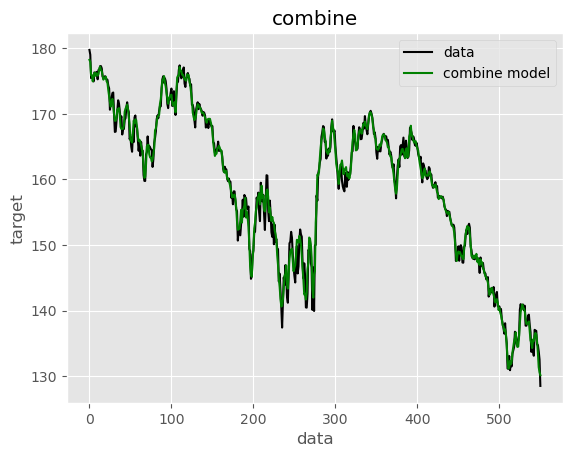

In [19]:
plt.plot(mean_actual,c='k',label='data')
plt.plot(mean_pre,c='g',label='combine model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('combine')
plt.legend()
plt.show()


In [20]:
# 傻瓜算法
stupid_actual = mean_actual
stupid_predict = [stupid_actual[0]]
stupid_predict[1:len(stupid_actual)] = stupid_actual[0:len(stupid_actual)-1]
print(len(stupid_actual))
print(len(stupid_predict))
print(stupid_actual)
print(stupid_predict)

551
551
[179.74, 179.015, 175.43000000000004, 175.6175, 175.8225, 174.935, 176.31125, 176.1625, 176.30500000000004, 176.39125, 175.26, 176.68625, 176.64625, 177.26625, 177.26999999999998, 176.93875, 175.69124999999997, 175.49124999999998, 175.51374999999996, 175.73375, 175.35000000000002, 175.27749999999997, 175.16875, 174.27875, 173.87375000000003, 170.62499999999997, 171.89250000000004, 172.415, 173.1625, 173.24625000000003, 170.0025, 167.23625000000004, 167.28875, 168.815, 170.3325, 172.06375000000003, 171.59750000000003, 170.45875, 169.205, 169.5975, 166.845, 167.68125, 167.68375000000003, 169.0575, 169.335, 170.9475, 171.7525, 170.68875, 170.27, 166.12999999999997, 166.48125, 164.99875, 164.21500000000003, 166.8775, 165.68875, 169.46125000000004, 169.74750000000003, 168.09749999999997, 167.85499999999996, 166.1375, 164.36, 165.5225, 163.61625, 165.7075, 164.37375, 164.39125, 160.6875, 159.77249999999998, 159.755, 163.79125000000002, 164.165, 166.5525, 164.7275, 165.08499999999998,

In [21]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(stupid_actual, stupid_predict))
print("mean_squared_error:", mean_squared_error(stupid_actual, stupid_predict))
print("rmse:", sqrt(mean_squared_error(stupid_actual, stupid_predict)))
print("r2 score:", r2_score(stupid_actual, stupid_predict))

mean_absolute_error: 1.2757395644283125
mean_squared_error: 3.289747600952823
rmse: 1.813766137337673
r2 score: 0.976045695761424


In [22]:
trend_actual = []

for i in range(1, len(mean_actual)):
    tmp = mean_actual[i] - mean_actual[i-1]
    if tmp < 0: # down
        trend_actual.append(2)
    elif tmp > 0: # up
        trend_actual.append(0)
    else:
        trend_actual.append(1)

print(len(trend_actual))
trend_actual

550


[2,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,


In [24]:
trend_predict = []

for i in range(1, len(mean_pre)):
    tmp = mean_pre[i] - mean_pre[i-1]
    if tmp < 0: # down
        trend_predict.append(2)
    elif tmp > 0: # up
        trend_predict.append(0)
    else:
        trend_predict.append(1)

trend_predict

[2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,


In [27]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(trend_actual, trend_predict))
print("mean_squared_error:", mean_squared_error(trend_actual, trend_predict))
print("rmse:", sqrt(mean_squared_error(trend_actual, trend_predict)))
print("r2 score:", r2_score(trend_actual, trend_predict))

mean_absolute_error: 0.7578947368421053
mean_squared_error: 1.5157894736842106
rmse: 1.231174022502185
r2 score: -0.5161187360357484


In [25]:
same = 0
up = []

for i in range(0, len(trend_actual)):
    if trend_actual[i] == trend_predict[i]:
        same = same + 1
        tmp = abs(mean_actual[i+1]-mean_actual[i])
        up.append(tmp)
        
ratio = same/len(trend_actual)
ratio

0.6981818181818182

In [29]:
up

[0.128749875000004,
 0.5312499999999929,
 0.973751,
 0.3762512500000028,
 0.9287491250000031,
 0.9449996250000012,
 3.125,
 2.674999249999999,
 2.426250374999988,
 2.347499875000004,
 0.8025016249999979,
 1.2049979999999962,
 0.856250750000001,
 1.1412506249999979,
 0.707500500000009,
 0.8412476249999941,
 1.229999625000005,
 0.858749374999995,
 0.011249500000005241,
 1.0749970000000033,
 0.15374762500000116,
 2.08749774999999,
 1.2049979999999962,
 1.084999124999996,
 0.610000625000005,
 0.22875212499999975,
 0.4949988750000003,
 1.1362496249999978,
 0.973751,
 0.9650002499999886,
 0.5074996249999941,
 0.1525001250000031,
 0.125,
 0.613750500000009,
 0.9949988749999861,
 0.8862494999999981,
 0.6149978750000002,
 3.546249375000002,
 0.19625100000001083,
 1.805000249999999,
 1.3337478750000002,
 0.2512512500000028,
 1.617500249999992,
 0.056251500000009,
 1.5824967500000042,
 1.8387488749999932,
 1.7350006249999979,
 0.07749937500000215,
 1.1237487499999972,
 0.3125,
 0.8724976250000083

In [28]:
np.mean(up)

1.1152878726340694

In [26]:
profit = []

for i in range(0, len(trend_predict)):
    if trend_predict[i] == 2:  # down
        tmp = mean_pre[i]-mean_pre[i+1]
        profit.append(tmp)
    elif trend_predict[i] == 0:
        tmp = mean_pre[i+1]-mean_pre[i]
        profit.append(tmp)
   
print(mean_actual[0])
np.sum(profit)

179.74


452.8994381538379